In [1]:
import argparse
import json
import math
import os
import random
from time import time
import mlflow
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, f1_score
from collections import defaultdict

# import pytrec_eval
import torch
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss, BCEWithLogitsLoss
from torch.utils.data import DataLoader, RandomSampler
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig, AutoTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup
from accelerate import Accelerator
from copy import deepcopy

torch.backends.cuda.matmul.allow_tf32 = True

from watchog.dataset import (
    # collate_fn,
    TURLColTypeTablewiseDataset,
    TURLRelExtTablewiseDataset,
    SatoCVTablewiseDataset,
    ColPoplTablewiseDataset
)

from watchog.dataset import TableDataset, SupCLTableDataset, SemtableCVTablewiseDataset, GittablesColwiseDataset, GittablesTablewiseDataset
from watchog.model import BertMultiPairPooler, BertForMultiOutputClassification, BertForMultiOutputClassificationColPopl, Verifier
from watchog.model import SupCLforTable, UnsupCLforTable, lm_mp
from watchog.utils import load_checkpoint, f1_score_multilabel, collate_fn, get_col_pred, ColPoplEvaluator
from watchog.utils import task_num_class_dict
from accelerate import DistributedDataParallelKwargs
import wandb

from argparse import Namespace
import torch
import random
import pandas as pd
import numpy as np
import os
import pickle
import json
import re
import transformers
from torch.utils import data
from torch.nn.utils import rnn
from transformers import AutoTokenizer

from typing import List
from functools import reduce
import operator

from itertools import chain
import copy

[nltk_data] Downloading package punkt to /home/zhihao/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/zhihao/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
    device = torch.device(2)

    parser = argparse.ArgumentParser()
    parser.add_argument("--wandb", type=bool, default=False)
    parser.add_argument("--model", type=str, default="Watchog")
    parser.add_argument("--unlabeled_train_only", type=bool, default=False)
    parser.add_argument("--context_encoding_type", type=str, default="v0")
    parser.add_argument("--pool_version", type=str, default="v0.2")
    parser.add_argument("--random_sample", type=bool, default=False)
    parser.add_argument("--comment", type=str, default="debug", help="to distinguish the runs")
    parser.add_argument(
        "--shortcut_name",
        default="bert-base-uncased",
        type=str,
        help="Huggingface model shortcut name ",
    )
    parser.add_argument(
        "--max_length",
        default=64,
        type=int,
        help=
        "The maximum total input sequence length after tokenization. Sequences longer "
        "than this will be truncated, sequences shorter will be padded.",
    )
    parser.add_argument(
        "--adaptive_max_length",
        default=False,
        type=bool,
    )    
    parser.add_argument(
        "--max_num_col",
        default=8,
        type=int,
    )   

    parser.add_argument(
        "--batch_size",
        default=3,
        type=int,
        help="Batch size",
    )
    parser.add_argument(
        "--epoch",
        default=1,
        type=int,
        help="Number of epochs for training",
    )
    parser.add_argument(
        "--random_seed",
        default=4649,
        type=int,
        help="Random seed",
    )
    
    parser.add_argument(
        "--train_n_seed_cols",
        default=-1,
        type=int,
        help="number of seeding columns in training",
    )

    parser.add_argument(
        "--num_classes",
        default=78,
        type=int,
        help="Number of classes",
    )
    parser.add_argument("--multi_gpu",
                        action="store_true",
                        default=False,
                        help="Use multiple GPU")
    parser.add_argument("--fp16",
                        action="store_true",
                        default=False,
                        help="Use FP16")
    parser.add_argument("--warmup",
                        type=float,
                        default=0.,
                        help="Warmup ratio")
    parser.add_argument("--lr", type=float, default=5e-5, help="Learning rate")
    parser.add_argument("--task",
                        type=str,
                        default='gt-semtab22-dbpedia-all0',
                        choices=[
                            "sato0", "sato1", "sato2", "sato3", "sato4",
                            "msato0", "msato1", "msato2", "msato3", "msato4",
                            "gt-dbpedia0", "gt-dbpedia1", "gt-dbpedia2", "gt-dbpedia3", "gt-dbpedia4",
                            "gt-dbpedia-all0", "gt-dbpedia-all1", "gt-dbpedia-all2", "gt-dbpedia-all3", "gt-dbpedia-all4",
                            "gt-schema-all0", "gt-schema-all1", "gt-schema-all2", "gt-schema-all3", "gt-schema-all4",
                            "gt-semtab22-dbpedia", "gt-semtab22-dbpedia0", "gt-semtab22-dbpedia1", "gt-semtab22-dbpedia2", "gt-semtab22-dbpedia3", "gt-semtab22-dbpedia4",
                            "gt-semtab22-dbpedia-all", "gt-semtab22-dbpedia-all0", "gt-semtab22-dbpedia-all1", "gt-semtab22-dbpedia-all2", "gt-semtab22-dbpedia-all3", "gt-semtab22-dbpedia-all4",
                            "gt-semtab22-schema-class-all", "gt-semtab22-schema-property-all",
                            "turl", "turl-re", "col-popl-1", "col-popl-2", "col-popl-3", "row-popl",
                            "col-popl-turl-0", "col-popl-turl-1", "col-popl-turl-2",
                            "col-popl-turl-mdonly-0", "col-popl-turl-mdonly-1", "col-popl-turl-mdonly-2"
                        ],
                        help="Task names}")
    parser.add_argument("--colpair",
                        action="store_true",
                        help="Use column pair embedding")
    parser.add_argument("--metadata",
                        action="store_true",
                        help="Use column header metadata")
    parser.add_argument("--from_scratch",
                        action="store_true",
                        help="Training from scratch")
    parser.add_argument("--cl_tag",
                        type=str,
                        default="wikitables/simclr/bert_100000_10_32_256_5e-05_sample_row4,sample_row4_tfidf_entity_column_0.05_0_last.pt",
                        help="path to the pre-trained file")
    parser.add_argument("--dropout_prob",
                        type=float,
                        default=0.5)
    parser.add_argument("--eval_test",
                        action="store_true",
                        help="evaluate on testset and do not save the model file")
    parser.add_argument("--small_tag",
                        type=str,
                        default="semi1",
                        help="e.g., by_table_t5_v1")
    parser.add_argument("--data_path",
                        type=str,
                        default="/data/zhihao/TU/")
    parser.add_argument("--pretrained_ckpt_path",
                        type=str,
                        default="/data/zhihao/TU/Watchog/model/")    

    args = parser.parse_args([])
    task = args.task
    if args.small_tag != "":
        args.eval_test = True
    
    args.num_classes = task_num_class_dict[task]
    if args.colpair:
        assert "turl-re" == task, "colpair can be only used for Relation Extraction"
    if args.metadata:
        assert "turl-re" == task or "turl" == task, "metadata can be only used for TURL datasets"
    if "col-popl":
        # metrics = {
        #     "accuracy": CategoricalAccuracy(tie_break=True),
        # }
        if args.train_n_seed_cols != -1:
            if "col-popl" in task:
                assert args.train_n_seed_cols == int(task[-1]),  "# of seed columns must match"

    print("args={}".format(json.dumps(vars(args))))

    max_length = args.max_length
    batch_size = args.batch_size
    num_train_epochs = args.epoch

    shortcut_name = args.shortcut_name

    if args.colpair and args.metadata:
        taskname = "{}-colpair-metadata".format(task)
    elif args.colpair:
        taskname = "{}-colpair".format(task)
    elif args.metadata:
        taskname = "{}-metadata".format(task)
    elif args.train_n_seed_cols == -1 and 'popl' in task:
        taskname = "{}-mix".format(task)
    else:
        taskname = "".join(task)
    cv = int(task[-1])

    if args.from_scratch:
        if "gt" in task:
            tag_name = "{}/{}-{}-{}-pool{}-max_cols{}-rand{}-bs{}-ml{}-ne{}-do{}{}".format(
                taskname,  "{}-fromscratch".format(shortcut_name), args.small_tag, args.comment, args.pool_version, args.max_num_col, args.random_sample,
                batch_size, max_length, num_train_epochs, args.dropout_prob, 
                '-rs{}'.format(args.random_seed) if args.random_seed != 4649 else '')
        else:
            tag_name = "{}/{}-{}-{}-bs{}-ml{}-ne{}-do{}{}".format(
                taskname,  "{}-fromscratch".format(shortcut_name), args.small_tag, args.comment, 
                batch_size, max_length, num_train_epochs, args.dropout_prob, 
                '-rs{}'.format(args.random_seed) if args.random_seed != 4649 else '')
        
    else:
        if "gt" in task:
            tag_name = "{}/{}_{}-pool{}-max_cols{}-rand{}-bs{}-ml{}-ne{}-do{}{}".format(
                taskname, args.cl_tag.replace('/', '-'),  shortcut_name, args.small_tag, args.pool_version, args.max_num_col, args.random_sample,
                batch_size, max_length, num_train_epochs, args.dropout_prob,
                '-rs{}'.format(args.random_seed) if args.random_seed != 4649 else '')
        else:
            tag_name = "{}/{}_{}-{}-bs{}-ml{}-ne{}-do{}{}".format(
                taskname, args.cl_tag.replace('/', '-'),  shortcut_name, args.small_tag,
                batch_size, max_length, num_train_epochs, args.dropout_prob,
                '-rs{}'.format(args.random_seed) if args.random_seed != 4649 else '')

    # if args.eval_test:
    #     if args.small_tag != '':
    #         tag_name = tag_name.replace('outputs', 'small_outputs')
    #         tag_name += '-' + args.small_tag
    print(tag_name)
    file_path = os.path.join(args.data_path, "Watchog", "outputs", tag_name)

    dirpath = os.path.dirname(file_path)
    if not os.path.exists(dirpath):
        print("{} not exists. Created".format(dirpath))
        os.makedirs(dirpath)
    
    if args.fp16:
        torch.backends.cuda.matmul.allow_fp16_reduced_precision_reduction = True
        
      
        
    # accelerator = Accelerator(mixed_precision="no" if not args.fp16 else "fp16")   
    ddp_kwargs = DistributedDataParallelKwargs(find_unused_parameters=True)
    accelerator = Accelerator(mixed_precision="no" if not args.fp16 else "fp16", kwargs_handlers=[ddp_kwargs])

    device = torch.device(1)
    ckpt_path = os.path.join(args.pretrained_ckpt_path, args.cl_tag)
    # ckpt_path = '/efs/checkpoints/{}.pt'.format(args.cl_tag)
    ckpt = torch.load(ckpt_path, map_location=device)
    ckpt_hp = ckpt['hp']
    print(ckpt_hp)
 
    setattr(ckpt_hp, 'batch_size', args.batch_size)
    setattr(ckpt_hp, 'hidden_dropout_prob', args.dropout_prob)
    setattr(ckpt_hp, 'shortcut_name', args.shortcut_name)
    setattr(ckpt_hp, 'num_labels', args.num_classes)
    
    
    
    tokenizer = BertTokenizer.from_pretrained(shortcut_name)
    padder = collate_fn(tokenizer.pad_token_id)
    if task == "turl-re" and args.colpair:
        model = BertForMultiOutputClassification(ckpt_hp, device=device, lm=ckpt['hp'].lm, col_pair='Pair')
    elif "col-popl" in task:
        model = BertForMultiOutputClassificationColPopl(ckpt_hp, device=device, lm=ckpt['hp'].lm, n_seed_cols=int(task[i][-1]), cls_for_md="md" in task)
    else:
        model = BertForMultiOutputClassification(ckpt_hp, device=device, lm=ckpt['hp'].lm, version="v0", use_attention_mask=True)
        


args={"wandb": false, "model": "Watchog", "unlabeled_train_only": false, "context_encoding_type": "v0", "pool_version": "v0.2", "random_sample": false, "comment": "debug", "shortcut_name": "bert-base-uncased", "max_length": 64, "adaptive_max_length": false, "max_num_col": 8, "batch_size": 3, "epoch": 1, "random_seed": 4649, "train_n_seed_cols": -1, "num_classes": 101, "multi_gpu": false, "fp16": false, "warmup": 0.0, "lr": 5e-05, "task": "gt-semtab22-dbpedia-all0", "colpair": false, "metadata": false, "from_scratch": false, "cl_tag": "wikitables/simclr/bert_100000_10_32_256_5e-05_sample_row4,sample_row4_tfidf_entity_column_0.05_0_last.pt", "dropout_prob": 0.5, "eval_test": true, "small_tag": "semi1", "data_path": "/data/zhihao/TU/", "pretrained_ckpt_path": "/data/zhihao/TU/Watchog/model/"}
gt-semtab22-dbpedia-all0/wikitables-simclr-bert_100000_10_32_256_5e-05_sample_row4,sample_row4_tfidf_entity_column_0.05_0_last.pt_bert-base-uncased-poolsemi1-max_colsv0.2-rand8-bsFalse-ml3-ne64-do10.

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
/tmp/ipykernel_1200793/4069850021.py:214: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control o

Namespace(augment_op='sample_row4,sample_row4', batch_size=32, data_path='/data/zhihao/TU/TURL/', fp16=True, gpus='0', lm='bert', logdir='/data/zhihao/TU/Watchog/model/', lr=5e-05, max_len=256, mode='simclr', model='Watchog', n_epochs=10, pretrain_data='wikitables', pretrained_model_path='', projector=768, run_id=0, sample_meth='tfidf_entity', save_model=10, single_column=False, size=100000, table_order='column', temperature=0.05)


A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

In [3]:
# best_state_dict = torch.load("/data/zhihao/TU/Watchog/outputs/gt-semtab22-dbpedia-all0/bert-base-uncased-fromscratch-semi1-AttnMask-max-unlabeled@8-poolv0-unlabeled8-randFalse-bs16-ml128-ne50-do0.1_best_f1_micro.pt", map_location=device)
best_state_dict = torch.load("/data/zhihao/TU/Watchog/outputs/gt-semtab22-dbpedia-all0/bert-base-uncased-fromscratch-semi1-Repeat@5-AttnMask-UnlabelValid-max-unlabeled@8-poolv0-unlabeled8-randFalse-bs16-ml128-ne50-do0.1_best_f1_macro.pt", map_location=device)
model.load_state_dict(best_state_dict, strict=False)

/tmp/ipykernel_1200793/307592194.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_state_dict = torch.load("/data/zhihao/TU/Watchog/outputs/gt-semtab22-dbpedia-all0/b

<All keys matched successfully>

In [4]:
class GittablesTablewiseIterateDataset(data.Dataset):

    def __init__(
            self,
            cv: int,
            split: str,
            src: str,  # train or test
            tokenizer: AutoTokenizer,
            max_length: int = 256,
            gt_only: bool = False,
            device: torch.device = None,
            base_dirpath: str = "/data/zhihao/TU/GitTables/semtab_gittables/2022",
            base_tag: str = '', # blank, comma
            small_tag: str = "",
            train_ratio: float = 1.0,
            max_unlabeled=8,
            random_sample=False, # TODO
            train_only=False): # TODO
        if device is None:
            device = torch.device('cpu')
        basename = small_tag+ "_cv_{}.csv"
    
        if split in ["train", "valid"]:
            df_list = []
            for i in range(5):
                if i == cv:
                    continue
                filepath = os.path.join(base_dirpath, basename.format(i))
                df_list.append(pd.read_csv(filepath))
                print(split, i)
            df = pd.concat(df_list, axis=0)
        else:
            # test
            filepath = os.path.join(base_dirpath, basename.format(cv))
            df = pd.read_csv(filepath)
            print(split)


        if gt_only:
            df = df[df["class_id"] > -1]
        if train_only and split != "train":
            df = df[df["class_id"] > -1]

        
        data_list = []
        
        df['class_id'] = df['class_id'].astype(int)
        df.drop(df[(df['data'].isna()) & (df['class_id'] == -1)].index, inplace=True)
        df['col_idx'] = df['col_idx'].astype(int)
        df['data'] = df['data'].astype(str)
        
        num_tables = len(df.groupby("table_id"))
        valid_index = int(num_tables * 0.8)
        num_train = int(train_ratio * num_tables * 0.8)        
        
        # df.drop(df[(df['data'] == '') & (df['class_id'] == -1)].index, inplace=True)
        total_num_cols = 0
        for i, (index, group_df) in enumerate(df.groupby("table_id")):
            if (split == "train") and ((i >= num_train) or (i >= valid_index)):
                break
            if split == "valid" and i < valid_index:
                continue
            #     break
            labeled_columns = group_df[group_df['class_id'] > -1]
            unlabeled_columns = group_df[group_df['class_id'] == -1]
            num_unlabeled = min(max(max_unlabeled-len(labeled_columns), 0), len(unlabeled_columns)) if max_unlabeled > 0 else len(unlabeled_columns)
            unlabeled_columns = unlabeled_columns.sample(num_unlabeled) if random_sample else unlabeled_columns[0:num_unlabeled]
            # group_df = pd.concat([group_df[group_df['class_id'] > -1], unlabeled_columns.sample(min(10-len(labeled_columns), len(unlabeled_columns)))])
            # group_df = pd.concat([group_df[group_df['class_id'] > -1], unlabeled_columns[0:min(max(10-len(labeled_columns), 0), len(unlabeled_columns))]])
            group_df = pd.concat([group_df[group_df['class_id'] > -1], unlabeled_columns]) # TODO
            group_df.sort_values(by=['col_idx'], inplace=True)

            if max_length <= 128:
                cur_maxlen = min(max_length, 512 // len(list(group_df["class_id"].values)) - 1)
            else:
                cur_maxlen = max(1, max_length // len(list(group_df["class_id"].values)) - 1)
                
            token_ids_list = group_df["data"].apply(lambda x: tokenizer.encode(
                tokenizer.cls_token + " " + x, add_special_tokens=False, max_length=cur_maxlen, truncation=True)).tolist(
                )
            token_ids = torch.LongTensor(reduce(operator.add,
                                                token_ids_list)).to(device)
            for col_i in range(len(token_ids_list)):
                if group_df["class_id"].values[col_i] == -1:
                    continue
                target_col_mask = []
                cls_index_value = 0
                context_id = 1
                for col_j in range(len(token_ids_list)):
                    if col_j == col_i:
                        target_col_mask += [0] * len(token_ids_list[col_j])
                    else:
                        target_col_mask += [context_id] * len(token_ids_list[col_j])
                        context_id += 1
                    if col_j < col_i:
                        cls_index_value += len(token_ids_list[col_j])
                cls_index_list = [cls_index_value] 
                for cls_index in cls_index_list:
                    assert token_ids[
                        cls_index] == tokenizer.cls_token_id, "cls_indexes validation"
                cls_indexes = torch.LongTensor(cls_index_list).to(device)
                class_ids = torch.LongTensor(
                    [group_df["class_id"].values[col_i]]).to(device)
                target_col_mask = torch.LongTensor(target_col_mask).to(device)
                data_list.append(
                    [index,
                    len(group_df), token_ids, class_ids, cls_indexes, target_col_mask])                
        print(split, len(data_list))
        self.table_df = pd.DataFrame(data_list,
                                     columns=[
                                         "table_id", "num_col", "data_tensor",
                                         "label_tensor", "cls_indexes", "target_col_mask"
                                     ])
        """
        # NOTE: msato contains a small portion of single-col tables. keep it to be consistent.  
        if multicol_only:
            # Check
            num_all_tables = len(self.table_df)
            self.table_df = self.table_df[self.table_df["num_col"] > 1]
            assert len(self.table_df) == num_all_tables
        """

    def __len__(self):
        return len(self.table_df)

    def __getitem__(self, idx):
        return {
            "data": self.table_df.iloc[idx]["data_tensor"],
            "label": self.table_df.iloc[idx]["label_tensor"],
            "cls_indexes": self.table_df.iloc[idx]["cls_indexes"],
            "target_col_mask": self.table_df.iloc[idx]["target_col_mask"],
        }
        #"idx": torch.LongTensor([idx])}
        #"cls_indexes": self.table_df.iloc[idx]["cls_indexes"]}

In [5]:
def collate_fn(pad_token_id, data_only=True):
    '''padder for input batch'''

    def padder(samples):    
        data = torch.nn.utils.rnn.pad_sequence(
            [sample["data"] for sample in samples], padding_value=pad_token_id)
        if not data_only:
            label = torch.nn.utils.rnn.pad_sequence(
                [sample["label"] for sample in samples], padding_value=-1)
        else:
            label = torch.cat([sample["label"] for sample in samples])
        batch = {"data": data, "label": label}
        if "idx" in samples[0]:
            batch["idx"] = [sample["idx"] for sample in samples]
        if "cls_indexes" in samples[0]:
            cls_indexes = torch.nn.utils.rnn.pad_sequence(
                [sample["cls_indexes"] for sample in samples], padding_value=0)
            batch["cls_indexes"] = cls_indexes
        if "target_col_mask" in samples[0]:
            target_col_mask = torch.nn.utils.rnn.pad_sequence(
                [sample["target_col_mask"] for sample in samples], padding_value=-1)
            batch["target_col_mask"] = target_col_mask
        if "table_embedding" in samples[0]:
            table_embeddings = [sample["table_embedding"] for sample in samples]
            batch["table_embedding"] = torch.stack(table_embeddings, dim=0)
        return batch
        
    return padder

In [6]:
src = None
test_dataset_iter = GittablesTablewiseIterateDataset(cv=cv,
                            split="test", src=src,
                            tokenizer=tokenizer,
                            max_length=max_length,
                            gt_only='all' not in task,
                            device=device,
                            base_dirpath=os.path.join(args.data_path, "GitTables/semtab_gittables/2022"),
                            small_tag="semi1")
padder = collate_fn(tokenizer.pad_token_id)
test_dataloader_iter = DataLoader(test_dataset_iter,
                                batch_size=1,
                            #   collate_fn=collate_fn)
                            collate_fn=padder)

test
test 1085


In [7]:
train_dataset_iter = GittablesTablewiseIterateDataset(cv=cv,
                            split="train", src=src,
                            tokenizer=tokenizer,
                            max_length=max_length,
                            gt_only='all' not in task,
                            device=device,
                            base_dirpath=os.path.join(args.data_path, "GitTables/semtab_gittables/2022"),
                            small_tag="semi1")
padder = collate_fn(tokenizer.pad_token_id)
train_dataloader_iter = DataLoader(train_dataset_iter,
                                batch_size=1,
                            #   collate_fn=collate_fn)
                            collate_fn=padder)

train 1
train 2
train 3
train 4
train 3463


In [7]:
src = None
valid_dataset_iter = GittablesTablewiseIterateDataset(cv=cv,
                            split="valid", src=src,
                            tokenizer=tokenizer,
                            max_length=max_length,
                            gt_only='all' not in task,
                            device=device,
                            base_dirpath=os.path.join(args.data_path, "GitTables/semtab_gittables/2022"),
                            small_tag="semi1")
padder = collate_fn(tokenizer.pad_token_id)
valid_dataloader_iter = DataLoader(valid_dataset_iter,
                                batch_size=1,
                            #   collate_fn=collate_fn)
                            collate_fn=padder)

valid 1
valid 2
valid 3
valid 4
valid 885


In [8]:
model.eval()
model = model.to(device)
ft_embs_test = []
labels_test = []
logits_test = []
num_cols = []
for batch_idx, batch in enumerate(test_dataloader_iter):
    cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
    target_col_mask = batch["target_col_mask"].T
    logits, embs = model(batch["data"].T, cls_indexes=cls_indexes, get_enc=True)
    labels_test.append(batch["label"].cpu())
    logits_test.append(logits.detach().cpu())
    num_cols.append(batch["target_col_mask"].max().item())
    ft_embs_test.append(embs.detach().cpu().reshape(1, -1))
labels_test = torch.cat(labels_test, dim=0)
logits_test = torch.stack(logits_test, dim=0)
preds_test = torch.argmax(logits_test, dim=1)
num_cols = torch.tensor(num_cols)
ft_embs_test = torch.cat(ft_embs_test, dim=0)
from sklearn.metrics import confusion_matrix, f1_score
mask = num_cols > 0
ts_pred_list = logits_test.argmax(
                            1).cpu().detach().numpy().tolist()
ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="micro")
ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="macro")
full_f1_init = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average=None)
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
ts_pred_list = logits_test.argmax(
                            1).cpu().detach()[mask].numpy().tolist()
ts_micro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                    ts_pred_list,
                    average="micro")
ts_macro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                    ts_pred_list,
                    average="macro")
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
ts_pred_list = logits_test.argmax(
                            1).cpu().detach()[~mask].numpy().tolist()
ts_micro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                    ts_pred_list,
                    average="micro")
ts_macro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                    ts_pred_list,
                    average="macro")
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))

ts_micro_f1=0.5355, ts_macro_f1=0.2745
ts_micro_f1=0.5351, ts_macro_f1=0.2745
ts_micro_f1=1.0000, ts_macro_f1=1.0000


In [103]:
full_f1_init

array([0.82129278, 0.7003367 , 0.49019608, 0.41463415, 0.5       ,
       0.57777778, 0.54545455, 0.5       , 0.31578947, 0.81081081,
       0.21621622, 0.20689655, 0.84848485, 0.1875    , 0.64285714,
       0.86666667, 0.10526316, 0.5       , 0.21428571, 0.92307692,
       0.46153846, 0.56      , 0.28571429, 0.42105263, 0.31578947,
       0.33333333, 0.26666667, 0.        , 0.14285714, 0.5       ,
       0.36363636, 0.        , 0.        , 0.35294118, 0.44444444,
       0.42857143, 0.26666667, 0.2       , 0.25      , 0.2       ,
       0.        , 0.28571429, 0.30769231, 0.22222222, 0.        ,
       0.        , 0.33333333, 0.        , 0.33333333, 0.33333333,
       0.28571429, 0.        , 0.5       , 0.25      , 0.66666667,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 1.        , 0.        , 0.66666667, 0.        ,
       0.        , 0.        , 0.5       , 0.33333333, 0.33333333,
       0.        , 0.        , 0.        , 0.        , 0.     

In [45]:
model.eval()
model = model.to(device)
ft_embs_test = []
labels_test = []
logits_test = []
num_cols = []
for batch_idx, batch in enumerate(valid_dataloader_iter):
    cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
    target_col_mask = batch["target_col_mask"].T
    logits, embs = model(batch["data"].T, cls_indexes=cls_indexes, get_enc=True)
    labels_test.append(batch["label"].cpu())
    logits_test.append(logits.detach().cpu())
    num_cols.append(batch["target_col_mask"].max().item())
    ft_embs_test.append(embs.detach().cpu().reshape(1, -1))
labels_test = torch.cat(labels_test, dim=0)
logits_test = torch.stack(logits_test, dim=0)
preds_test = torch.argmax(logits_test, dim=1)
num_cols = torch.tensor(num_cols)
ft_embs_test = torch.cat(ft_embs_test, dim=0)
from sklearn.metrics import confusion_matrix, f1_score
mask = num_cols > 0
ts_pred_list = logits_test.argmax(
                            1).cpu().detach().numpy().tolist()
ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="micro")
ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="macro")
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
ts_pred_list = logits_test.argmax(
                            1).cpu().detach()[mask].numpy().tolist()
ts_micro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                    ts_pred_list,
                    average="micro")
ts_macro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                    ts_pred_list,
                    average="macro")
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
ts_pred_list = logits_test.argmax(
                            1).cpu().detach()[~mask].numpy().tolist()
ts_micro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                    ts_pred_list,
                    average="micro")
ts_macro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                    ts_pred_list,
                    average="macro")
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))

ts_micro_f1=0.5503, ts_macro_f1=0.3178
ts_micro_f1=0.5493, ts_macro_f1=0.3178
ts_micro_f1=1.0000, ts_macro_f1=1.0000


In [9]:
class_freq = torch.zeros(args.num_classes)
for batch_idx, batch in enumerate(train_dataloader_iter):
    class_freq[batch["label"].item()] += 1

In [10]:
# def reweight_logits(logits, class_weights):
#     # Reweight the logits by multiplying with class weights
#     reweighted_logits = logits * torch.sqrt(class_weights)
    
#     # Apply softmax to the reweighted logits
#     reweighted_probs = F.softmax(reweighted_logits, dim=-1)
    
#     return reweighted_probs
def reweight_logits(logits, class_weights):
    # Step 1: Apply exp(logits)
    exp_logits = torch.exp(logits)
    
    # Step 2: Multiply by class weights
    # reweighted_exp = exp_logits * torch.sqrt(class_weights)
    reweighted_exp = exp_logits * class_weights
    # Step 3: Normalize to get valid probabilities (like softmax)
    reweighted_probs = reweighted_exp / reweighted_exp.sum(dim=-1, keepdim=True)
    
    return reweighted_probs

In [12]:

# brute force perumate, find uncertain init prediction, weighted msp
import itertools

def is_sublist(A, B):
    it = iter(B)
    return all(x in it for x in A)
def get_permutation(x):
    new = []
    x = x.tolist()
    if len(x) == 1:
        x = x[0]
    for k in x:
        if k not in new:
            new.append(k)
    return new
    
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
change_log = []
score_init = []
score_best = [] 
idx_list = []
uncertain_init_mask = []
uncertain_target_mask = []
correct_init_mask = []
correct_target_mask = []
correct_permutation_mask = []
correct_permutation_confident_mask = []
correct_permutation_confident_scores = []
correct_msp_mask = []
init_target_mask = []
ood_score_init_list = []
ood_score_target_list = []
ood_score_final_list = []
msp_predicts = []
max_col_length = 3

alpha = 0
# class_weights = (1.0 / class_freq) ** alpha
# debias_threshold = 1.0
# # Normalize the weights
# class_weights /= class_weights.sum()
for threshold in [0.9]:
    print(f"*********************Threshold: {threshold}****************************")
    ft_embs_test = []
    labels_test = []
    logits_test = []
    log = defaultdict(list)
    num_cols = []
    corrected = 0
    total_mistakes = 0

    for batch_idx, batch in enumerate(test_dataloader_iter):
        target_col_mask = batch["target_col_mask"].T
        if 1 in target_col_mask:
            idx_list.append(batch_idx)

            cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
            logits = model(batch["data"].T, cls_indexes=cls_indexes,)
            # logits = reweight_logits(logits.detach().cpu(), class_weights)
            logits = F.softmax(logits, dim=-1)
            num_cols.append(batch["target_col_mask"].max().item())         
            ood_score_init = logits.max().item()
            ood_score_init_list.append(ood_score_init)
            uncertain_init_mask.append(ood_score_init < threshold)
            predict_init = logits.argmax().item()
            correct_init_mask.append(predict_init == batch["label"].item())
            init_permutation_i = get_permutation(target_col_mask)
            
            correct_permutation = False
            correct_permutation_ood_score = 0.0
            correct_permutation_confident = False
            ood_score_max = max_msp = 0
            max_msp_debiased = 0
            debias_class = []
            col_idx_set = target_col_mask.unique().tolist()
            assert -1 not in col_idx_set
            for r in range(len(col_idx_set)-1, len(col_idx_set)//2, -1):
                for subset in itertools.combinations(col_idx_set, r):
                    if 0 not in subset and r != 1:
                        continue
                    for x in itertools.permutations(subset):
                        if not is_sublist(x, init_permutation_i):
                            continue
                        new_batch_data = []
                        for col_i in x:
                            if col_i == 0:
                                if len(new_batch_data) == 0:
                                    cls_indexes_value = 0
                                else:
                                    cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                            new_batch_data.append(batch["data"].T[target_col_mask==col_i])
                        if 0 not in x:
                            cls_indexes_value = 0
                        new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
                        cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
                        logits_temp = model(new_batch_data, cls_indexes=cls_indexes,)
                        logits_temp = F.softmax(logits_temp, dim=-1)
                        # logits_temp = reweight_logits(logits_temp.detach().cpu(), class_weights)
                        msp_temp = logits_temp.max().item()
                        predict_temp = logits_temp.argmax().item()
                        # if 0 not in x and msp_temp > debias_threshold and (predict_temp!=predict_target or predict_temp!=predict_init):
                        #     debias_class.append(predict_temp)
                        #     continue
                        # print(x, msp_temp, predict_temp)
                        # if msp_temp > max_msp and 0 in x and predict_temp not in debias_class:
                        if msp_temp > max_msp and 0 in x:
                            max_msp = msp_temp
                            msp_predict = predict_temp
                        if predict_temp == batch["label"].item():
                            correct_permutation = True
                            if msp_temp > correct_permutation_ood_score:
                                correct_permutation_ood_score = msp_temp
            msp_predicts.append(msp_predict)
            ood_score_final_list.append(max_msp)
            correct_permutation_mask.append(correct_permutation)
            correct_permutation_confident_scores.append(correct_permutation_ood_score)
            correct_msp_mask.append(msp_predict == batch["label"].item())

*********************Threshold: 0.9****************************


In [14]:

# idx_list = torch.tensor(idx_list).reshape(-1)
# uncertain_init_mask = torch.tensor(uncertain_init_mask).reshape(-1)
# uncertain_target_mask = torch.tensor(uncertain_target_mask).reshape(-1)
# correct_init_mask = torch.tensor(correct_init_mask).reshape(-1)
# correct_target_mask = torch.tensor(correct_target_mask).reshape(-1)
# correct_permutation_mask = torch.tensor(correct_permutation_mask).reshape(-1)
# correct_permutation_confident_scores = torch.tensor(correct_permutation_confident_scores).reshape(-1)
# correct_msp_mask = torch.tensor(correct_msp_mask).reshape(-1)
# init_target_mask = torch.tensor(init_target_mask).reshape(-1)
# ood_score_init_list = torch.tensor(ood_score_init_list).reshape(-1)
# ood_score_target_list = torch.tensor(ood_score_target_list).reshape(-1)
# ood_score_final_list = torch.tensor(ood_score_final_list).reshape(-1)
# msp_predicts = torch.tensor(msp_predicts).reshape(-1)
# print(len(idx_list), len(init_target_mask), len(correct_init_mask), len(correct_target_mask), len(correct_permutation_mask))
# torch.save({"idx_list": idx_list, "uncertain_init_mask": uncertain_init_mask, "uncertain_target_mask": uncertain_target_mask, "correct_init_mask": correct_init_mask, "correct_target_mask": correct_target_mask, "correct_permutation_mask": correct_permutation_mask, "correct_msp_mask": correct_msp_mask, "init_target_mask": init_target_mask, "ood_score_init_list": ood_score_init_list, "ood_score_target_list": ood_score_target_list, "ood_score_final_list": ood_score_final_list}, f"./results/brute_force_permutation_alpha@{alpha}_drop.pth")

/tmp/ipykernel_3888413/4104837288.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  idx_list = torch.tensor(idx_list).reshape(-1)
/tmp/ipykernel_3888413/4104837288.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  uncertain_init_mask = torch.tensor(uncertain_init_mask).reshape(-1)
/tmp/ipykernel_3888413/4104837288.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  uncertain_target_mask = torch.tensor(uncertain_target_mask).reshape(-1)
/tmp/ipykernel_3888413/4104837288.py:4: UserWarning: To copy construct from a tensor, it is recommen

1084 0 1084 0 1084


In [53]:
# Cheat brute force perumate

import itertools
import torch.nn.functional as F
import time
for max_col_length in [2]:
    start = time.time()
    print(f"*********************Max Column Length: {max_col_length}****************************")
    model.load_state_dict(best_state_dict, strict=False)
    model.eval()
    model = model.to(device)
    ft_embs_test = []
    labels_test = []
    logits_test = []
    log = defaultdict(list)
    num_cols = []
    threshold = 0.8
    corrected = 0
    total_mistakes = 0
    init_permutation = defaultdict(list)
    corrected_permutation = defaultdict(list)
    init_logits = defaultdict(list)
    corrected_logits = defaultdict(list)
    MSP_permutation = defaultdict(list)
    MSP_logits = defaultdict(list)
    MSP_corrected = 0
    Entropy_permutation = defaultdict(list)
    Entropy_logits = defaultdict(list)
    Entropy_corrected = 0
    for batch_idx, batch in enumerate(test_dataloader_iter):
        cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
        target_col_mask = batch["target_col_mask"].T
        logits = model(batch["data"].T, cls_indexes=cls_indexes,)
        num_cols.append(batch["target_col_mask"].max().item())
        if 1 in target_col_mask and logits.argmax().item() != batch["label"].item():
            total_mistakes += 1
            col_idx_set = target_col_mask.unique().tolist()
            successs = False
            assert -1 not in col_idx_set
            for r in range(len(init_permutation_i)-1, 0, -1): # not 
                for x in itertools.combinations(init_permutation_i, r):
                    if 0 not in x:
                        continue
                    new_batch_data = []
                    for col_i in x:
                        if col_i == 0:
                            if len(new_batch_data) == 0:
                                cls_indexes_value = 0
                            else:
                                cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                        new_batch_data.append(batch["data"].T[target_col_mask==col_i])
                    new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
                    cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
                    logits_temp = model(new_batch_data, cls_indexes=cls_indexes,)
                    if logits_temp.argmax().item() == batch["label"].item():
                        logits = logits_temp.clone()
                        successs = True
                        corrected_permutation[batch_idx].append(x)
                        corrected_logits[batch_idx].append(logits_temp.clone().detach().cpu())
                        break
                if successs:
                    break          
            if successs:
                corrected += 1
        labels_test.append(batch["label"].cpu())
        logits_test.append(logits.detach().cpu())
    labels_test = torch.cat(labels_test, dim=0)
    logits_test = torch.stack(logits_test, dim=0)
    preds_test = torch.argmax(logits_test, dim=1)
    num_cols = torch.tensor(num_cols)




    from sklearn.metrics import confusion_matrix, f1_score
    mask = num_cols > 0
    ts_pred_list = logits_test.argmax(
                                1).cpu().detach().numpy().tolist()
    ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                        ts_pred_list,
                        average="micro")
    ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                        ts_pred_list,
                        average="macro")
    print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
    ts_pred_list = logits_test.argmax(
                                1).cpu().detach()[mask].numpy().tolist()
    ts_micro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                        ts_pred_list,
                        average="micro")
    ts_macro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                        ts_pred_list,
                        average="macro")
    print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
    ts_pred_list = logits_test.argmax(
                                1).cpu().detach()[~mask].numpy().tolist()
    ts_micro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                        ts_pred_list,
                        average="micro")
    ts_macro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                        ts_pred_list,
                        average="macro")
    print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
    print(f"Time: {time.time()-start}")

*********************Max Column Length: 2****************************
ts_micro_f1=0.7558, ts_macro_f1=0.5195
ts_micro_f1=0.7555, ts_macro_f1=0.5195
ts_micro_f1=1.0000, ts_macro_f1=1.0000
Time: 397.4999978542328


In [81]:
# Cheat brute force perumate

import itertools
import torch.nn.functional as F
import time
for max_col_length in [2]:
    start = time.time()
    print(f"*********************Max Column Length: {max_col_length}****************************")
    model.load_state_dict(best_state_dict, strict=False)
    model.eval()
    model = model.to(device)
    ft_embs_test = []
    labels_test = []
    logits_test = []
    log = defaultdict(list)
    num_cols = []
    threshold = 0.8
    corrected = 0
    total_mistakes = 0
    init_permutation = defaultdict(list)
    corrected_permutation = defaultdict(list)
    init_logits = defaultdict(list)
    corrected_logits = defaultdict(list)
    MSP_permutation = defaultdict(list)
    MSP_logits = defaultdict(list)
    MSP_corrected = 0
    Entropy_permutation = defaultdict(list)
    Entropy_logits = defaultdict(list)
    Entropy_corrected = 0
    for batch_idx, batch in enumerate(test_dataloader_iter):
        cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
        target_col_mask = batch["target_col_mask"].T
        logits = model(batch["data"].T, cls_indexes=cls_indexes,)
        num_cols.append(batch["target_col_mask"].max().item())
        if 1 in target_col_mask and logits.argmax().item() != batch["label"].item():
            total_mistakes += 1
            col_idx_set = target_col_mask.unique().tolist()
            successs = False
            assert -1 not in col_idx_set
            for r in range(len(init_permutation_i)-1, len(init_permutation_i)-2, -1): # not 
                for x in itertools.combinations(init_permutation_i, r):
                    if 0 not in x:
                        continue
                    new_batch_data = []
                    for col_i in x:
                        if col_i == 0:
                            if len(new_batch_data) == 0:
                                cls_indexes_value = 0
                            else:
                                cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                        new_batch_data.append(batch["data"].T[target_col_mask==col_i])
                    new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
                    cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
                    logits_temp = model(new_batch_data, cls_indexes=cls_indexes,)
                    if logits_temp.argmax().item() == batch["label"].item():
                        logits = logits_temp.clone()
                        successs = True
                        corrected_permutation[batch_idx].append(x)
                        corrected_logits[batch_idx].append(logits_temp.clone().detach().cpu())
                        break
                if successs:
                    break          
            if successs:
                corrected += 1
        labels_test.append(batch["label"].cpu())
        logits_test.append(logits.detach().cpu())
    labels_test = torch.cat(labels_test, dim=0)
    logits_test = torch.stack(logits_test, dim=0)
    preds_test = torch.argmax(logits_test, dim=1)
    num_cols = torch.tensor(num_cols)




    from sklearn.metrics import confusion_matrix, f1_score
    mask = num_cols > 0
    ts_pred_list = logits_test.argmax(
                                1).cpu().detach().numpy().tolist()
    ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                        ts_pred_list,
                        average="micro")
    ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                        ts_pred_list,
                        average="macro")
    print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
    ts_pred_list = logits_test.argmax(
                                1).cpu().detach()[mask].numpy().tolist()
    ts_micro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                        ts_pred_list,
                        average="micro")
    ts_macro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                        ts_pred_list,
                        average="macro")
    print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
    ts_pred_list = logits_test.argmax(
                                1).cpu().detach()[~mask].numpy().tolist()
    ts_micro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                        ts_pred_list,
                        average="micro")
    ts_macro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                        ts_pred_list,
                        average="macro")
    print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
    print(f"Time: {time.time()-start}")

*********************Max Column Length: 2****************************
ts_micro_f1=0.6083, ts_macro_f1=0.3279
ts_micro_f1=0.6079, ts_macro_f1=0.3279
ts_micro_f1=1.0000, ts_macro_f1=1.0000
Time: 29.16684079170227


In [20]:

# brute force perumate, find uncertain init prediction, weighted msp
import itertools

def is_sublist(A, B):
    it = iter(B)
    return all(x in it for x in A)
def get_permutation(x):
    new = []
    x = x.tolist()
    if len(x) == 1:
        x = x[0]
    for k in x:
        if k not in new:
            new.append(k)
    return new
    
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
change_log = []
score_init = []
score_best = [] 
idx_list = []
uncertain_init_mask = []
uncertain_target_mask = []
correct_init_mask = []
correct_target_mask = []
correct_permutation_mask = []
correct_permutation_confident_mask = []
correct_permutation_confident_scores = []
correct_msp_mask = []
init_target_mask = []
ood_score_init_list = []
ood_score_target_list = []
ood_score_final_list = []
msp_predicts = []
max_col_length = 3

alpha = 0.25
class_weights = (1.0 / class_freq) ** alpha
debias_threshold = 1.0
# Normalize the weights
class_weights /= class_weights.sum()
for threshold in [0.9]:
    print(f"*********************Threshold: {threshold}****************************")
    ft_embs_test = []
    labels_test = []
    logits_test = []
    log = defaultdict(list)
    num_cols = []
    corrected = 0
    total_mistakes = 0

    for batch_idx, batch in enumerate(test_dataloader_iter):
        target_col_mask = batch["target_col_mask"].T
        if 1 in target_col_mask:
            idx_list.append(batch_idx)

            cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
            logits = model(batch["data"].T, cls_indexes=cls_indexes,)
            logits = reweight_logits(logits.detach().cpu(), class_weights)
            num_cols.append(batch["target_col_mask"].max().item())         
            ood_score_init = logits.max().item()
            ood_score_init_list.append(ood_score_init)
            uncertain_init_mask.append(ood_score_init < threshold)
            predict_init = logits.argmax().item()
            correct_init_mask.append(predict_init == batch["label"].item())
            init_permutation_i = get_permutation(target_col_mask)
            
            correct_permutation = False
            correct_permutation_ood_score = 0.0
            correct_permutation_confident = False
            ood_score_max = max_msp = 0
            max_msp_debiased = 0
            debias_class = []
            col_idx_set = target_col_mask.unique().tolist()
            assert -1 not in col_idx_set
            for r in range(len(col_idx_set)-1, len(col_idx_set)//2, -1):
                for subset in itertools.combinations(col_idx_set, r):
                    if 0 not in subset and r != 1:
                        continue
                    for x in itertools.permutations(subset):
                        if not is_sublist(x, init_permutation_i):
                            continue
                        new_batch_data = []
                        for col_i in x:
                            if col_i == 0:
                                if len(new_batch_data) == 0:
                                    cls_indexes_value = 0
                                else:
                                    cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                            new_batch_data.append(batch["data"].T[target_col_mask==col_i])
                        if 0 not in x:
                            cls_indexes_value = 0
                        new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
                        cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
                        logits_temp = model(new_batch_data, cls_indexes=cls_indexes,)
                        logits_temp = reweight_logits(logits_temp.detach().cpu(), class_weights)
                        msp_temp = logits_temp.max().item()
                        predict_temp = logits_temp.argmax().item()
                        # if 0 not in x and msp_temp > debias_threshold and (predict_temp!=predict_target or predict_temp!=predict_init):
                        #     debias_class.append(predict_temp)
                        #     continue
                        # print(x, msp_temp, predict_temp)
                        # if msp_temp > max_msp and 0 in x and predict_temp not in debias_class:
                        if msp_temp > max_msp and 0 in x:
                            max_msp = msp_temp
                            msp_predict = predict_temp
                        if predict_temp == batch["label"].item():
                            correct_permutation = True
                            if msp_temp > correct_permutation_ood_score:
                                correct_permutation_ood_score = msp_temp
            msp_predicts.append(msp_predict)
            ood_score_final_list.append(max_msp)
            correct_permutation_mask.append(correct_permutation)
            correct_permutation_confident_scores.append(correct_permutation_ood_score)
            correct_msp_mask.append(msp_predict == batch["label"].item())

*********************Threshold: 0.9****************************


In [21]:

idx_list = torch.tensor(idx_list).reshape(-1)
uncertain_init_mask = torch.tensor(uncertain_init_mask).reshape(-1)
uncertain_target_mask = torch.tensor(uncertain_target_mask).reshape(-1)
correct_init_mask = torch.tensor(correct_init_mask).reshape(-1)
correct_target_mask = torch.tensor(correct_target_mask).reshape(-1)
correct_permutation_mask = torch.tensor(correct_permutation_mask).reshape(-1)
correct_permutation_confident_scores = torch.tensor(correct_permutation_confident_scores).reshape(-1)
correct_msp_mask = torch.tensor(correct_msp_mask).reshape(-1)
init_target_mask = torch.tensor(init_target_mask).reshape(-1)
ood_score_init_list = torch.tensor(ood_score_init_list).reshape(-1)
ood_score_target_list = torch.tensor(ood_score_target_list).reshape(-1)
ood_score_final_list = torch.tensor(ood_score_final_list).reshape(-1)
msp_predicts = torch.tensor(msp_predicts).reshape(-1)
print(len(idx_list), len(init_target_mask), len(correct_init_mask), len(correct_target_mask), len(correct_permutation_mask))
torch.save({"idx_list": idx_list, "uncertain_init_mask": uncertain_init_mask, "uncertain_target_mask": uncertain_target_mask, "correct_init_mask": correct_init_mask, "correct_target_mask": correct_target_mask, "correct_permutation_mask": correct_permutation_mask, "correct_msp_mask": correct_msp_mask, "init_target_mask": init_target_mask, "ood_score_init_list": ood_score_init_list, "ood_score_target_list": ood_score_target_list, "ood_score_final_list": ood_score_final_list}, f"./results/brute_force_permutation_alpha@{alpha}_drop.pth")

1084 0 1084 0 1084


In [22]:
# weighted, only uncertain init

for threshold in [0.8, 0.9, 0.99]:
    correct_permutation_confident_mask = correct_permutation_confident_scores>threshold
    uncertain_init_mask = ood_score_init_list < threshold
    uncertain_target_mask = ood_score_target_list < threshold
    condition_mask = ~uncertain_init_mask
    print(f"*********************Threshold: {threshold}****************************")
    print("Init")
    # init prediction
    print((condition_mask&correct_init_mask).sum().item(), 
        (condition_mask).sum().item(), 
        (condition_mask&correct_init_mask).sum().item()/(condition_mask).sum().item())
    # init prediction
    print((~condition_mask&correct_init_mask).sum().item(), 
        (~condition_mask).sum().item(), 
       (~condition_mask&correct_init_mask).sum().item()/(~condition_mask).sum().item())
    print("MSP")
    # msp prediction
    print((condition_mask&correct_msp_mask).sum().item(), 
        (condition_mask).sum().item(), 
        (condition_mask&correct_msp_mask).sum().item()/(condition_mask).sum().item())
    # msp prediction
    print((~condition_mask&correct_msp_mask).sum().item(), 
        (~condition_mask).sum().item(), 
        (~condition_mask&correct_msp_mask).sum().item()/(~condition_mask).sum().item())
    print("MSP & Init")
    print(((condition_mask&correct_init_mask)&(condition_mask&correct_msp_mask)).sum().item())
    # print(((~(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask))& correct_msp_mask)&(~(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask))& correct_init_mask)).sum().item())
    print(((condition_mask&correct_init_mask)|(condition_mask&correct_msp_mask)).sum().item(),
          (condition_mask).sum().item(), 
          ((condition_mask&correct_init_mask)|(condition_mask&correct_msp_mask)).sum().item()/(condition_mask).sum().item())
    print(((~condition_mask&correct_init_mask)|(~condition_mask&correct_msp_mask)).sum().item(),
          (~condition_mask).sum().item(), 
          ((~condition_mask&correct_init_mask)|(~condition_mask&correct_msp_mask)).sum().item()/(~condition_mask).sum().item())
    print("Permutation")
    print((condition_mask&correct_permutation_mask).sum().item(), 
        (condition_mask).sum().item(), 
        (condition_mask&correct_permutation_mask).sum().item()/(condition_mask).sum().item())
    print((~condition_mask&correct_permutation_mask).sum().item(), 
         (~condition_mask).sum().item(), 
        (~condition_mask&correct_permutation_mask).sum().item()/(~condition_mask).sum().item())
    print("Permutation Confident")
    print((condition_mask&correct_permutation_confident_mask).sum().item(), 
        (condition_mask).sum().item(), 
        (condition_mask&correct_permutation_confident_mask).sum().item()/(condition_mask).sum().item())
    print((~condition_mask&correct_permutation_confident_mask).sum().item(),
            (~condition_mask).sum().item(), 
            (~condition_mask&correct_permutation_confident_mask).sum().item()/(~condition_mask).sum().item())

*********************Threshold: 0.8****************************
Init
528 758 0.6965699208443272
48 326 0.147239263803681
MSP
503 758 0.6635883905013192
59 326 0.18098159509202455
MSP & Init
482
549 758 0.7242744063324539
85 326 0.2607361963190184
Permutation
609 758 0.8034300791556728
141 326 0.4325153374233129
Permutation Confident
567 758 0.7480211081794196
81 326 0.24846625766871167
*********************Threshold: 0.9****************************
Init
505 688 0.7340116279069767
71 396 0.17929292929292928
MSP
482 688 0.7005813953488372
80 396 0.20202020202020202
MSP & Init
466
521 688 0.7572674418604651
113 396 0.28535353535353536
Permutation
564 688 0.8197674418604651
186 396 0.4696969696969697
Permutation Confident
531 688 0.7718023255813954
100 396 0.25252525252525254
*********************Threshold: 0.99****************************
Init
431 515 0.8368932038834952
145 569 0.2548330404217926
MSP
413 515 0.8019417475728156
149 569 0.2618629173989455
MSP & Init
410
434 515 0.8427184466

In [31]:
# weighted, only uncertain init

for threshold in [0.82]:
    correct_permutation_confident_mask = correct_permutation_confident_scores>threshold
    uncertain_init_mask = ood_score_init_list < threshold
    uncertain_target_mask = ood_score_target_list < threshold
    condition_mask = ~uncertain_init_mask
    print(f"*********************Threshold: {threshold}****************************")
    print("Init")
    # init prediction
    print((condition_mask&correct_init_mask).sum().item(), 
        (condition_mask).sum().item(), 
        (condition_mask&correct_init_mask).sum().item()/(condition_mask).sum().item())
    # init prediction
    print((~condition_mask&correct_init_mask).sum().item(), 
        (~condition_mask).sum().item(), 
       (~condition_mask&correct_init_mask).sum().item()/(~condition_mask).sum().item())
    print("MSP")
    # msp prediction
    print((condition_mask&correct_msp_mask).sum().item(), 
        (condition_mask).sum().item(), 
        (condition_mask&correct_msp_mask).sum().item()/(condition_mask).sum().item())
    # msp prediction
    print((~condition_mask&correct_msp_mask).sum().item(), 
        (~condition_mask).sum().item(), 
        (~condition_mask&correct_msp_mask).sum().item()/(~condition_mask).sum().item())
    print("MSP & Init")
    print(((condition_mask&correct_init_mask)&(condition_mask&correct_msp_mask)).sum().item())
    # print(((~(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask))& correct_msp_mask)&(~(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask))& correct_init_mask)).sum().item())
    print(((condition_mask&correct_init_mask)|(condition_mask&correct_msp_mask)).sum().item(),
          (condition_mask).sum().item(), 
          ((condition_mask&correct_init_mask)|(condition_mask&correct_msp_mask)).sum().item()/(condition_mask).sum().item())
    print(((~condition_mask&correct_init_mask)|(~condition_mask&correct_msp_mask)).sum().item(),
          (~condition_mask).sum().item(), 
          ((~condition_mask&correct_init_mask)|(~condition_mask&correct_msp_mask)).sum().item()/(~condition_mask).sum().item())
    print("Permutation")
    print((condition_mask&correct_permutation_mask).sum().item(), 
        (condition_mask).sum().item(), 
        (condition_mask&correct_permutation_mask).sum().item()/(condition_mask).sum().item())
    print((~condition_mask&correct_permutation_mask).sum().item(), 
         (~condition_mask).sum().item(), 
        (~condition_mask&correct_permutation_mask).sum().item()/(~condition_mask).sum().item())
    print("Permutation Confident")
    print((condition_mask&correct_permutation_confident_mask).sum().item(), 
        (condition_mask).sum().item(), 
        (condition_mask&correct_permutation_confident_mask).sum().item()/(condition_mask).sum().item())
    print((~condition_mask&correct_permutation_confident_mask).sum().item(),
            (~condition_mask).sum().item(), 
            (~condition_mask&correct_permutation_confident_mask).sum().item()/(~condition_mask).sum().item())

*********************Threshold: 0.82****************************
Init
524 742 0.706199460916442
52 342 0.15204678362573099
MSP
497 742 0.6698113207547169
65 342 0.19005847953216373
MSP & Init
479
542 742 0.7304582210242587
92 342 0.26900584795321636
Permutation
599 742 0.807277628032345
151 342 0.4415204678362573
Permutation Confident
558 742 0.7520215633423181
88 342 0.2573099415204678


In [32]:
# MSP is wrong, but init is correct
target_col_idx_msp_init = idx_list[~condition_mask&correct_msp_mask&correct_init_mask]
target_col_idx_msp =  idx_list[~condition_mask&correct_msp_mask&~correct_init_mask]
target_col_idx_init =  idx_list[~condition_mask&~correct_msp_mask&correct_init_mask]
target_col_idx_permutation = idx_list[~condition_mask&correct_permutation_confident_mask&~correct_msp_mask&~correct_init_mask]
target_col_idx_permutation_msp =  idx_list[~condition_mask&correct_permutation_confident_mask&~correct_msp_mask]
target_col_idx_permutation_init =  idx_list[~condition_mask&correct_permutation_confident_mask&~correct_init_mask]

print("Both correct", (~condition_mask&correct_msp_mask&correct_init_mask).sum(), 
      ood_score_init_list[~condition_mask&correct_msp_mask&correct_init_mask].mean(), 
      # ood_score_target_list[~condition_mask&correct_msp_mask&correct_init_mask].mean(),
      ood_score_final_list[~condition_mask&correct_msp_mask&correct_init_mask].mean())
print("MSP correct ", (~condition_mask&correct_msp_mask&~correct_init_mask).sum(), 
      ood_score_init_list[~condition_mask&correct_msp_mask&~correct_init_mask].mean(),
      #   ood_score_target_list[~condition_mask&correct_msp_mask&~correct_init_mask].mean(),
        ood_score_final_list[~condition_mask&correct_msp_mask&~correct_init_mask].mean())
print("Init correct", (~condition_mask&~correct_msp_mask&correct_init_mask).sum(), 
      ood_score_init_list[~condition_mask&~correct_msp_mask&correct_init_mask].mean(),
      #   ood_score_target_list[~condition_mask&~correct_msp_mask&correct_init_mask].mean(),
        ood_score_final_list[~condition_mask&~correct_msp_mask&correct_init_mask].mean())
print("Permutation correct",(~condition_mask&correct_permutation_confident_mask&~correct_msp_mask&~correct_init_mask).sum(), 
      ood_score_init_list[~condition_mask&correct_permutation_confident_mask&~correct_msp_mask&~correct_init_mask].mean(),
      #   ood_score_target_list[~condition_mask&correct_permutation_confident_mask&~correct_msp_mask&~correct_init_mask].mean(),
        ood_score_final_list[~condition_mask&correct_permutation_confident_mask&~correct_msp_mask&~correct_init_mask].mean())

Both correct tensor(25) tensor(0.6187) tensor(0.9433)
MSP correct  tensor(40) tensor(0.5216) tensor(0.9643)
Init correct tensor(27) tensor(0.5349) tensor(0.9423)
Permutation correct tensor(13) tensor(0.5649) tensor(0.9761)


In [33]:
target_col_idx_permutation_msp

tensor([  21,   52,   59,  118,  138,  154,  246,  265,  273,  275,  286,  287,
         296,  325,  372,  419,  433,  568,  610,  643,  743,  808,  894,  929,
         989, 1042, 1075])

In [23]:
# use target as head, the MSP context
import itertools

def is_sublist(A, B):
    it = iter(B)
    return all(x in it for x in A)
    
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
ft_embs_test = []
labels_test = []
logits_test = []
log = defaultdict(list)
num_cols = []
threshold = 0.8
corrected = 0
total_mistakes = 0
init_permutation = defaultdict(list)
corrected_permutation = defaultdict(list)
init_logits = defaultdict(list)
corrected_logits = defaultdict(list)
max_col_length = 3
msp_threshold = 0.9


alpha = 0.25

class_weights = (1.0 / class_freq) ** alpha

# Normalize the weights
class_weights /= class_weights.sum()

for batch_idx, batch in enumerate(test_dataset_iter):
    if batch_idx == 19:
        break
cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
target_col_mask = batch["target_col_mask"].T
col_idx_set = target_col_mask.unique().tolist()
init_permutation_i = get_permutation(target_col_mask)
successs = False
# logits = model(batch["data"].T, cls_indexes=cls_indexes,).detach().cpu()
# logits = reweight_logits(logits, class_weights)
# logits_init = logits.clone()
# num_cols.append(batch["target_col_mask"].max().item())


# col_idx_set = target_col_mask.unique().tolist()
# successs = False
# init_permutation_i = get_permutation(target_col_mask)
# init_permutation[batch_idx].append(get_permutation(target_col_mask))
# init_logits[batch_idx].append(logits_init.detach().cpu())     
# init_msp = logits_init.max().item()
# print(batch["label"].item())
# print(get_permutation(target_col_mask), init_msp, init_logits[batch_idx][0].argmax().item()) 
print(batch["label"].item())  
print(batch["target_col_mask"].max().item(), get_permutation(target_col_mask))
print("********************************************************")
assert -1 not in col_idx_set
max_msp = 0 
# for r in range(1, min(len(col_idx_set), max_col_length) + 1):
enough = False
# for r in range(len(col_idx_set)-1, 0, -1):
for r in range(len(col_idx_set)-1, len(col_idx_set)//2, -1):
    for subset in itertools.combinations(col_idx_set, r):
        if 0 not in subset and r != 1:
            continue
        for x in itertools.permutations(subset):
            if not is_sublist(x, init_permutation_i):
                continue
            new_batch_data = []
            for col_i in x:
                if col_i == 0:
                    if len(new_batch_data) == 0:
                        cls_indexes_value = 0
                    else:
                        cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                new_batch_data.append(batch["data"].T[target_col_mask==col_i])
            if 0 not in x:
                cls_indexes_value = 0
            new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
            cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
            logits_temp = model(new_batch_data, cls_indexes=cls_indexes,).detach().cpu()
            logits_temp = reweight_logits(logits_temp, class_weights)
            msp_temp = logits_temp.max()
            predict_temp = logits_temp.argmax()
            # msp_temp = F.softmax(logits_temp).max().item()
            # predict_temp = F.softmax(logits_temp).argmax().item()

            print(x, msp_temp,predict_temp)
            if msp_temp > max_msp and 0 in x:
                max_msp = msp_temp
                best_msp_perm = x
                msp_predict = predict_temp
        
print("********************************************************")
print(best_msp_perm, max_msp, msp_predict)

6
7 [1, 2, 3, 4, 5, 6, 7, 0]
********************************************************
(1, 2, 3, 4, 5, 6, 0) tensor(0.6651) tensor(23)
(1, 2, 3, 4, 5, 7, 0) tensor(0.3092) tensor(23)
(1, 2, 3, 4, 6, 7, 0) tensor(0.4810) tensor(23)
(1, 2, 3, 5, 6, 7, 0) tensor(0.2688) tensor(23)
(1, 2, 4, 5, 6, 7, 0) tensor(0.2278) tensor(37)
(1, 3, 4, 5, 6, 7, 0) tensor(0.1427) tensor(0)
(2, 3, 4, 5, 6, 7, 0) tensor(0.3503) tensor(23)
(1, 2, 3, 4, 5, 0) tensor(0.5194) tensor(23)
(1, 2, 3, 4, 6, 0) tensor(0.7849) tensor(23)
(1, 2, 3, 4, 7, 0) tensor(0.8610) tensor(23)
(1, 2, 3, 5, 6, 0) tensor(0.4876) tensor(23)


/tmp/ipykernel_3888413/152469504.py:38: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3697.)
  target_col_mask = batch["target_col_mask"].T


(1, 2, 3, 5, 7, 0) tensor(0.5947) tensor(23)
(1, 2, 3, 6, 7, 0) tensor(0.8060) tensor(23)
(1, 2, 4, 5, 6, 0) tensor(0.5498) tensor(34)
(1, 2, 4, 5, 7, 0) tensor(0.8120) tensor(34)
(1, 2, 4, 6, 7, 0) tensor(0.7552) tensor(34)
(1, 2, 5, 6, 7, 0) tensor(0.3124) tensor(23)
(1, 3, 4, 5, 6, 0) tensor(0.2555) tensor(23)
(1, 3, 4, 5, 7, 0) tensor(0.3216) tensor(0)
(1, 3, 4, 6, 7, 0) tensor(0.5315) tensor(0)
(1, 3, 5, 6, 7, 0) tensor(0.4935) tensor(0)
(1, 4, 5, 6, 7, 0) tensor(0.9806) tensor(0)
(2, 3, 4, 5, 6, 0) tensor(0.2808) tensor(58)
(2, 3, 4, 5, 7, 0) tensor(0.5887) tensor(23)
(2, 3, 4, 6, 7, 0) tensor(0.7600) tensor(23)
(2, 3, 5, 6, 7, 0) tensor(0.4811) tensor(23)
(2, 4, 5, 6, 7, 0) tensor(0.4818) tensor(34)
(3, 4, 5, 6, 7, 0) tensor(0.4339) tensor(43)
(1, 2, 3, 4, 0) tensor(0.4082) tensor(23)
(1, 2, 3, 5, 0) tensor(0.3759) tensor(58)
(1, 2, 3, 6, 0) tensor(0.3691) tensor(23)
(1, 2, 3, 7, 0) tensor(0.4590) tensor(23)
(1, 2, 4, 5, 0) tensor(0.5800) tensor(34)
(1, 2, 4, 6, 0) tensor(0.6279

In [24]:

# brute force perumate, early stop
import itertools


    
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
change_log = []
score_init = []
score_best = [] 

max_col_length = 3
for alpha in [0.25]:
    class_weights = (1.0 / class_freq) ** alpha
    # Normalize the weights
    class_weights /= class_weights.sum()
    for uncertainty_threshold in [ 0.8]:
        for msp_threshold in [ 0.8, 0.9, 0.99]:
            for debias_threshold in [1.0]:
                print(f"*********************alpha: {alpha}; uncertain: {uncertainty_threshold}; debias: {debias_threshold}; msp: {msp_threshold}****************************")
                ft_embs_test = []
                labels_test = []
                logits_test = []
                log = defaultdict(list)
                num_cols = []
                corrected = 0
                total_mistakes = 0

                for batch_idx, batch in enumerate(test_dataloader_iter):
                    cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
                    target_col_mask = batch["target_col_mask"].T
                    logits = model(batch["data"].T, cls_indexes=cls_indexes,)
                    logits = reweight_logits(logits.detach().cpu(), class_weights) # Here !!!!!!!!!!
                    msp_init = logits.max().item()
                    num_cols.append(batch["target_col_mask"].max().item())
                    predict_init = logits.argmax().item()
                    max_msp = 0
                    
                    if 1 in target_col_mask and msp_init < uncertainty_threshold:
                        init_permutation_i = get_permutation(target_col_mask)
                        col_idx_set = target_col_mask.unique().tolist()
                        debias_classes = []
                        early_stop = False
                        assert -1 not in col_idx_set
                        for r in range(len(col_idx_set)-1, len(col_idx_set)//2, -1):
                            round_classes = set()
                            for subset in itertools.combinations(col_idx_set, r):
                                if 0 not in subset and r != 1:
                                    continue
                                for x in itertools.permutations(subset):
                                    if not is_sublist(x, init_permutation_i):
                                        continue
                                    new_batch_data = []
                                    for col_i in x:
                                        if col_i == 0:
                                            if len(new_batch_data) == 0:
                                                cls_indexes_value = 0
                                            else:
                                                cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                                        new_batch_data.append(batch["data"].T[target_col_mask==col_i])
                                    if 0 not in x:
                                        cls_indexes_value = 0
                                    new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
                                    cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
                                    logits_temp = model(new_batch_data, cls_indexes=cls_indexes,)
                                    logits_temp = reweight_logits(logits_temp.detach().cpu(), class_weights)
                                    msp_temp = logits_temp.max().item()
                                    predict_temp = logits_temp.argmax().item()
                                    round_classes.add(predict_temp)
                                    # if len(x) == 1 and 0 in x:
                                    #     predict_target = predict_temp
                                    #     msp_target = msp_temp
                                    # # print(x, msp_temp, predict_temp)
                                    # if 0 not in x and msp_temp > debias_threshold and (predict_temp != predict_target):
                                    #     debias_classes.append(predict_temp)
                                    #     continue
                                    if msp_temp > max_msp and 0 in x and predict_temp not in debias_classes:
                                        max_msp = msp_temp
                                        best_msp_perm = x
                                        msp_predict = predict_temp
                                        logits_msp = logits_temp.clone()
                                        if max_msp > msp_threshold and 0 in x and len(round_classes) > 1: # make sure the classes in one round is not homogenous 
                                            early_stop = True
                            if early_stop:
                                break
                    if max_msp > msp_threshold:
                        logits = logits_msp.clone()
                    labels_test.append(batch["label"].cpu())
                    logits_test.append(logits.detach().cpu())
                labels_test = torch.cat(labels_test, dim=0)
                logits_test = torch.stack(logits_test, dim=0)
                preds_test = torch.argmax(logits_test, dim=1)
                num_cols = torch.tensor(num_cols)




                from sklearn.metrics import confusion_matrix, f1_score
                mask = num_cols > 0
                ts_pred_list = logits_test.argmax(
                                            1).cpu().detach().numpy().tolist()
                ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                                    ts_pred_list,
                                    average="micro")
                ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                                    ts_pred_list,
                                    average="macro")
                print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
                ts_pred_list = logits_test.argmax(
                                            1).cpu().detach()[mask].numpy().tolist()
                ts_micro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                                    ts_pred_list,
                                    average="micro")
                ts_macro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                                    ts_pred_list,
                                    average="macro")
                print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
                ts_pred_list = logits_test.argmax(
                                            1).cpu().detach()[~mask].numpy().tolist()
                ts_micro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                                    ts_pred_list,
                                    average="micro")
                ts_macro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                                    ts_pred_list,
                                    average="macro")
                print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))

*********************alpha: 0.25; uncertain: 0.8; debias: 1.0; msp: 0.8****************************
ts_micro_f1=0.5419, ts_macro_f1=0.2608
ts_micro_f1=0.5415, ts_macro_f1=0.2608
ts_micro_f1=1.0000, ts_macro_f1=1.0000
*********************alpha: 0.25; uncertain: 0.8; debias: 1.0; msp: 0.9****************************
ts_micro_f1=0.5419, ts_macro_f1=0.2621
ts_micro_f1=0.5415, ts_macro_f1=0.2621
ts_micro_f1=1.0000, ts_macro_f1=1.0000
*********************alpha: 0.25; uncertain: 0.8; debias: 1.0; msp: 0.99****************************
ts_micro_f1=0.5382, ts_macro_f1=0.2664
ts_micro_f1=0.5378, ts_macro_f1=0.2664
ts_micro_f1=1.0000, ts_macro_f1=1.0000


In [26]:

# brute force perumate, early stop
import itertools


    
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
change_log = []
score_init = []
score_best = [] 

max_col_length = 3
for alpha in [0.25]:
    class_weights = (1.0 / class_freq) ** alpha
    # Normalize the weights
    class_weights /= class_weights.sum()
    for uncertainty_threshold in [ 0.8]:
        for msp_threshold in [0.0]:
            for debias_threshold in [1.0]:
                print(f"*********************alpha: {alpha}; uncertain: {uncertainty_threshold}; debias: {debias_threshold}; msp: {msp_threshold}****************************")
                ft_embs_test = []
                labels_test = []
                logits_test = []
                log = defaultdict(list)
                num_cols = []
                corrected = 0
                total_mistakes = 0

                for batch_idx, batch in enumerate(test_dataloader_iter):
                    cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
                    target_col_mask = batch["target_col_mask"].T
                    logits = model(batch["data"].T, cls_indexes=cls_indexes,)
                    logits = reweight_logits(logits.detach().cpu(), class_weights) # Here !!!!!!!!!!
                    msp_init = logits.max().item()
                    num_cols.append(batch["target_col_mask"].max().item())
                    predict_init = logits.argmax().item()
                    max_msp = 0
                    
                    if 1 in target_col_mask and msp_init < uncertainty_threshold:
                        init_permutation_i = get_permutation(target_col_mask)
                        col_idx_set = target_col_mask.unique().tolist()
                        debias_classes = []
                        early_stop = False
                        assert -1 not in col_idx_set
                        for r in range(len(col_idx_set)-1, len(col_idx_set)//2, -1):
                            round_classes = set()
                            for subset in itertools.combinations(col_idx_set, r):
                                if 0 not in subset and r != 1:
                                    continue
                                for x in itertools.permutations(subset):
                                    if not is_sublist(x, init_permutation_i):
                                        continue
                                    new_batch_data = []
                                    for col_i in x:
                                        if col_i == 0:
                                            if len(new_batch_data) == 0:
                                                cls_indexes_value = 0
                                            else:
                                                cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                                        new_batch_data.append(batch["data"].T[target_col_mask==col_i])
                                    if 0 not in x:
                                        cls_indexes_value = 0
                                    new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
                                    cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
                                    logits_temp = model(new_batch_data, cls_indexes=cls_indexes,)
                                    logits_temp = reweight_logits(logits_temp.detach().cpu(), class_weights)
                                    msp_temp = logits_temp.max().item()
                                    predict_temp = logits_temp.argmax().item()
                                    round_classes.add(predict_temp)
                                    # if len(x) == 1 and 0 in x:
                                    #     predict_target = predict_temp
                                    #     msp_target = msp_temp
                                    # # print(x, msp_temp, predict_temp)
                                    # if 0 not in x and msp_temp > debias_threshold and (predict_temp != predict_target):
                                    #     debias_classes.append(predict_temp)
                                    #     continue
                                    if msp_temp > max_msp and 0 in x and predict_temp not in debias_classes:
                                        max_msp = msp_temp
                                        best_msp_perm = x
                                        msp_predict = predict_temp
                                        logits_msp = logits_temp.clone()
                                        if max_msp > msp_threshold and 0 in x and len(round_classes) > 1: # make sure the classes in one round is not homogenous 
                                            early_stop = True
                            if early_stop:
                                break
                    if max_msp > msp_threshold:
                        logits = logits_msp.clone()
                    labels_test.append(batch["label"].cpu())
                    logits_test.append(logits.detach().cpu())
                labels_test = torch.cat(labels_test, dim=0)
                logits_test = torch.stack(logits_test, dim=0)
                preds_test = torch.argmax(logits_test, dim=1)
                num_cols = torch.tensor(num_cols)




                from sklearn.metrics import confusion_matrix, f1_score
                mask = num_cols > 0
                ts_pred_list = logits_test.argmax(
                                            1).cpu().detach().numpy().tolist()
                ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                                    ts_pred_list,
                                    average="micro")
                ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                                    ts_pred_list,
                                    average="macro")
                print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
                ts_pred_list = logits_test.argmax(
                                            1).cpu().detach()[mask].numpy().tolist()
                ts_micro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                                    ts_pred_list,
                                    average="micro")
                ts_macro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                                    ts_pred_list,
                                    average="macro")
                print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
                ts_pred_list = logits_test.argmax(
                                            1).cpu().detach()[~mask].numpy().tolist()
                ts_micro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                                    ts_pred_list,
                                    average="micro")
                ts_macro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                                    ts_pred_list,
                                    average="macro")
                print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))

*********************alpha: 0.25; uncertain: 0.8; debias: 1.0; msp: 0.0****************************
ts_micro_f1=0.5373, ts_macro_f1=0.2554
ts_micro_f1=0.5369, ts_macro_f1=0.2554
ts_micro_f1=1.0000, ts_macro_f1=1.0000


In [29]:

# brute force perumate, early stop
import itertools


    
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
change_log = []
score_init = []
score_best = [] 

max_col_length = 3
for alpha in [0.25]:
    class_weights = (1.0 / class_freq) ** alpha
    # Normalize the weights
    class_weights /= class_weights.sum()
    for uncertainty_threshold in [ 0.85]:
        for msp_threshold in [0.9]:
            for debias_threshold in [1.0]:
                print(f"*********************alpha: {alpha}; uncertain: {uncertainty_threshold}; debias: {debias_threshold}; msp: {msp_threshold}****************************")
                ft_embs_test = []
                labels_test = []
                logits_test = []
                log = defaultdict(list)
                num_cols = []
                corrected = 0
                total_mistakes = 0

                for batch_idx, batch in enumerate(test_dataloader_iter):
                    cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
                    target_col_mask = batch["target_col_mask"].T
                    logits = model(batch["data"].T, cls_indexes=cls_indexes,)
                    logits = reweight_logits(logits.detach().cpu(), class_weights) # Here !!!!!!!!!!
                    msp_init = logits.max().item()
                    num_cols.append(batch["target_col_mask"].max().item())
                    predict_init = logits.argmax().item()
                    max_msp = 0
                    
                    if 1 in target_col_mask and msp_init < uncertainty_threshold:
                        init_permutation_i = get_permutation(target_col_mask)
                        col_idx_set = target_col_mask.unique().tolist()
                        debias_classes = []
                        early_stop = False
                        assert -1 not in col_idx_set
                        for r in range(len(col_idx_set)-1, len(col_idx_set)//2, -1):
                            round_classes = set()
                            for subset in itertools.combinations(col_idx_set, r):
                                if 0 not in subset and r != 1:
                                    continue
                                for x in itertools.permutations(subset):
                                    if not is_sublist(x, init_permutation_i):
                                        continue
                                    new_batch_data = []
                                    for col_i in x:
                                        if col_i == 0:
                                            if len(new_batch_data) == 0:
                                                cls_indexes_value = 0
                                            else:
                                                cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                                        new_batch_data.append(batch["data"].T[target_col_mask==col_i])
                                    if 0 not in x:
                                        cls_indexes_value = 0
                                    new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
                                    cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
                                    logits_temp = model(new_batch_data, cls_indexes=cls_indexes,)
                                    logits_temp = reweight_logits(logits_temp.detach().cpu(), class_weights)
                                    msp_temp = logits_temp.max().item()
                                    predict_temp = logits_temp.argmax().item()
                                    round_classes.add(predict_temp)
                                    # if len(x) == 1 and 0 in x:
                                    #     predict_target = predict_temp
                                    #     msp_target = msp_temp
                                    # # print(x, msp_temp, predict_temp)
                                    # if 0 not in x and msp_temp > debias_threshold and (predict_temp != predict_target):
                                    #     debias_classes.append(predict_temp)
                                    #     continue
                                    if msp_temp > max_msp and 0 in x and predict_temp not in debias_classes:
                                        max_msp = msp_temp
                                        best_msp_perm = x
                                        msp_predict = predict_temp
                                        logits_msp = logits_temp.clone()
                                        if max_msp > msp_threshold and 0 in x and len(round_classes) > 1: # make sure the classes in one round is not homogenous 
                                            early_stop = True
                            if early_stop:
                                break
                    if max_msp > msp_threshold:
                        logits = logits_msp.clone()
                    labels_test.append(batch["label"].cpu())
                    logits_test.append(logits.detach().cpu())
                labels_test = torch.cat(labels_test, dim=0)
                logits_test = torch.stack(logits_test, dim=0)
                preds_test = torch.argmax(logits_test, dim=1)
                num_cols = torch.tensor(num_cols)




                from sklearn.metrics import confusion_matrix, f1_score
                mask = num_cols > 0
                ts_pred_list = logits_test.argmax(
                                            1).cpu().detach().numpy().tolist()
                ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                                    ts_pred_list,
                                    average="micro")
                ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                                    ts_pred_list,
                                    average="macro")
                print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
                ts_pred_list = logits_test.argmax(
                                            1).cpu().detach()[mask].numpy().tolist()
                ts_micro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                                    ts_pred_list,
                                    average="micro")
                ts_macro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                                    ts_pred_list,
                                    average="macro")
                print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
                ts_pred_list = logits_test.argmax(
                                            1).cpu().detach()[~mask].numpy().tolist()
                ts_micro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                                    ts_pred_list,
                                    average="micro")
                ts_macro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                                    ts_pred_list,
                                    average="macro")
                print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))

*********************alpha: 0.25; uncertain: 0.85; debias: 1.0; msp: 0.9****************************
ts_micro_f1=0.5447, ts_macro_f1=0.2636
ts_micro_f1=0.5443, ts_macro_f1=0.2636
ts_micro_f1=1.0000, ts_macro_f1=1.0000


In [28]:

# brute force perumate, early stop
import itertools


    
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
change_log = []
score_init = []
score_best = [] 

max_col_length = 3
for alpha in [0.25]:
    class_weights = (1.0 / class_freq) ** alpha
    # Normalize the weights
    class_weights /= class_weights.sum()
    for uncertainty_threshold in [ 0.85, 0.8]:
        for msp_threshold in [0.0, 0.8, 0.85, 0.9]:
            for debias_threshold in [1.0]:
                print(f"*********************alpha: {alpha}; uncertain: {uncertainty_threshold}; debias: {debias_threshold}; msp: {msp_threshold}****************************")
                ft_embs_test = []
                labels_test = []
                logits_test = []
                log = defaultdict(list)
                num_cols = []
                corrected = 0
                total_mistakes = 0

                for batch_idx, batch in enumerate(test_dataloader_iter):
                    cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
                    target_col_mask = batch["target_col_mask"].T
                    logits = model(batch["data"].T, cls_indexes=cls_indexes,)
                    logits = reweight_logits(logits.detach().cpu(), class_weights) # Here !!!!!!!!!!
                    msp_init = logits.max().item()
                    num_cols.append(batch["target_col_mask"].max().item())
                    predict_init = logits.argmax().item()
                    max_msp = 0
                    
                    if 1 in target_col_mask and msp_init < uncertainty_threshold:
                        init_permutation_i = get_permutation(target_col_mask)
                        col_idx_set = target_col_mask.unique().tolist()
                        debias_classes = []
                        early_stop = False
                        assert -1 not in col_idx_set
                        for r in range(len(col_idx_set)-1, len(col_idx_set)//2, -1):
                            round_classes = set()
                            for subset in itertools.combinations(col_idx_set, r):
                                if 0 not in subset and r != 1:
                                    continue
                                for x in itertools.permutations(subset):
                                    if not is_sublist(x, init_permutation_i):
                                        continue
                                    new_batch_data = []
                                    for col_i in x:
                                        if col_i == 0:
                                            if len(new_batch_data) == 0:
                                                cls_indexes_value = 0
                                            else:
                                                cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                                        new_batch_data.append(batch["data"].T[target_col_mask==col_i])
                                    if 0 not in x:
                                        cls_indexes_value = 0
                                    new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
                                    cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
                                    logits_temp = model(new_batch_data, cls_indexes=cls_indexes,)
                                    logits_temp = reweight_logits(logits_temp.detach().cpu(), class_weights)
                                    msp_temp = logits_temp.max().item()
                                    predict_temp = logits_temp.argmax().item()
                                    round_classes.add(predict_temp)
                                    # if len(x) == 1 and 0 in x:
                                    #     predict_target = predict_temp
                                    #     msp_target = msp_temp
                                    # # print(x, msp_temp, predict_temp)
                                    # if 0 not in x and msp_temp > debias_threshold and (predict_temp != predict_target):
                                    #     debias_classes.append(predict_temp)
                                    #     continue
                                    if msp_temp > max_msp and 0 in x and predict_temp not in debias_classes:
                                        max_msp = msp_temp
                                        best_msp_perm = x
                                        msp_predict = predict_temp
                                        logits_msp = logits_temp.clone()
                                        if max_msp > msp_threshold and 0 in x: # make sure the classes in one round is not homogenous 
                                            early_stop = True
                            if early_stop:
                                break
                    if max_msp > msp_threshold:
                        logits = logits_msp.clone()
                    labels_test.append(batch["label"].cpu())
                    logits_test.append(logits.detach().cpu())
                labels_test = torch.cat(labels_test, dim=0)
                logits_test = torch.stack(logits_test, dim=0)
                preds_test = torch.argmax(logits_test, dim=1)
                num_cols = torch.tensor(num_cols)




                from sklearn.metrics import confusion_matrix, f1_score
                mask = num_cols > 0
                ts_pred_list = logits_test.argmax(
                                            1).cpu().detach().numpy().tolist()
                ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                                    ts_pred_list,
                                    average="micro")
                ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                                    ts_pred_list,
                                    average="macro")
                print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
                ts_pred_list = logits_test.argmax(
                                            1).cpu().detach()[mask].numpy().tolist()
                ts_micro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                                    ts_pred_list,
                                    average="micro")
                ts_macro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                                    ts_pred_list,
                                    average="macro")
                print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
                ts_pred_list = logits_test.argmax(
                                            1).cpu().detach()[~mask].numpy().tolist()
                ts_micro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                                    ts_pred_list,
                                    average="micro")
                ts_macro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                                    ts_pred_list,
                                    average="macro")
                print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))

*********************alpha: 0.25; uncertain: 0.85; debias: 1.0; msp: 0.0****************************
ts_micro_f1=0.5392, ts_macro_f1=0.2552
ts_micro_f1=0.5387, ts_macro_f1=0.2552
ts_micro_f1=1.0000, ts_macro_f1=1.0000
*********************alpha: 0.25; uncertain: 0.85; debias: 1.0; msp: 0.8****************************
ts_micro_f1=0.5456, ts_macro_f1=0.2609
ts_micro_f1=0.5452, ts_macro_f1=0.2609
ts_micro_f1=1.0000, ts_macro_f1=1.0000
*********************alpha: 0.25; uncertain: 0.85; debias: 1.0; msp: 0.85****************************
ts_micro_f1=0.5456, ts_macro_f1=0.2607
ts_micro_f1=0.5452, ts_macro_f1=0.2607
ts_micro_f1=1.0000, ts_macro_f1=1.0000
*********************alpha: 0.25; uncertain: 0.85; debias: 1.0; msp: 0.9****************************
ts_micro_f1=0.5456, ts_macro_f1=0.2627
ts_micro_f1=0.5452, ts_macro_f1=0.2626
ts_micro_f1=1.0000, ts_macro_f1=1.0000
*********************alpha: 0.25; uncertain: 0.8; debias: 1.0; msp: 0.0****************************
ts_micro_f1=0.5373, ts_macr

In [ ]:
# *********************alpha: 0.25; uncertain: 0.85; debias: 1.0; msp: 0.9****************************
# ts_micro_f1=0.5456, ts_macro_f1=0.2627
# ts_micro_f1=0.5452, ts_macro_f1=0.2626
# ts_micro_f1=1.0000, ts_macro_f1=1.0000

In [30]:

# brute force perumate, early stop
import itertools


    
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
change_log = []
score_init = []
score_best = [] 

max_col_length = 3
for alpha in [0.0]:
    # class_weights = (1.0 / class_freq) ** alpha
    # # Normalize the weights
    # class_weights /= class_weights.sum()
    for uncertainty_threshold in [ 0.85, 0.8, 0.9]:
        for msp_threshold in [0.0, 0.8, 0.85, 0.9]:
            for debias_threshold in [1.0]:
                print(f"*********************alpha: {alpha}; uncertain: {uncertainty_threshold}; debias: {debias_threshold}; msp: {msp_threshold}****************************")
                ft_embs_test = []
                labels_test = []
                logits_test = []
                log = defaultdict(list)
                num_cols = []
                corrected = 0
                total_mistakes = 0

                for batch_idx, batch in enumerate(test_dataloader_iter):
                    cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
                    target_col_mask = batch["target_col_mask"].T
                    logits = model(batch["data"].T, cls_indexes=cls_indexes,)
                    # logits = reweight_logits(logits.detach().cpu(), class_weights) # Here !!!!!!!!!!
                    logits = F.softmax(logits, dim=-1)
                    msp_init = logits.max().item()
                    num_cols.append(batch["target_col_mask"].max().item())
                    predict_init = logits.argmax().item()
                    max_msp = 0
                    
                    if 1 in target_col_mask and msp_init < uncertainty_threshold:
                        init_permutation_i = get_permutation(target_col_mask)
                        col_idx_set = target_col_mask.unique().tolist()
                        debias_classes = []
                        early_stop = False
                        assert -1 not in col_idx_set
                        for r in range(len(col_idx_set)-1, len(col_idx_set)//2, -1):
                            round_classes = set()
                            for subset in itertools.combinations(col_idx_set, r):
                                if 0 not in subset and r != 1:
                                    continue
                                for x in itertools.permutations(subset):
                                    if not is_sublist(x, init_permutation_i):
                                        continue
                                    new_batch_data = []
                                    for col_i in x:
                                        if col_i == 0:
                                            if len(new_batch_data) == 0:
                                                cls_indexes_value = 0
                                            else:
                                                cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                                        new_batch_data.append(batch["data"].T[target_col_mask==col_i])
                                    if 0 not in x:
                                        cls_indexes_value = 0
                                    new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
                                    cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
                                    logits_temp = model(new_batch_data, cls_indexes=cls_indexes,)
                                    # logits_temp = reweight_logits(logits_temp.detach().cpu(), class_weights)
                                    logits_temp = F.softmax(logits_temp, dim=-1)
                                    msp_temp = logits_temp.max().item()
                                    predict_temp = logits_temp.argmax().item()
                                    round_classes.add(predict_temp)
                                    # if len(x) == 1 and 0 in x:
                                    #     predict_target = predict_temp
                                    #     msp_target = msp_temp
                                    # # print(x, msp_temp, predict_temp)
                                    # if 0 not in x and msp_temp > debias_threshold and (predict_temp != predict_target):
                                    #     debias_classes.append(predict_temp)
                                    #     continue
                                    if msp_temp > max_msp and 0 in x and predict_temp not in debias_classes:
                                        max_msp = msp_temp
                                        best_msp_perm = x
                                        msp_predict = predict_temp
                                        logits_msp = logits_temp.clone()
                                        if max_msp > msp_threshold and 0 in x: # make sure the classes in one round is not homogenous 
                                            early_stop = True
                            if early_stop:
                                break
                    if max_msp > msp_threshold:
                        logits = logits_msp.clone()
                    labels_test.append(batch["label"].cpu())
                    logits_test.append(logits.detach().cpu())
                labels_test = torch.cat(labels_test, dim=0)
                logits_test = torch.stack(logits_test, dim=0)
                preds_test = torch.argmax(logits_test, dim=1)
                num_cols = torch.tensor(num_cols)




                from sklearn.metrics import confusion_matrix, f1_score
                mask = num_cols > 0
                ts_pred_list = logits_test.argmax(
                                            1).cpu().detach().numpy().tolist()
                ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                                    ts_pred_list,
                                    average="micro")
                ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                                    ts_pred_list,
                                    average="macro")
                print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
                ts_pred_list = logits_test.argmax(
                                            1).cpu().detach()[mask].numpy().tolist()
                ts_micro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                                    ts_pred_list,
                                    average="micro")
                ts_macro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                                    ts_pred_list,
                                    average="macro")
                print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
                ts_pred_list = logits_test.argmax(
                                            1).cpu().detach()[~mask].numpy().tolist()
                ts_micro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                                    ts_pred_list,
                                    average="micro")
                ts_macro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                                    ts_pred_list,
                                    average="macro")
                print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))

*********************alpha: 0.0; uncertain: 0.85; debias: 1.0; msp: 0.0****************************
ts_micro_f1=0.5429, ts_macro_f1=0.2582
ts_micro_f1=0.5424, ts_macro_f1=0.2582
ts_micro_f1=1.0000, ts_macro_f1=1.0000
*********************alpha: 0.0; uncertain: 0.85; debias: 1.0; msp: 0.8****************************
ts_micro_f1=0.5484, ts_macro_f1=0.2633
ts_micro_f1=0.5480, ts_macro_f1=0.2633
ts_micro_f1=1.0000, ts_macro_f1=1.0000
*********************alpha: 0.0; uncertain: 0.85; debias: 1.0; msp: 0.85****************************
ts_micro_f1=0.5475, ts_macro_f1=0.2644
ts_micro_f1=0.5470, ts_macro_f1=0.2644
ts_micro_f1=1.0000, ts_macro_f1=1.0000
*********************alpha: 0.0; uncertain: 0.85; debias: 1.0; msp: 0.9****************************
ts_micro_f1=0.5456, ts_macro_f1=0.2667
ts_micro_f1=0.5452, ts_macro_f1=0.2667
ts_micro_f1=1.0000, ts_macro_f1=1.0000
*********************alpha: 0.0; uncertain: 0.8; debias: 1.0; msp: 0.0****************************
ts_micro_f1=0.5419, ts_macro_f1=

In [31]:
train_dataloader_iter

In [32]:
# brute force perumate in training TODO: restrict mamimus length of permutation
import itertools
import torch.nn.functional as F

    
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
change_log = []
score_init = []
score_best = [] 
for threshold in [1.5]:
    print(f"*********************Threshold: {threshold}****************************")
    ft_embs_test = []
    labels_test = []
    logits_test = []
    log = defaultdict(list)
    num_cols = []
    corrected = 0
    total_mistakes = 0
    num_permutations = {}
    init_permutation = {}
    init_correctness = {}
    score_init = {}
    score_permutation = defaultdict(list)
    permutation_correctness = defaultdict(list)
    for batch_idx, batch in enumerate(train_dataloader_iter):
        cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
        target_col_mask = batch["target_col_mask"].T
        logits = model(batch["data"].T, cls_indexes=cls_indexes,)
        score_init[batch_idx] = F.softmax(logits.detach()).max().item()
        label_i = batch["label"].item()
        predict_init = logits.argmax().item()
        init_permutation_i = get_permutation(target_col_mask)
        init_permutation[batch_idx] = init_permutation_i
        if predict_init == label_i:
            init_correctness[batch_idx] = True
        else:
            init_correctness[batch_idx] = False
        num_permutations[batch_idx] = 0
        if 1 in target_col_mask:
            col_idx_set = target_col_mask.unique().tolist()
            assert -1 not in col_idx_set
            for r in range(len(init_permutation_i)-1, len(init_permutation_i)//2, -1): # not 
                for x in itertools.combinations(init_permutation_i, r):
                    if 0 not in x:
                        continue

                    num_permutations[batch_idx] += 1
                    new_batch_data = []
                    for col_i in x:
                        if col_i == 0:
                            if len(new_batch_data) == 0:
                                cls_indexes_value = 0
                            else:
                                cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                        new_batch_data.append(batch["data"].T[target_col_mask==col_i])
                    new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
                    cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
                    logits_temp = model(new_batch_data, cls_indexes=cls_indexes,)
                    ood_score_temp = F.softmax(logits_temp.detach()).max().item()
                    score_permutation[batch_idx].append(ood_score_temp)
                    predict_temp = logits_temp.argmax().item()
                    permutation_correctness[batch_idx].append(predict_temp == label_i)

*********************Threshold: 1.5****************************


/tmp/ipykernel_3888413/2143681938.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  score_init[batch_idx] = F.softmax(logits.detach()).max().item()
/tmp/ipykernel_3888413/2143681938.py:61: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ood_score_temp = F.softmax(logits_temp.detach()).max().item()


In [51]:
permutation_correctness_ratio = []
score_permutation_avg = []
for i in score_init:
    permutation_correctness_ratio.append(np.mean(permutation_correctness[i]))
    score_permutation_avg.append(np.mean(score_permutation[i]))

/home/zhihao/jupyterprojects/jupyter/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/zhihao/jupyterprojects/jupyter/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<Axes: ylabel='Count'>

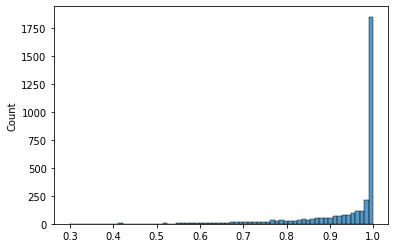

In [52]:
import seaborn as sns
sns.histplot(score_permutation_avg)

0.8814620980217899 0.6078544614496102


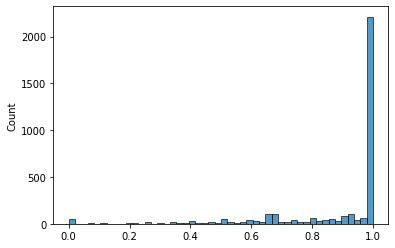

In [50]:
import seaborn as sns
sns.histplot(permutation_correctness_ratio)
permutation_correctness_ratio = np.array(permutation_correctness_ratio)
print(np.mean(permutation_correctness_ratio[~np.isnan(permutation_correctness_ratio)]), sum(permutation_correctness_ratio==1)/len(permutation_correctness_ratio))

In [47]:
permutation_correctness[18]

[]

In [41]:
np.mean(permutation_correctness[i])

0.873015873015873

In [34]:
for i in score_init:
    print(score_init[i], init_correctness[i], num_permutations[i], init_permutation[i])
    for score, correct in zip(score_permutation[i], permutation_correctness[i], ):
        print(score, correct)

0.9998397827148438 True 15 [0, 1, 2, 3, 4, 5]
0.9998408555984497 True
0.9998300075531006 True
0.9998401403427124 True
0.9998437166213989 True
0.9998289346694946 True
0.9998310804367065 True
0.9998443126678467 True
0.9998371601104736 True
0.999847412109375 True
0.9998385906219482 True
0.9998388290405273 True
0.9998251795768738 True
0.9998200535774231 True
0.9998272061347961 True
0.9998300075531006 True


In [36]:
for i in range(10):
    print(i, score_init[i], init_correctness[i], num_permutations[i], init_permutation[i])
    print(np.mean(score_permutation[i]), np.mean(permutation_correctness[i]))

0 0.9998397827148438 True 15 [0, 1, 2, 3, 4, 5]
0.9998348991076151 1.0
1 0.9995976090431213 True 15 [1, 0, 2, 3, 4, 5]
0.9996114333470663 1.0
2 0.999115526676178 True 2 [1, 0, 2]
0.9991608262062073 1.0
3 0.9965730905532837 True 63 [1, 2, 3, 4, 5, 6, 7, 0]
0.9962718657084874 1.0
4 0.9998373985290527 True 63 [0, 1, 2, 3, 4, 5, 6, 7]
0.9998213913705614 1.0
5 0.9994794726371765 True 63 [1, 2, 0, 3, 4, 5, 6, 7]
0.9994508624076843 1.0
6 0.9974454641342163 True 63 [1, 2, 3, 4, 5, 0, 6, 7]
0.9942260819768148 1.0
7 0.9841338396072388 True 63 [1, 2, 3, 4, 5, 6, 0, 7]
0.9567946072608705 1.0
8 0.43239864706993103 False 3 [1, 2, 3, 0]
0.5922626058260599 1.0
9 0.9992141723632812 True 15 [1, 0, 2, 3, 4, 5]
0.9992281198501587 1.0


In [37]:
permutation_correctness[8]

[True, True, True]

In [95]:
labels_valid = []
for batch_idx, batch in enumerate(valid_dataloader_iter):
    labels_valid.append(batch["label"].cpu())
labels_valid = torch.tensor(labels_valid)

<Axes: ylabel='Count'>

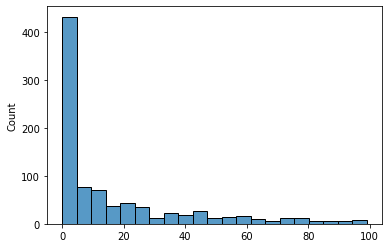

In [96]:
sns.histplot(labels_valid.numpy())

In [103]:
for batch_idx, batch in enumerate(valid_dataloader_iter):
    break

In [104]:
batch["target_col_mask"].T.shape

torch.Size([1, 439])

In [23]:
# brute force perumate in validation TODO: restrict mamimus length of permutation
import itertools

def is_sublist(A, B):
    it = iter(B)
    return all(x in it for x in A)
def get_permutation(x):
    new = []
    x = x.tolist()
    if len(x) == 1:
        x = x[0]
    for k in x:
        if k not in new:
            new.append(k)
    return new

import torch.nn.functional as F
veri_data = defaultdict(list)
veri_logits = defaultdict(list)
veri_cls_indexes = defaultdict(list)
veri_target_col_mask = defaultdict(list)
veri_embs = defaultdict(list)
veri_col_num = defaultdict(list)
veri_label = defaultdict(list)
veri_class = defaultdict(list)
    
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
change_log = []
score_init = []
score_best = [] 
for threshold in [1.5]:
    print(f"*********************Threshold: {threshold}****************************")
    ft_embs_test = []
    labels_test = []
    logits_test = []
    log = defaultdict(list)
    num_cols = []
    corrected = 0
    total_mistakes = 0
    num_permutations = {}
    init_permutation = {}
    init_correctness = {}
    score_init = {}
    score_permutation = defaultdict(list)
    permutation_correctness = defaultdict(list)
    with torch.no_grad():
        for batch_idx, batch in enumerate(valid_dataloader_iter):
            cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
            target_col_mask = batch["target_col_mask"].T
            logits = model(batch["data"].T, cls_indexes=cls_indexes,)
            label_i = batch["label"].item()
            predict_init = logits.argmax().item()
            init_permutation_i = get_permutation(target_col_mask)
            init_permutation[batch_idx] = deepcopy(init_permutation_i)
            len_init = len(init_permutation_i)
            if predict_init == label_i:
                init_correctness[batch_idx] = True
            else:
                init_correctness[batch_idx] = False
            num_permutations[batch_idx] = 0

            num_cols.append(len(init_permutation_i))
            labels_test.append(batch["label"].cpu().item())
            col_idx_set = target_col_mask.unique().tolist()

            init_permutation_i.remove(0)
            assert -1 not in col_idx_set
            for r in range(len_init-1, max(len_init//2, len_init-3), -1): # not 
                for subset in itertools.combinations(init_permutation_i, r):
                    for pos in range(len_init):
                        x = init_permutation_i[:pos] + [0] + init_permutation_i[pos:]
                        num_permutations[batch_idx] += 1
                        new_batch_data = []
                        for col_i in x:
                            if col_i == 0:
                                if len(new_batch_data) == 0:
                                    cls_indexes_value = 0
                                else:
                                    cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                            new_batch_data.append(batch["data"].T[target_col_mask==col_i])
                        new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
                        cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
                        logits_temp, embs_temp = model(new_batch_data, cls_indexes=cls_indexes, get_enc=True)
                        predict_temp = logits_temp.argmax().item()
                        permutation_correctness[batch_idx].append(predict_temp == label_i)
                        
                        veri_data[batch_idx].append(new_batch_data.cpu())
                        veri_logits[batch_idx].append(logits_temp.detach().cpu())
                        veri_cls_indexes[batch_idx].append(cls_indexes_value)
                        veri_embs[batch_idx].append(embs_temp.cpu())
                        veri_col_num[batch_idx].append(len(x))
                        veri_label[batch_idx].append(torch.tensor(predict_temp == label_i).long()) # indicate whether the permutation is correct or not
                        veri_class[batch_idx].append(label_i)

*********************Threshold: 1.5****************************


In [52]:
corrected = []
permutation_correctness_false = []
permutation_correctness_false_ratio = []
permutation_correctness_true = []
permutation_correctness_true_ratio = []
false_idx = []
for idx, corr in init_correctness.items():
    if not corr:
        permutation_correctness_false.extend(permutation_correctness[idx])
        permutation_correctness_false_ratio.append(np.mean(permutation_correctness[idx]))
        false_idx.append(idx)
    else:
        permutation_correctness_true.extend(permutation_correctness[idx][1:])
        permutation_correctness_true_ratio.append(np.mean(permutation_correctness[idx][1:]))

/home/zhihao/jupyterprojects/jupyter/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/zhihao/jupyterprojects/jupyter/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [48]:
permutation_correctness_false_ratio

[0.0]

In [42]:
permutation_correctness_false = np.array(permutation_correctness_false).reshape(-1)
permutation_correctness_false_ratio = np.array(permutation_correctness_false_ratio).reshape(-1)

In [40]:
sum([init_correctness[i] for i in init_correctness])

487

In [33]:
len(permutation_correctness_false)

64

In [54]:
sum(np.array(permutation_correctness_false_ratio)>0)/len(permutation_correctness_false_ratio)

0.24623115577889448

In [20]:
init_permutation[batch_idx]

[1, 2, 3, 4, 5, 6, 7]

In [18]:
init_permutation_i.remove(0)

In [21]:
init_permutation_i

[1, 2, 3, 4, 5, 6, 7]

In [22]:
for pos in range(len(init_permutation_i)+1):
    print(init_permutation_i[:pos] + [0] + init_permutation_i[pos:])

[0, 1, 2, 3, 4, 5, 6, 7]
[1, 0, 2, 3, 4, 5, 6, 7]
[1, 2, 0, 3, 4, 5, 6, 7]
[1, 2, 3, 0, 4, 5, 6, 7]
[1, 2, 3, 4, 0, 5, 6, 7]
[1, 2, 3, 4, 5, 0, 6, 7]
[1, 2, 3, 4, 5, 6, 0, 7]
[1, 2, 3, 4, 5, 6, 7, 0]


In [1]:
veri_class

NameError: name 'veri_class' is not defined

In [141]:
# brute force perumate in validation TODO: restrict mamimus length of permutation
import itertools
import torch.nn.functional as F

    
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
change_log = []
score_init = []
score_best = [] 
for threshold in [1.5]:
    print(f"*********************Threshold: {threshold}****************************")
    ft_embs_test = []
    labels_test = []
    logits_test = []
    log = defaultdict(list)
    num_cols = []
    corrected = 0
    total_mistakes = 0
    num_permutations = {}
    init_permutation = {}
    init_correctness = {}
    score_init = {}
    score_permutation = defaultdict(list)
    permutation_correctness = defaultdict(list)
    for batch_idx, batch in enumerate(valid_dataloader_iter):
        cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
        target_col_mask = batch["target_col_mask"].T
        logits = model(batch["data"].T, cls_indexes=cls_indexes,)
        score_init[batch_idx] = F.softmax(logits.detach()).max().item()
        label_i = batch["label"].item()
        predict_init = logits.argmax().item()
        init_permutation_i = get_permutation(target_col_mask)
        init_permutation[batch_idx] = init_permutation_i
        if predict_init == label_i:
            init_correctness[batch_idx] = True
        else:
            init_correctness[batch_idx] = False
        num_permutations[batch_idx] = 0
        if 1 in target_col_mask:
            col_idx_set = target_col_mask.unique().tolist()
            assert -1 not in col_idx_set
            for r in range(len(init_permutation_i), max(len(init_permutation_i)//2, len(init_permutation_i)-2), -1): # not 
                for subset in itertools.combinations(init_permutation_i, r):
                    if 0 not in subset and r != 1:
                        continue
                    for x in itertools.permutations(subset):
                        num_permutations[batch_idx] += 1
                        new_batch_data = []
                        for col_i in x:
                            if col_i == 0:
                                if len(new_batch_data) == 0:
                                    cls_indexes_value = 0
                                else:
                                    cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                            new_batch_data.append(batch["data"].T[target_col_mask==col_i])
                        new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
                        cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
                        logits_temp = model(new_batch_data, cls_indexes=cls_indexes,)
                        ood_score_temp = F.softmax(logits_temp.detach()).max().item()
                        score_permutation[batch_idx].append(ood_score_temp)
                        predict_temp = logits_temp.argmax().item()
                        permutation_correctness[batch_idx].append(predict_temp == label_i)

*********************Threshold: 1.5****************************


/tmp/ipykernel_3640352/3930690298.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  score_init[batch_idx] = F.softmax(logits.detach()).max().item()
/tmp/ipykernel_3640352/3930690298.py:61: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ood_score_temp = F.softmax(logits_temp.detach()).max().item()


KeyboardInterrupt: 

In [55]:
# brute force perumate in validation TODO: restrict mamimus length of permutation
import itertools
import torch.nn.functional as F

    
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
change_log = []
score_init = []
score_best = [] 
for threshold in [1.5]:
    print(f"*********************Threshold: {threshold}****************************")
    ft_embs_test = []
    labels_test = []
    logits_test = []
    log = defaultdict(list)
    num_cols = []
    corrected = 0
    total_mistakes = 0
    num_permutations = {}
    init_permutation = {}
    init_correctness = {}
    score_init = {}
    score_permutation = defaultdict(list)
    permutation_correctness = defaultdict(list)
    for batch_idx, batch in enumerate(valid_dataloader_iter):
        cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
        target_col_mask = batch["target_col_mask"].T
        logits = model(batch["data"].T, cls_indexes=cls_indexes,)
        score_init[batch_idx] = F.softmax(logits.detach()).max().item()
        label_i = batch["label"].item()
        predict_init = logits.argmax().item()
        init_permutation_i = get_permutation(target_col_mask)
        init_permutation[batch_idx] = init_permutation_i
        if predict_init == label_i:
            init_correctness[batch_idx] = True
        else:
            init_correctness[batch_idx] = False
        num_permutations[batch_idx] = 0
        if 1 in target_col_mask:
            col_idx_set = target_col_mask.unique().tolist()
            assert -1 not in col_idx_set
            for r in range(len(init_permutation_i), max(len(init_permutation_i)//2, len(init_permutation_i)-3), -1): # not 
                for x in itertools.combinations(init_permutation_i, r):
                    if 0 not in x:
                        continue

                    num_permutations[batch_idx] += 1
                    new_batch_data = []
                    for col_i in x:
                        if col_i == 0:
                            if len(new_batch_data) == 0:
                                cls_indexes_value = 0
                            else:
                                cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                        new_batch_data.append(batch["data"].T[target_col_mask==col_i])
                    new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
                    cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
                    logits_temp = model(new_batch_data, cls_indexes=cls_indexes,)
                    ood_score_temp = F.softmax(logits_temp.detach()).max().item()
                    score_permutation[batch_idx].append(ood_score_temp)
                    predict_temp = logits_temp.argmax().item()
                    permutation_correctness[batch_idx].append(predict_temp == label_i)

*********************Threshold: 1.5****************************


/tmp/ipykernel_2045046/2555221320.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  score_init[batch_idx] = F.softmax(logits.detach()).max().item()
/tmp/ipykernel_2045046/2555221320.py:61: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ood_score_temp = F.softmax(logits_temp.detach()).max().item()


In [60]:
# brute force perumate in validation TODO: restrict mamimus length of permutation
import itertools
import torch.nn.functional as F

    
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
change_log = []
score_init = []
score_best = [] 
for threshold in [1.5]:
    print(f"*********************Threshold: {threshold}****************************")
    ft_embs_test = []
    labels_test = []
    logits_test = []
    log = defaultdict(list)
    num_cols = []
    corrected = 0
    total_mistakes = 0
    num_permutations = {}
    init_permutation = {}
    init_correctness = {}
    score_init = {}
    score_permutation = defaultdict(list)
    permutation_correctness = defaultdict(list)
    for batch_idx, batch in enumerate(valid_dataloader_iter):
        cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
        target_col_mask = batch["target_col_mask"].T
        logits = model(batch["data"].T, cls_indexes=cls_indexes,)
        score_init[batch_idx] = F.softmax(logits.detach()).max().item()
        label_i = batch["label"].item()
        predict_init = logits.argmax().item()
        init_permutation_i = get_permutation(target_col_mask)
        init_permutation[batch_idx] = init_permutation_i
        if predict_init == label_i:
            init_correctness[batch_idx] = True
        else:
            init_correctness[batch_idx] = False
        num_permutations[batch_idx] = 0
        if 1 in target_col_mask:
            col_idx_set = target_col_mask.unique().tolist()
            assert -1 not in col_idx_set
            for r in range(len(init_permutation_i), 1, -1): # not 
                for x in itertools.combinations(init_permutation_i, r):
                    if 0 not in x:
                        continue

                    num_permutations[batch_idx] += 1
                    new_batch_data = []
                    for col_i in x:
                        if col_i == 0:
                            if len(new_batch_data) == 0:
                                cls_indexes_value = 0
                            else:
                                cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                        new_batch_data.append(batch["data"].T[target_col_mask==col_i])
                    new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
                    cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
                    logits_temp = model(new_batch_data, cls_indexes=cls_indexes,)
                    ood_score_temp = F.softmax(logits_temp.detach()).max().item()
                    score_permutation[batch_idx].append(ood_score_temp)
                    predict_temp = logits_temp.argmax().item()
                    permutation_correctness[batch_idx].append(predict_temp == label_i)
                if r < max(len(init_permutation_i)//2, len(init_permutation_i)-3) and sum(permutation_correctness[batch_idx]) > 0:
                    break

*********************Threshold: 1.5****************************


/tmp/ipykernel_2045046/2462308489.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  score_init[batch_idx] = F.softmax(logits.detach()).max().item()
/tmp/ipykernel_2045046/2462308489.py:61: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ood_score_temp = F.softmax(logits_temp.detach()).max().item()


In [119]:
permutation_correctness[0]

[True, True, True, True]

In [127]:
False in init_correctness

True

In [61]:
corrected = []
permutation_correctness_false = []
permutation_correctness_false_ratio = []
permutation_correctness_true = []
permutation_correctness_true_ratio = []
for idx, corr in init_correctness.items():
    if not corr:
        permutation_correctness_false.extend(permutation_correctness[idx])
        permutation_correctness_false_ratio.append(np.mean(permutation_correctness[idx]))
    else:
        permutation_correctness_true.extend(permutation_correctness[idx][1:])
        permutation_correctness_true_ratio.append(np.mean(permutation_correctness[idx][1:]))

/home/zhihao/jupyterprojects/jupyter/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/zhihao/jupyterprojects/jupyter/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [62]:
sum(np.array(permutation_correctness_false_ratio)>0)/len(permutation_correctness_false_ratio)

0.36432160804020103

In [58]:
sum(np.array(permutation_correctness_false_ratio)>0)/len(permutation_correctness_false_ratio)

0.2537688442211055

In [59]:
sum(np.array(permutation_correctness_false_ratio)>0.5)/len(permutation_correctness_false_ratio)

0.032663316582914576

In [137]:
sum(np.array(permutation_correctness_true_ratio)>0)/len(permutation_correctness_true_ratio)

0.9948364888123924

<Axes: ylabel='Count'>

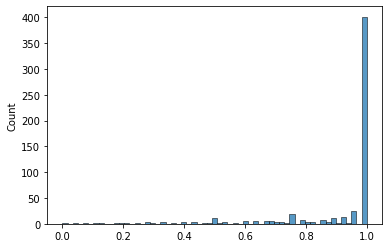

In [138]:
import seaborn as sns
sns.histplot(permutation_correctness_true_ratio)

<Axes: ylabel='Count'>

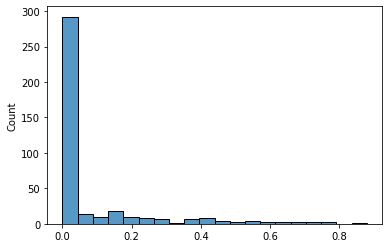

In [63]:
import seaborn as sns
sns.histplot(permutation_correctness_false_ratio, bins=20)

<Axes: ylabel='Count'>

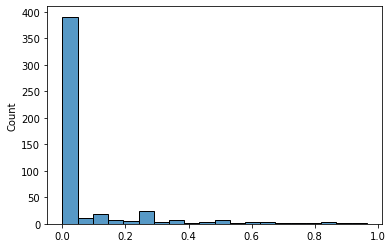

In [139]:
import seaborn as sns
sns.histplot(permutation_correctness_false_ratio, bins=20)

In [65]:
permutation_correctness_ratio = []
score_permutation_avg = []
for i in score_init:
    permutation_correctness_ratio.append(np.mean(permutation_correctness[i]))
    score_permutation_avg.append(np.mean(score_permutation[i]))

/home/zhihao/jupyterprojects/jupyter/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/zhihao/jupyterprojects/jupyter/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0.5218385215200051 0.35141242937853107 0.3107344632768362 0.6621468926553672


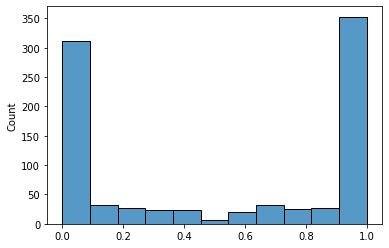

In [93]:
import seaborn as sns
sns.histplot(permutation_correctness_ratio)
permutation_correctness_ratio = np.array(permutation_correctness_ratio)
print(np.mean(permutation_correctness_ratio[~np.isnan(permutation_correctness_ratio)]), sum(permutation_correctness_ratio==1)/len(permutation_correctness_ratio), sum(permutation_correctness_ratio==0)/len(permutation_correctness_ratio), (sum(permutation_correctness_ratio==0)+sum(permutation_correctness_ratio==1))/len(permutation_correctness_ratio))


0.5166656624814163 0.3344632768361582 0.2858757062146893 0.6203389830508474


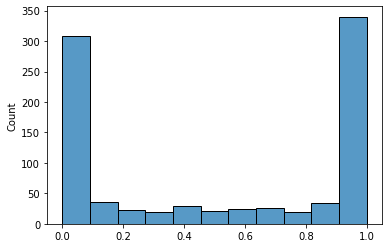

In [66]:
import seaborn as sns
sns.histplot(permutation_correctness_ratio)
permutation_correctness_ratio = np.array(permutation_correctness_ratio)
print(np.mean(permutation_correctness_ratio[~np.isnan(permutation_correctness_ratio)]), sum(permutation_correctness_ratio==1)/len(permutation_correctness_ratio), sum(permutation_correctness_ratio==0)/len(permutation_correctness_ratio), (sum(permutation_correctness_ratio==0)+sum(permutation_correctness_ratio==1))/len(permutation_correctness_ratio))

<Axes: ylabel='Count'>

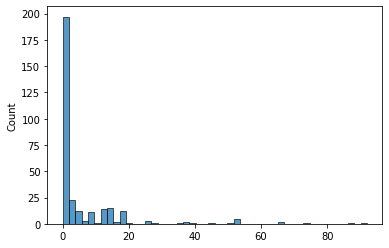

In [97]:
sns.histplot(labels_valid[permutation_correctness_ratio==1])

<Axes: ylabel='Count'>

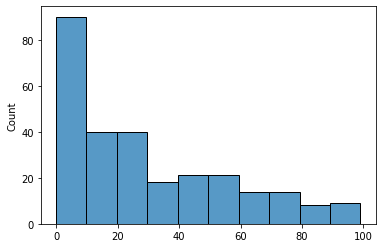

In [98]:
sns.histplot(labels_valid[permutation_correctness_ratio==0])

<Axes: ylabel='Count'>

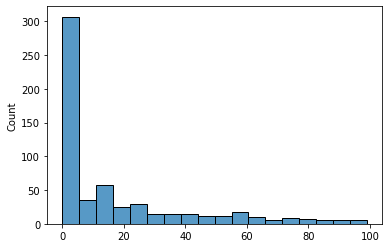

In [99]:
sns.histplot(labels_valid[(permutation_correctness_ratio==1)|(permutation_correctness_ratio==0)])

In [81]:
permutation_correctness_ratio.shape

(885,)

In [90]:
score_init = torch.tensor(list(score_init.values()))
score_init.mean()

tensor(0.8309)

In [91]:
permutation_correctness_ratio = torch.tensor(permutation_correctness_ratio)
print(score_init[permutation_correctness_ratio==1].mean())
False in torch.tensor(list(init_correctness.values()))[permutation_correctness_ratio==1]

tensor(0.9881)


/tmp/ipykernel_3888413/2131006282.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  permutation_correctness_ratio = torch.tensor(permutation_correctness_ratio)


False

In [92]:
print(score_init[permutation_correctness_ratio==0].mean())
True in torch.tensor(list(init_correctness.values()))[permutation_correctness_ratio==0]

tensor(0.7196)


False

<Axes: ylabel='Count'>

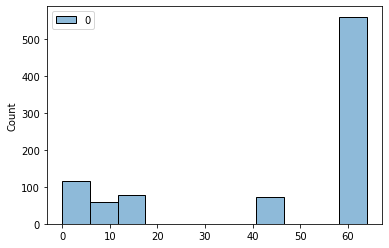

In [68]:
num_permutations_all = num_permutations.values()
sns.histplot(num_permutations_all)

In [71]:
num_permutations.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,

In [73]:
for i in range(10):
    print(num_permutations[i], len(init_permutation[i]))



64 8
64 8
64 8
64 8
4 4
11 5
3 3
64 8
64 8
64 8


In [76]:
num_correct_permutations = [sum(permutation_correctness[i]) for i in permutation_correctness]
num_wrong_permutations = [len(permutation_correctness[i])-sum(permutation_correctness[i]) for i in permutation_correctness]

11.0
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 24, 25, 26, 27, 28, 29, 31, 32, 34, 35, 37, 38, 39,
        40, 41, 42, 43, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58,
        59, 60, 61, 62, 63, 64])


<Axes: ylabel='Count'>

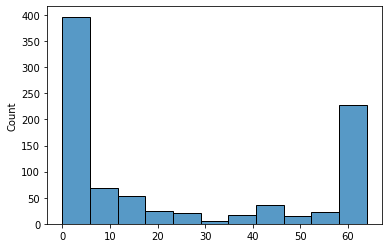

In [102]:
print(np.median(num_correct_permutations))
print(torch.tensor(num_correct_permutations).unique())
sns.histplot(num_correct_permutations )

6.0


<Axes: ylabel='Count'>

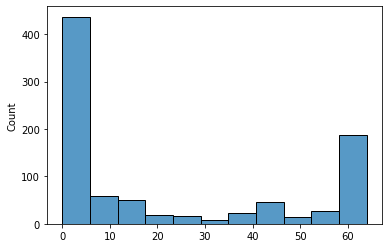

In [80]:
print(np.median(num_wrong_permutations))
sns.histplot(num_wrong_permutations )

In [101]:
torch.tensor(num_wrong_permutations).unique()

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 21, 22, 23, 24, 25, 26, 27, 29, 30, 32, 33, 34, 35, 37, 38, 39,
        40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57,
        58, 59, 60, 61, 62, 63, 64])

In [9]:
for batch_idx, batch in enumerate(valid_dataloader_iter):
    break

In [13]:
            veri_data[batch_idx].append(new_batch_data.cpu())
            veri_label[batch_idx].append(torch.tensor(predict_temp == label_i).long())
            veri_cls_indexes[batch_idx].append(cls_indexes_value)
            veri_embs[batch_idx].append(embs_temp.cpu())

In [14]:
veri_embs[batch_idx]

[tensor([-8.5623e-01,  7.9049e-02,  3.8569e-01, -6.6407e-01, -1.1610e-01,
          1.2273e-02,  4.6107e-02, -1.1365e-01, -8.2460e-01, -2.5970e-01,
          9.7081e-01,  8.7536e-01,  6.9931e-01, -3.7064e-01,  1.5717e-01,
         -9.5941e-01, -3.9030e-01, -3.4365e-01, -5.4322e-01, -7.6414e-01,
         -3.5498e-01,  5.3573e-01, -7.5528e-03,  8.9907e-01,  9.6517e-01,
          7.3408e-01, -4.5198e-01,  8.5908e-01, -4.4580e-01,  2.2950e-01,
          2.9253e-01, -8.5116e-01, -7.7495e-01, -1.1472e-01,  8.1374e-01,
          7.2535e-01,  9.1710e-01,  1.3555e-02,  4.6910e-01,  4.4896e-01,
          3.5230e-01,  8.2012e-02,  5.3267e-01,  3.2740e-01, -7.5726e-01,
          7.6358e-01, -8.2322e-01, -1.7131e-01, -6.4406e-02,  6.8759e-01,
         -1.0792e-01,  3.8933e-01, -7.8018e-01,  3.1049e-02, -7.4943e-01,
         -7.5538e-01, -5.2140e-01, -4.5425e-01, -8.4437e-01, -7.2915e-01,
         -9.2840e-01, -2.2128e-01,  9.5900e-03,  1.9464e-01,  5.9089e-01,
         -3.3018e-01,  6.4489e-01,  4.

In [12]:
if 1 in target_col_mask:
    col_idx_set = target_col_mask.unique().tolist()
    assert -1 not in col_idx_set
    for r in range(len(init_permutation_i), max(len(init_permutation_i)//2, len(init_permutation_i)-3), -1): # not 
        for x in itertools.combinations(init_permutation_i, r):
            if 0 not in x:
                continue

            num_permutations[batch_idx] += 1
            new_batch_data = []
            for col_i in x:
                if col_i == 0:
                    if len(new_batch_data) == 0:
                        cls_indexes_value = 0
                    else:
                        cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                new_batch_data.append(batch["data"].T[target_col_mask==col_i])
            new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
            cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
            logits_temp, embs_temp = model(new_batch_data, cls_indexes=cls_indexes, get_enc=True)
            logits_temp = logits_temp.detach().cpu()
            ood_score_temp = F.softmax(logits_temp.detach()).max().item()
            score_permutation[batch_idx].append(ood_score_temp)
            predict_temp = logits_temp.argmax().item()
            permutation_correctness[batch_idx].append(predict_temp == label_i)
            
            # veri_data[batch_idx].append(new_batch_data.cpu())
            # veri_label[batch_idx].append(torch.tensor(predict_temp == label_i).long())
            # veri_cls_indexes[batch_idx].append(cls_indexes_value)
            # veri_embs[batch_idx].append(embs_temp.cpu())

/tmp/ipykernel_1072582/2035222989.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ood_score_temp = F.softmax(logits_temp.detach()).max().item()


In [1]:
num_cols

NameError: name 'num_cols' is not defined

In [31]:
# brute force perumate in validation TODO: restrict mamimus length of permutation
import itertools

def is_sublist(A, B):
    it = iter(B)
    return all(x in it for x in A)
def get_permutation(x):
    new = []
    x = x.tolist()
    if len(x) == 1:
        x = x[0]
    for k in x:
        if k not in new:
            new.append(k)
    return new

import torch.nn.functional as F
veri_data = defaultdict(list)
veri_logits = defaultdict(list)
veri_cls_indexes = defaultdict(list)
veri_target_col_mask = defaultdict(list)
veri_embs = defaultdict(list)
veri_target_embs = defaultdict(list)
veri_col_num = defaultdict(list)
veri_label = defaultdict(list)
veri_class = defaultdict(list)
    
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
change_log = []
score_init = []
score_best = [] 
for threshold in [1.5]:
    print(f"*********************Threshold: {threshold}****************************")
    ft_embs_test = []
    labels_test = []
    logits_test = []
    log = defaultdict(list)
    num_cols = []
    corrected = 0
    total_mistakes = 0
    num_permutations = {}
    init_permutation = {}
    init_correctness = {}
    score_init = {}
    score_permutation = defaultdict(list)
    permutation_correctness = defaultdict(list)
    with torch.no_grad():
        for batch_idx, batch in enumerate(valid_dataloader_iter):
            cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
            target_col_mask = batch["target_col_mask"].T
            logits = model(batch["data"].T, cls_indexes=cls_indexes,)
            score_init[batch_idx] = F.softmax(logits.detach()).max().item()
            label_i = batch["label"].item()
            predict_init = logits.argmax().item()
            init_permutation_i = get_permutation(target_col_mask)
            init_permutation[batch_idx] = init_permutation_i
            if predict_init == label_i:
                init_correctness[batch_idx] = True
            else:
                init_correctness[batch_idx] = False
            num_permutations[batch_idx] = 0
            
            x = [0]
            new_batch_data = []
            for col_i in x:
                if col_i == 0:
                    if len(new_batch_data) == 0:
                        cls_indexes_value = 0
                    else:
                        cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                new_batch_data.append(batch["data"].T[target_col_mask==col_i])
            new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
            cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
            logits_temp, embs_temp = model(new_batch_data, cls_indexes=cls_indexes, get_enc=True)
            veri_target_embs[batch_idx].append(embs_temp.cpu())


            num_cols.append(len(init_permutation_i))
            labels_test.append(batch["label"].cpu().item())
            col_idx_set = target_col_mask.unique().tolist()
            assert -1 not in col_idx_set
            for r in range(len(init_permutation_i), 1, -1): # not 
                for x in itertools.combinations(init_permutation_i, r):
                    if 0 not in x:
                        continue

                    num_permutations[batch_idx] += 1
                    new_batch_data = []
                    for col_i in x:
                        if col_i == 0:
                            if len(new_batch_data) == 0:
                                cls_indexes_value = 0
                            else:
                                cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                        new_batch_data.append(batch["data"].T[target_col_mask==col_i])
                    new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
                    cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
                    logits_temp, embs_temp = model(new_batch_data, cls_indexes=cls_indexes, get_enc=True)
                    ood_score_temp = F.softmax(logits_temp.detach()).max().item()
                    score_permutation[batch_idx].append(ood_score_temp)
                    predict_temp = logits_temp.argmax().item()
                    permutation_correctness[batch_idx].append(predict_temp == label_i)
                    # v3: add more neg examples
                    if predict_temp == label_i and len(x) < max(len(init_permutation_i)//2, len(init_permutation_i)-2):
                        continue
                    
                    veri_data[batch_idx].append(new_batch_data.cpu())
                    veri_logits[batch_idx].append(logits_temp.detach().cpu())
                    veri_cls_indexes[batch_idx].append(cls_indexes_value)
                    veri_embs[batch_idx].append(embs_temp.cpu())
                    veri_col_num[batch_idx].append(len(x))
                    veri_label[batch_idx].append(torch.tensor(predict_temp == label_i).long()) # indicate whether the permutation is correct or not
                    veri_class[batch_idx].append(label_i)

*********************Threshold: 1.5****************************


/tmp/ipykernel_1200793/482508439.py:54: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  score_init[batch_idx] = F.softmax(logits.detach()).max().item()
/tmp/ipykernel_1200793/482508439.py:101: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ood_score_temp = F.softmax(logits_temp.detach()).max().item()


In [55]:
# brute force perumate in validation TODO: restrict mamimus length of permutation
import itertools

def is_sublist(A, B):
    it = iter(B)
    return all(x in it for x in A)
def get_permutation(x):
    new = []
    x = x.tolist()
    if len(x) == 1:
        x = x[0]
    for k in x:
        if k not in new:
            new.append(k)
    return new

import torch.nn.functional as F
veri_data = defaultdict(list)
veri_logits = defaultdict(list)
veri_cls_indexes = defaultdict(list)
veri_target_col_mask = defaultdict(list)
veri_embs = defaultdict(list)
veri_target_embs = defaultdict(list)
veri_col_num = defaultdict(list)
veri_label = defaultdict(list)
veri_class = defaultdict(list)
    
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
change_log = []
score_init = []
score_best = [] 
max_col_length = 3
for threshold in [1.5]:
    print(f"*********************Threshold: {threshold}****************************")
    ft_embs_test = []
    labels_test = []
    logits_test = []
    log = defaultdict(list)
    num_cols = []
    corrected = 0
    total_mistakes = 0
    num_permutations = {}
    init_permutation = {}
    init_correctness = {}
    score_init = {}
    score_permutation = defaultdict(list)
    permutation_correctness = defaultdict(list)
    with torch.no_grad():
        for batch_idx, batch in enumerate(valid_dataloader_iter):
            cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
            target_col_mask = batch["target_col_mask"].T
            logits = model(batch["data"].T, cls_indexes=cls_indexes,)
            score_init[batch_idx] = F.softmax(logits.detach()).max().item()
            label_i = batch["label"].item()
            predict_init = logits.argmax().item()
            init_permutation_i = get_permutation(target_col_mask)
            init_permutation[batch_idx] = init_permutation_i
            if predict_init == label_i:
                init_correctness[batch_idx] = True
            else:
                init_correctness[batch_idx] = False
            num_permutations[batch_idx] = 0
            
            x = [0]
            new_batch_data = []
            for col_i in x:
                if col_i == 0:
                    if len(new_batch_data) == 0:
                        cls_indexes_value = 0
                    else:
                        cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                new_batch_data.append(batch["data"].T[target_col_mask==col_i])
            new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
            cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
            logits_temp, embs_temp = model(new_batch_data, cls_indexes=cls_indexes, get_enc=True)
            veri_target_embs[batch_idx].append(embs_temp.cpu())


            num_cols.append(len(init_permutation_i))
            labels_test.append(batch["label"].cpu().item())
            col_idx_set = target_col_mask.unique().tolist()
            assert -1 not in col_idx_set
            for r in range(1, min(len(col_idx_set), max_col_length) + 1):
                for subset in itertools.combinations(col_idx_set, r):
                    if 0 not in subset:
                        continue
                    for x in itertools.permutations(subset):
                        num_permutations[batch_idx] += 1
                        new_batch_data = []
                        for col_i in x:
                            if col_i == 0:
                                if len(new_batch_data) == 0:
                                    cls_indexes_value = 0
                                else:
                                    cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                            new_batch_data.append(batch["data"].T[target_col_mask==col_i])
                        new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
                        cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
                        logits_temp, embs_temp = model(new_batch_data, cls_indexes=cls_indexes, get_enc=True)
                        ood_score_temp = F.softmax(logits_temp.detach()).max().item()
                        score_permutation[batch_idx].append(ood_score_temp)
                        predict_temp = logits_temp.argmax().item()
                        permutation_correctness[batch_idx].append(predict_temp == label_i)
                        
                        veri_data[batch_idx].append(new_batch_data.cpu())
                        veri_logits[batch_idx].append(logits_temp.detach().cpu())
                        veri_cls_indexes[batch_idx].append(cls_indexes_value)
                        veri_embs[batch_idx].append(embs_temp.cpu())
                        veri_col_num[batch_idx].append(len(x))
                        veri_label[batch_idx].append(torch.tensor(predict_temp == label_i).long()) # indicate whether the permutation is correct or not
                        veri_class[batch_idx].append(label_i)

*********************Threshold: 1.5****************************


/tmp/ipykernel_1200793/2998815280.py:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  score_init[batch_idx] = F.softmax(logits.detach()).max().item()
/tmp/ipykernel_1200793/2998815280.py:102: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ood_score_temp = F.softmax(logits_temp.detach()).max().item()


In [57]:
# V7
veri_labels_all = torch.cat([torch.tensor(veri_label[i]) for i in veri_label], dim=0)
print(len(veri_labels_all))
print(veri_labels_all.sum()/len(veri_labels_all))

96763
tensor(0.4410)


In [65]:
import os
os.makedirs("/data/zhihao/TU/Watchog/verification", exist_ok=True)
# {args.task}_veri_data: min length: max(len(init_permutation_i)//2, len(init_permutation_i)-3)
# {args.task}_veri_data_1: min length: for those without correct permutation, 
torch.save({"data": veri_data, "label": veri_label, "logits": veri_logits, "cls_indexes": veri_cls_indexes, "embs": veri_embs, "target_embs":veri_target_embs,  "col_num": veri_col_num}, f"/data/zhihao/TU/Watchog/verification/{args.task}_veri_data_8.pth")

In [52]:
# V4
veri_labels_all = torch.cat([torch.tensor(train_label[i]) for i in train_label], dim=0)
print(len(veri_labels_all))
print(veri_labels_all.sum()/len(veri_labels_all))

122702
tensor(0.5972)


In [74]:
import os
# os.makedirs("/data/zhihao/TU/Watchog/trainfication", exist_ok=True)
train_results = torch.load( f"/data/zhihao/TU/Watchog/trainfication/{args.task}_train_data_8.pth")
train_data = train_results["data"]
train_label = train_results["label"]
train_logits = train_results["logits"]
train_cls_indexes = train_results["cls_indexes"]
train_embs = train_results["embs"]
train_target_embs = train_results["target_embs"]
train_col_num = train_results["col_num"]

/tmp/ipykernel_1200793/3512779604.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_results = torch.load( f"/data/zhihao/TU/Watchog/trainfication/{args.task}_train_d

In [75]:
veri_labels_all = torch.cat([torch.tensor(train_label[i]) for i in train_label], dim=0)
print(len(veri_labels_all))
print(veri_labels_all.sum()/len(veri_labels_all))

383924
tensor(0.6839)


In [76]:
import os
# os.makedirs("/data/zhihao/TU/Watchog/trainfication", exist_ok=True)
valid_results = torch.load( f"/data/zhihao/TU/Watchog/verification/{args.task}_veri_data_5.pth")
veri_data = valid_results["data"]
veri_label = valid_results["label"]
veri_logits = valid_results["logits"]
veri_cls_indexes = valid_results["cls_indexes"]
veri_embs = valid_results["embs"]
veri_target_embs = valid_results["target_embs"]
veri_col_num = valid_results["col_num"]

/tmp/ipykernel_1200793/757288286.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  valid_results = torch.load( f"/data/zhihao/TU/Watchog/verification/{args.task}_veri_data

In [77]:
veri_labels_all = torch.cat([torch.tensor(veri_label[i]) for i in veri_label], dim=0)
print(len(veri_labels_all))
print(veri_labels_all.sum()/len(veri_labels_all))

172055
tensor(0.4884)


In [78]:
num_train = len(train_data)
for i in veri_data:
    train_data[num_train+i] = veri_data[i]
    train_label[num_train+i] = veri_label[i]
    train_logits[num_train+i] = veri_logits[i]
    train_cls_indexes[num_train+i] = veri_cls_indexes[i]
    train_embs[num_train+i] = veri_embs[i]
    train_target_embs[num_train+i] = veri_target_embs[i]
    train_col_num[num_train+i] = veri_col_num[i]

In [72]:
# V9
veri_labels_all = torch.cat([torch.tensor(train_label[i]) for i in train_label], dim=0)
print(len(veri_labels_all))
print(veri_labels_all.sum()/len(veri_labels_all))

296800
tensor(0.2946)


In [79]:
# V10
veri_labels_all = torch.cat([torch.tensor(train_label[i]) for i in train_label], dim=0)
print(len(veri_labels_all))
print(veri_labels_all.sum()/len(veri_labels_all))

555979
tensor(0.6234)


In [80]:
import os
os.makedirs("/data/zhihao/TU/Watchog/verification", exist_ok=True)
torch.save({"data": train_data, "label": train_label, "logits": train_logits, "cls_indexes": train_cls_indexes, "embs": train_embs, "target_embs":train_target_embs , "col_num": train_col_num}, f"/data/zhihao/TU/Watchog/verification/{args.task}_veri_data_10.pth")

In [62]:
# V7
veri_labels_all = torch.cat([torch.tensor(train_label[i]) for i in train_label], dim=0)
print(len(veri_labels_all))
print(veri_labels_all.sum()/len(veri_labels_all))

124745
tensor(0.0273)


In [64]:
# V7 + veri
veri_labels_all = torch.cat([torch.tensor(train_label[i]) for i in train_label], dim=0)
print(len(veri_labels_all))
print(veri_labels_all.sum()/len(veri_labels_all))

221508
tensor(0.2080)


In [ ]:
train_data

In [37]:
veri_data.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

In [ ]:
import os
os.makedirs("/data/zhihao/TU/Watchog/verification", exist_ok=True)
# {args.task}_veri_data: min length: max(len(init_permutation_i)//2, len(init_permutation_i)-3)
# {args.task}_veri_data_1: min length: for those without correct permutation, 
torch.save({"data": veri_data, "label": veri_label, "logits": veri_logits, "cls_indexes": veri_cls_indexes, "embs": veri_embs, "target_embs":veri_target_embs,  "col_num": veri_col_num}, f"/data/zhihao/TU/Watchog/verification/{args.task}_veri_data_3.pth")

In [39]:
len(train_data)

4346

In [49]:
import os
os.makedirs("/data/zhihao/TU/Watchog/verification", exist_ok=True)
torch.save({"data": train_data, "label": train_label, "logits": train_logits, "cls_indexes": train_cls_indexes, "embs": train_embs, "target_embs":train_target_embs , "col_num": train_col_num}, f"/data/zhihao/TU/Watchog/verification/{args.task}_veri_data_4.pth")

In [48]:
 f"/data/zhihao/TU/Watchog/trainfication/{args.task}_veri_data_4.pth"

'/data/zhihao/TU/Watchog/trainfication/gt-semtab22-dbpedia-all0_veri_data_4.pth'

In [ ]:
args.task

In [46]:
# V4
veri_labels_all = torch.cat([torch.tensor(train_label[i]) for i in train_label], dim=0)
print(len(veri_labels_all))
print(veri_labels_all.sum()/len(veri_labels_all))

128489
tensor(0.6493)


In [34]:
# V3
print(len(veri_labels_all))
print(veri_labels_all.sum()/len(veri_labels_all))

49353
tensor(0.2178)


In [15]:
# V2
len(veri_labels_all)

79593

In [16]:
# V2
veri_labels_all.sum()/len(veri_labels_all)

tensor(0.5150)

In [70]:
# brute force perumate in validation TODO: restrict mamimus length of permutation
import itertools

def is_sublist(A, B):
    it = iter(B)
    return all(x in it for x in A)
def get_permutation(x):
    new = []
    x = x.tolist()
    if len(x) == 1:
        x = x[0]
    for k in x:
        if k not in new:
            new.append(k)
    return new

import torch.nn.functional as F
veri_data = defaultdict(list)
veri_logits = defaultdict(list)
veri_cls_indexes = defaultdict(list)
veri_target_col_mask = defaultdict(list)
veri_embs = defaultdict(list)
veri_target_embs = defaultdict(list)
veri_col_num = defaultdict(list)
veri_label = defaultdict(list)
veri_class = defaultdict(list)
    
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
change_log = []
score_init = []
score_best = [] 
for threshold in [1.5]:
    print(f"*********************Threshold: {threshold}****************************")
    ft_embs_test = []
    labels_test = []
    logits_test = []
    log = defaultdict(list)
    num_cols = []
    corrected = 0
    total_mistakes = 0
    num_permutations = {}
    init_permutation = {}
    init_correctness = {}
    score_init = {}
    score_permutation = defaultdict(list)
    permutation_correctness = defaultdict(list)
    with torch.no_grad():
        for batch_idx, batch in enumerate(valid_dataloader_iter):
            cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
            target_col_mask = batch["target_col_mask"].T
            logits = model(batch["data"].T, cls_indexes=cls_indexes,)
            score_init[batch_idx] = F.softmax(logits.detach()).max().item()
            label_i = batch["label"].item()
            predict_init = logits.argmax().item()
            init_permutation_i = get_permutation(target_col_mask)
            init_permutation[batch_idx] = init_permutation_i
            if predict_init == label_i:
                init_correctness[batch_idx] = True
            else:
                init_correctness[batch_idx] = False
            num_permutations[batch_idx] = 0
            
            x = [0]
            new_batch_data = []
            for col_i in x:
                if col_i == 0:
                    if len(new_batch_data) == 0:
                        cls_indexes_value = 0
                    else:
                        cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                new_batch_data.append(batch["data"].T[target_col_mask==col_i])
            new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
            cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
            logits_temp, embs_temp = model(new_batch_data, cls_indexes=cls_indexes, get_enc=True)
            veri_target_embs[batch_idx].append(embs_temp.cpu())


            num_cols.append(len(init_permutation_i))
            labels_test.append(batch["label"].cpu().item())
            col_idx_set = target_col_mask.unique().tolist()
            assert -1 not in col_idx_set
            for r in range(len(init_permutation_i), 1, -1): # not 
                for x in itertools.combinations(init_permutation_i, r):
                    if 0 not in x:
                        continue

                    num_permutations[batch_idx] += 1
                    new_batch_data = []
                    for col_i in x:
                        if col_i == 0:
                            if len(new_batch_data) == 0:
                                cls_indexes_value = 0
                            else:
                                cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                        new_batch_data.append(batch["data"].T[target_col_mask==col_i])
                    new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
                    cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
                    logits_temp, embs_temp = model(new_batch_data, cls_indexes=cls_indexes, get_enc=True)
                    ood_score_temp = F.softmax(logits_temp.detach()).max().item()
                    score_permutation[batch_idx].append(ood_score_temp)
                    predict_temp = logits_temp.argmax().item()
                    permutation_correctness[batch_idx].append(predict_temp == label_i)
                    
                    veri_data[batch_idx].append(new_batch_data.cpu())
                    veri_logits[batch_idx].append(logits_temp.detach().cpu())
                    veri_cls_indexes[batch_idx].append(cls_indexes_value)
                    veri_embs[batch_idx].append(embs_temp.cpu())
                    veri_col_num[batch_idx].append(len(x))
                    veri_label[batch_idx].append(torch.tensor(predict_temp == label_i).long()) # indicate whether the permutation is correct or not
                    veri_class[batch_idx].append(label_i)
                if r < max(len(init_permutation_i)//2, len(init_permutation_i)-3) and sum(permutation_correctness[batch_idx]) > 0:
                    break

*********************Threshold: 1.5****************************


/tmp/ipykernel_2045046/4267723283.py:54: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  score_init[batch_idx] = F.softmax(logits.detach()).max().item()
/tmp/ipykernel_2045046/4267723283.py:101: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ood_score_temp = F.softmax(logits_temp.detach()).max().item()


In [71]:
import os
os.makedirs("/data/zhihao/TU/Watchog/verification", exist_ok=True)
# {args.task}_veri_data: min length: max(len(init_permutation_i)//2, len(init_permutation_i)-3)
# {args.task}_veri_data_1: min length: for those without correct permutation, 
torch.save({"data": veri_data, "label": veri_label, "logits": veri_logits, "cls_indexes": veri_cls_indexes, "embs": veri_embs, "target_embs":veri_target_embs,  "col_num": veri_col_num}, f"/data/zhihao/TU/Watchog/verification/{args.task}_veri_data_1.pth")

In [24]:
res = torch.load(f"/data/zhihao/TU/Watchog/verification/{args.task}_veri_data_1.pth")
veri_label_1 = res["label"]

/tmp/ipykernel_1200793/2535775824.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  res = torch.load(f"/data/zhihao/TU/Watchog/verification/{args.task}_veri_data_1.pth")


In [25]:
veri_label_1_all = torch.cat([torch.tensor(veri_label_1[i]) for i in veri_label_1], dim=0)

In [26]:
len(veri_label_1_all)

67813

In [27]:
veri_label_1_all.sum()/len(veri_label_1_all)

tensor(0.4861)

In [17]:
res = torch.load(f"/data/zhihao/TU/Watchog/verification/{args.task}_veri_data.pth")
veri_label_old = res["label"]

/tmp/ipykernel_1200793/2986149398.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  res = torch.load(f"/data/zhihao/TU/Watchog/verification/{args.task}_veri_data.pth")


In [18]:
veri_label_old_all = torch.cat([torch.tensor(veri_label_old[i]) for i in veri_label_old], dim=0)

In [22]:
len(veri_label_old_all)

20130

In [23]:
veri_label_old_all.sum()/len(veri_label_old_all)

tensor(0.5288)

In [ ]:
veri_label_old[0]

In [ ]:
labels_all_old = 

<Axes: ylabel='Count'>

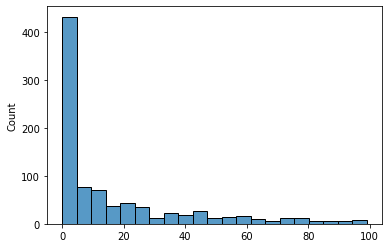

In [101]:
import seaborn as sns
labels_test = []
for batch in veri_class:
    labels_test.append(batch[0])
sns.histplot(labels_test)

In [102]:
_, test_counts = np.unique(labels_test, return_counts=True)

In [103]:
test_counts

array([207, 113,  42,  37,  33,  20,  12,  13,  12,  19,  11,  14,  19,
        11,  15,  13,   9,   3,  12,  10,   8,   9,   9,   8,   9,   7,
         5,   6,   9,   3,   4,   4,   2,   6,   5,   3,   7,   2,   5,
         3,   4,   1,   6,   8,   8,   4,   5,   1,   5,   2,   4,   2,
         5,   1,   2,   3,   4,   5,   1,   5,   2,   3,   2,   1,   4,
         4,   2,   2,   1,   1,   2,   4,   3,   2,   3,   4,   4,   1,
         3,   2,   1,   1,   1,   2,   1,   1,   1,   2,   1,   1,   1,
         2,   3,   1,   1])

In [104]:
_, veri_counts = np.unique(labels_all, return_counts=True)

In [106]:
print(max(test_counts)/min(test_counts), )
veri_counts

207.0


array([4340, 2331,  923,  818,  700,  425,  328,  306,  253,  519,  209,
        295,  393,  287,  359,  334,  120,   61,  335,  272,  219,  254,
        221,  207,  240,  183,  132,  174,  210,   87,   47,   96,   58,
        174,  125,   56,  153,   58,  138,   69,  109,   29,  117,  188,
        214,  116,  145,   16,  111,   40,   80,   32,  138,   16,   58,
         44,   85,  138,   16,  145,   32,   87,   32,   29,   90,  116,
         58,   20,   29,   29,   45,   91,   80,   58,   69,  116,  116,
         22,   67,   58,   29,   29,   29,   58,   29,   29,   29,   58,
         29,   29,   29,   32,   87,   22,   22])

<Axes: ylabel='Count'>

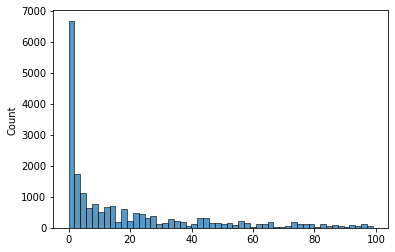

In [97]:
import seaborn as sns
labels_all = []
for batch in veri_class:
    for label in veri_class[batch]:
        labels_all.append(label)
sns.histplot(labels_all)

/home/zhihao/jupyterprojects/jupyter/lib/python3.8/site-packages/seaborn/_core.py:721: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  values = np.atleast_1d(np.asarray(data, dtype=object))


TypeError: 'NoneType' object is not iterable

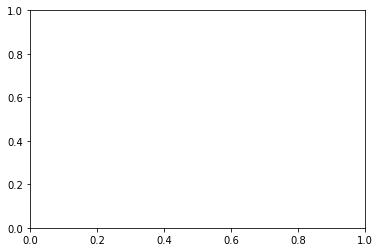

In [98]:
import seaborn as sns
sns.histplot(labels_test)

In [95]:
len(labels_all)

20130

In [16]:
embs_temp.shape

torch.Size([768])

In [13]:
 torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).shape

torch.Size([1, 2])

In [10]:
new_batch_data.shape

torch.Size([1, 378])

In [11]:
cls_indexes.shape

torch.Size([1, 2])

In [11]:
batch["data"].T.shape

torch.Size([1, 504])

In [139]:
for i in veri_data:
    assert len(veri_data[i]) == len(veri_label[i]) == len(veri_cls_indexes[i])

In [14]:
# brute force perumate in validation TODO: restrict mamimus length of permutation
import itertools

def is_sublist(A, B):
    it = iter(B)
    return all(x in it for x in A)
def get_permutation(x):
    new = []
    x = x.tolist()
    if len(x) == 1:
        x = x[0]
    for k in x:
        if k not in new:
            new.append(k)
    return new

import torch.nn.functional as F
test_data = defaultdict(list)
test_logits = defaultdict(list)
test_cls_indexes = defaultdict(list)
test_target_col_mask = defaultdict(list)
test_embs = defaultdict(list)
test_col_num = defaultdict(list)
test_label = defaultdict(list)
test_class = defaultdict(list)

    
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
change_log = []
score_init = []
score_best = [] 
for threshold in [1.5]:
    print(f"*********************Threshold: {threshold}****************************")
    ft_embs_test = []
    labels_test = []
    logits_test = []
    log = defaultdict(list)
    num_cols = []
    corrected = 0
    total_mistakes = 0
    num_permutations = {}
    init_permutation = {}
    init_correctness = {}
    score_init = {}
    score_permutation = defaultdict(list)
    permutation_correctness = defaultdict(list)
    with torch.no_grad():
        for batch_idx, batch in enumerate(test_dataloader_iter):
            cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
            target_col_mask = batch["target_col_mask"].T
            logits = model(batch["data"].T, cls_indexes=cls_indexes,)
            score_init[batch_idx] = F.softmax(logits.detach()).max().item()
            label_i = batch["label"].item()
            predict_init = logits.argmax().item()
            init_permutation_i = get_permutation(target_col_mask)
            init_permutation[batch_idx] = init_permutation_i
            if predict_init == label_i:
                init_correctness[batch_idx] = True
            else:
                init_correctness[batch_idx] = False
            num_permutations[batch_idx] = 0

            num_cols.append(len(init_permutation_i))
            labels_test.append(batch["label"].cpu())
            col_idx_set = target_col_mask.unique().tolist()
            assert -1 not in col_idx_set
            for r in range(len(init_permutation_i), max(len(init_permutation_i)//2, len(init_permutation_i)-3), -1): # not 
                for x in itertools.combinations(init_permutation_i, r):
                    if 0 not in x:
                        continue

                    num_permutations[batch_idx] += 1
                    new_batch_data = []
                    for col_i in x:
                        if col_i == 0:
                            if len(new_batch_data) == 0:
                                cls_indexes_value = 0
                            else:
                                cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                        new_batch_data.append(batch["data"].T[target_col_mask==col_i])
                    new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
                    cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
                    logits_temp, embs_temp = model(new_batch_data, cls_indexes=cls_indexes, get_enc=True)
                    ood_score_temp = F.softmax(logits_temp.detach()).max().item()
                    score_permutation[batch_idx].append(ood_score_temp)
                    predict_temp = logits_temp.argmax().item()
                    permutation_correctness[batch_idx].append(predict_temp == label_i)
                    
                    test_data[batch_idx].append(new_batch_data.cpu())
                    test_logits[batch_idx].append(logits_temp.detach().cpu())
                    test_cls_indexes[batch_idx].append(cls_indexes_value)
                    test_embs[batch_idx].append(embs_temp.cpu())
                    test_col_num[batch_idx].append(len(x))
                    test_label[batch_idx].append(torch.tensor(predict_temp == label_i).long()) # indicate whether the permutation is correct or not
                    test_class[batch_idx].append(label_i)

*********************Threshold: 1.5****************************


/tmp/ipykernel_3640352/1600745436.py:54: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  score_init[batch_idx] = F.softmax(logits.detach()).max().item()
/tmp/ipykernel_3640352/1600745436.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ood_score_temp = F.softmax(logits_temp.detach()).max().item()


In [29]:
# brute force perumate in validation TODO: restrict mamimus length of permutation
import itertools

def is_sublist(A, B):
    it = iter(B)
    return all(x in it for x in A)
def get_permutation(x):
    new = []
    x = x.tolist()
    if len(x) == 1:
        x = x[0]
    for k in x:
        if k not in new:
            new.append(k)
    return new

import torch.nn.functional as F
test_data = defaultdict(list)
test_logits = defaultdict(list)
test_cls_indexes = defaultdict(list)
test_target_col_mask = defaultdict(list)
test_embs = defaultdict(list)
test_col_num = defaultdict(list)
test_label = defaultdict(list)
test_class = defaultdict(list)

    
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
change_log = []
score_init = []
score_best = [] 
for threshold in [1.5]:
    print(f"*********************Threshold: {threshold}****************************")
    ft_embs_test = []
    labels_test = []
    logits_test = []
    log = defaultdict(list)
    num_cols = []
    corrected = 0
    total_mistakes = 0
    num_permutations = {}
    init_permutation = {}
    init_correctness = {}
    score_init = {}
    score_permutation = defaultdict(list)
    permutation_correctness = defaultdict(list)
    with torch.no_grad():
        for batch_idx, batch in enumerate(test_dataloader_iter):
            cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
            target_col_mask = batch["target_col_mask"].T
            logits = model(batch["data"].T, cls_indexes=cls_indexes,)
            score_init[batch_idx] = F.softmax(logits.detach()).max().item()
            label_i = batch["label"].item()
            predict_init = logits.argmax().item()
            init_permutation_i = get_permutation(target_col_mask)
            init_permutation[batch_idx] = init_permutation_i
            if predict_init == label_i:
                init_correctness[batch_idx] = True
            else:
                init_correctness[batch_idx] = False
            num_permutations[batch_idx] = 0

            num_cols.append(len(init_permutation_i))
            labels_test.append(batch["label"].cpu())
            col_idx_set = target_col_mask.unique().tolist()
            assert -1 not in col_idx_set
            for r in range(len(init_permutation_i), 1, -1): # not 
                for x in itertools.combinations(init_permutation_i, r):
                    if 0 not in x:
                        continue

                    num_permutations[batch_idx] += 1
                    new_batch_data = []
                    for col_i in x:
                        if col_i == 0:
                            if len(new_batch_data) == 0:
                                cls_indexes_value = 0
                            else:
                                cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                        new_batch_data.append(batch["data"].T[target_col_mask==col_i])
                    new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
                    cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
                    logits_temp, embs_temp = model(new_batch_data, cls_indexes=cls_indexes, get_enc=True)
                    ood_score_temp = F.softmax(logits_temp.detach()).max().item()
                    score_permutation[batch_idx].append(ood_score_temp)
                    predict_temp = logits_temp.argmax().item()
                    permutation_correctness[batch_idx].append(predict_temp == label_i)
                    
                    test_data[batch_idx].append(new_batch_data.cpu())
                    test_logits[batch_idx].append(logits_temp.detach().cpu())
                    test_cls_indexes[batch_idx].append(cls_indexes_value)
                    test_embs[batch_idx].append(embs_temp.cpu())
                    test_col_num[batch_idx].append(len(x))
                    test_label[batch_idx].append(torch.tensor(predict_temp == label_i).long()) # indicate whether the permutation is correct or not
                    test_class[batch_idx].append(label_i)

*********************Threshold: 1.5****************************


/tmp/ipykernel_1200793/848650604.py:54: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  score_init[batch_idx] = F.softmax(logits.detach()).max().item()
/tmp/ipykernel_1200793/848650604.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ood_score_temp = F.softmax(logits_temp.detach()).max().item()


In [59]:
# brute force perumate in validation TODO: restrict mamimus length of permutation
import itertools

def is_sublist(A, B):
    it = iter(B)
    return all(x in it for x in A)
def get_permutation(x):
    new = []
    x = x.tolist()
    if len(x) == 1:
        x = x[0]
    for k in x:
        if k not in new:
            new.append(k)
    return new

import torch.nn.functional as F
test_data = defaultdict(list)
test_logits = defaultdict(list)
test_cls_indexes = defaultdict(list)
test_target_col_mask = defaultdict(list)
test_embs = defaultdict(list)
test_col_num = defaultdict(list)
test_label = defaultdict(list)
test_class = defaultdict(list)

    
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
change_log = []
score_init = []
score_best = [] 

max_col_length = 3
for threshold in [1.5]:
    print(f"*********************Threshold: {threshold}****************************")
    ft_embs_test = []
    labels_test = []
    logits_test = []
    log = defaultdict(list)
    num_cols = []
    corrected = 0
    total_mistakes = 0
    num_permutations = {}
    init_permutation = {}
    init_correctness = {}
    score_init = {}
    score_permutation = defaultdict(list)
    permutation_correctness = defaultdict(list)
    with torch.no_grad():
        for batch_idx, batch in enumerate(test_dataloader_iter):
            cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
            target_col_mask = batch["target_col_mask"].T
            logits = model(batch["data"].T, cls_indexes=cls_indexes,)
            score_init[batch_idx] = F.softmax(logits.detach()).max().item()
            label_i = batch["label"].item()
            predict_init = logits.argmax().item()
            init_permutation_i = get_permutation(target_col_mask)
            init_permutation[batch_idx] = init_permutation_i
            if predict_init == label_i:
                init_correctness[batch_idx] = True
            else:
                init_correctness[batch_idx] = False
            num_permutations[batch_idx] = 0

            num_cols.append(len(init_permutation_i))
            labels_test.append(batch["label"].cpu())
            col_idx_set = target_col_mask.unique().tolist()
            assert -1 not in col_idx_set
            for r in range(1, min(len(col_idx_set), max_col_length) + 1):
                for subset in itertools.combinations(col_idx_set, r):
                    if 0 not in subset:
                        continue
                    for x in itertools.permutations(subset):
                        num_permutations[batch_idx] += 1
                        new_batch_data = []
                        for col_i in x:
                            if col_i == 0:
                                if len(new_batch_data) == 0:
                                    cls_indexes_value = 0
                                else:
                                    cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                            new_batch_data.append(batch["data"].T[target_col_mask==col_i])
                        new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
                        cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
                        logits_temp, embs_temp = model(new_batch_data, cls_indexes=cls_indexes, get_enc=True)
                        ood_score_temp = F.softmax(logits_temp.detach()).max().item()
                        score_permutation[batch_idx].append(ood_score_temp)
                        predict_temp = logits_temp.argmax().item()
                        permutation_correctness[batch_idx].append(predict_temp == label_i)
                        
                        test_data[batch_idx].append(new_batch_data.cpu())
                        test_logits[batch_idx].append(logits_temp.detach().cpu())
                        test_cls_indexes[batch_idx].append(cls_indexes_value)
                        test_embs[batch_idx].append(embs_temp.cpu())
                        test_col_num[batch_idx].append(len(x))
                        test_label[batch_idx].append(torch.tensor(predict_temp == label_i).long()) # indicate whether the permutation is correct or not
                        test_class[batch_idx].append(label_i)

*********************Threshold: 1.5****************************


/tmp/ipykernel_1200793/3827576329.py:56: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  score_init[batch_idx] = F.softmax(logits.detach()).max().item()
/tmp/ipykernel_1200793/3827576329.py:88: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ood_score_temp = F.softmax(logits_temp.detach()).max().item()


In [60]:
import os
os.makedirs("/data/zhihao/TU/Watchog/verification", exist_ok=True)
torch.save({"data": test_data, "logits": test_logits, "cls_indexes": test_cls_indexes, 
            "embs": test_embs, "col_num": test_col_num, "label": test_label, "class": test_class}, f"/data/zhihao/TU/Watchog/verification/{args.task}_test_data_3.pth")

In [114]:
args.task

'gt-semtab22-dbpedia-all0'

In [ ]:
test_veri = torch.load("/data/zhihao/TU/Watchog/verification/test_data.pth")
test_data = test_veri["data"]
test_logits = test_veri["logits"]
test_cls_indexes = test_veri["cls_indexes"]
test_embs = test_veri["embs"]
test_col_num = test_veri["col_num"]



In [170]:
all_labels = []
for i in veri_label:
    all_labels.extend(veri_label[i])
all_labels = torch.tensor(all_labels).reshape(-1)
all_labels.sum()/len(all_labels)

tensor(0.5288)

In [ ]:
veri_label

In [64]:
class VerificationDataset(data.Dataset):
    def __init__(
            self,
            data_path: str = "/data/zhihao/TU/Watchog/verification/veri_data.pth",
            max_list_length: int = 10,
            pos_ratio : int = 0.5, # None: only control pos_ratio to be less than 0.5
            label_padding_value: int = -1,
            data_padding_value: int = 0,
            ): 
        data_raw = torch.load(data_path)
        veri_label = data_raw["label"]
        veri_data = data_raw["data"]
        veri_cls_indexes = data_raw["cls_indexes"]
        self.label_padding_value = label_padding_value
        self.data_padding_value = data_padding_value
        self.max_list_length = max_list_length
        self.pos_ratio = pos_ratio
        self.veri_label = {}
        self.veri_data = {}
        self.veri_cls_indexes = {}
        i = 0
        for veri_i in veri_label:
            labels_i = torch.tensor(veri_label[veri_i]).reshape(-1)
            
            if 0 not in labels_i or 1 not in labels_i:
                continue
            self.veri_data[i] = veri_data[veri_i]
            self.veri_label[i] = labels_i
            self.veri_cls_indexes[i] = veri_cls_indexes[veri_i]
            i += 1
    def sample(self, labels):
        labels = labels.tolist()  # Convert tensor to list for easier manipulation
        positive_indices = [i for i, label in enumerate(labels) if label == 1]
        negative_indices = [i for i, label in enumerate(labels) if label == 0]

        # Determine how many positives we can sample, respecting the ratio requirement
        max_num_positives = max_num_negatives = min(len(positive_indices), len(negative_indices), self.max_list_length // 2)
        
        # Randomly sample the positives and negatives
        sampled_positives = random.sample(positive_indices, max_num_positives)
        sampled_negatives = random.sample(negative_indices, max_num_negatives)

        # Combine and shuffle the indices
        sampled_indices = sampled_positives + sampled_negatives

        return sampled_indices
        # {"data": veri_data, "label": veri_label, "cls_indexes": veri_cls_indexes}
    def __len__(self):
        return len(self.veri_data)

    def __getitem__(self, idx):
        labels = self.veri_label[idx]
        sampled_indices = self.sample(labels)
        sampled_labels = torch.tensor([labels[i] for i in sampled_indices]).reshape(-1)
        sampled_data = [self.veri_data[idx][i].reshape(-1) for i in sampled_indices]
        sampled_cls_indexes = torch.tensor([self.veri_cls_indexes[idx][i] for i in sampled_indices], dtype=torch.long)
        if len(sampled_indices) < self.max_list_length:
            sampled_labels = torch.cat([sampled_labels, torch.ones(self.max_list_length - len(sampled_labels))*self.label_padding_value])
            sampled_data.extend([torch.tensor([self.data_padding_value]) for _ in range(self.max_list_length - len(sampled_data))])
            sampled_cls_indexes = torch.cat([sampled_cls_indexes, torch.zeros(self.max_list_length - len(sampled_cls_indexes))])
        return {
            "data": sampled_data,
            "label": sampled_labels,
            "cls_indexes": sampled_cls_indexes, 
        }

In [64]:
class VerificationBinaryDataset(data.Dataset):
    def __init__(
            self,
            data_path: str = "/data/zhihao/TU/Watchog/verification/veri_data.pth",
            pos_ratio = None, # clone the negative samples
            ): 
        data_raw = torch.load(data_path)
        veri_label = data_raw["label"]
        veri_data = data_raw["data"]
        veri_cls_indexes = data_raw["cls_indexes"]
        veri_embs = data_raw["embs"]
        veri_logits = data_raw["logits"]
        self.neg_expand = int(1/pos_ratio)-1 if pos_ratio is not None else 1
        self.veri_label = {}
        self.veri_data = {}
        self.veri_embs = {}
        self.veri_cls_indexes = {}
        self.veri_logits = {}
        i = 0
        for veri_i in veri_label:
            for veri_j in range(len(veri_label[veri_i])):
                if veri_label[veri_i][veri_j] == 1:
                    labels_i = torch.tensor([1]).reshape(-1)
                    self.veri_data[i] = veri_data[veri_i][veri_j]
                    self.veri_label[i] = labels_i
                    self.veri_cls_indexes[i] = veri_cls_indexes[veri_i][veri_j]
                    self.veri_embs[i] = veri_embs[veri_i][veri_j]
                    self.veri_logits[i] = veri_logits[veri_i][veri_j]
                    i += 1
                else:
                    for _ in range(self.neg_expand):
                        labels_i = torch.tensor([0]).reshape(-1)
                        self.veri_data[i] = veri_data[veri_i][veri_j]
                        self.veri_label[i] = labels_i
                        self.veri_cls_indexes[i] = veri_cls_indexes[veri_i][veri_j]
                        self.veri_embs[i] = veri_embs[veri_i][veri_j]
                        self.veri_logits[i] = veri_logits[veri_i][veri_j]
                        i += 1

    def __len__(self):
        return len(self.veri_data)

    def __getitem__(self, idx):
        return {
            # "data": self.veri_data[idx].reshape(-1),
            "embs": self.veri_embs[idx].reshape(-1),
            "label": self.veri_label[idx],
            "logits": self.veri_logits[idx],
            # "cls_indexes": self.veri_cls_indexes[idx], 
        }

In [5]:
print(len(veri_dataset), len(veri_dataset.veri_data), len(veri_dataset.veri_label), len(veri_dataset.veri_cls_indexes))

NameError: name 'veri_dataset' is not defined

In [68]:
verit_binary_dataset = VerificationBinaryDataset()

/tmp/ipykernel_1072582/3275163660.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data_raw = torch.load(data_path)


In [52]:
len(verit_binary_dataset)

48583

In [11]:
data = torch.nn.utils.rnn.pad_sequence(
            [verit_binary_dataset[i]["data"] for i in range(10)], padding_value=0)

In [56]:
verit_binary_dataset[0]["embs"].shape

torch.Size([768])

In [53]:
verit_labels = []
for i in range(len(verit_binary_dataset)):
    verit_labels.append(verit_binary_dataset[i]["label"].item())

In [54]:
torch.tensor(verit_labels).sum()/len(verit_labels)

tensor(0.2191)

In [119]:
len(veri_dataset)

250

In [65]:
veri_dataset = VerificationDataset()

/tmp/ipykernel_345769/3192291341.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data_raw = torch.load(data_path)


In [25]:
len(veri_dataset)

250

In [21]:
res = veri_dataset[0]

In [22]:
len(res["data"])

10

In [23]:
res["data"][0].shape

torch.Size([352])

In [42]:
res["label"].shape

torch.Size([10])

In [35]:
data_test = []
for i in range(len(veri_dataset)):
    data_test.extend(veri_dataset[i]["data"])

In [36]:
len(data_test)

2500

In [69]:
def veri_collate_fn(pad_token_id, binary=False):
    '''padder for input batch'''
    
    def padder(samples):    
        data = []
        for sample in samples:
            data.extend(sample["data"])
        data =torch.nn.utils.rnn.pad_sequence(
            data, padding_value=pad_token_id)

        label = torch.cat([sample["label"] for sample in samples], dim=-1)
        batch = {"data": data, "label": label}
        if "cls_indexes" in samples[0]:
            i = 0
            cls_indexes = []
            for sample in samples:
                for value in sample["cls_indexes"]:
                    cls_indexes.append(torch.tensor([i, value]))
                    i += 1
            cls_indexes = torch.stack(cls_indexes, dim=0).long()
            batch["cls_indexes"] = cls_indexes
        return batch
    
    def padder_binary(samples):   

        label = torch.cat([sample["label"] for sample in samples], dim=-1)
        batch = {"label": label}
        if  "data" in samples[0]:
            data = torch.nn.utils.rnn.pad_sequence(
                [sample["data"] for sample in samples], padding_value=pad_token_id)
            batch["data"] = data
        if "cls_indexes" in samples[0]:
            i = 0
            cls_indexes = []
            for sample in samples:
                value =  sample["cls_indexes"]
                cls_indexes.append(torch.tensor([i, value]))
                i += 1
            cls_indexes = torch.stack(cls_indexes, dim=0).long()
            batch["cls_indexes"] = cls_indexes
        if "embs" in samples[0]:
            embs = torch.stack([sample["embs"] for sample in samples], dim=0)
            batch["embs"] = embs
        if "logits" in samples[0]:
            logits = torch.stack([sample["logits"] for sample in samples], dim=0)
            batch["logits"] = logits
        return batch
    if binary:
        return padder_binary
    else:
        return padder

In [32]:
veri_padder = veri_collate_fn(0)
veri_dataloader = data.DataLoader(
    veri_dataset, batch_size=args.batch_size, shuffle=True, num_workers=4, collate_fn=veri_padder
)
for batch in veri_dataloader:
    break

NameError: name 'veri_dataset' is not defined

In [70]:
veri_binary_padder = veri_collate_fn(0, binary=True)
veri_binary_dataloader = data.DataLoader(
    verit_binary_dataset, batch_size=args.batch_size, shuffle=True, num_workers=4, collate_fn=veri_binary_padder
)
for batch_idx, batch in enumerate(veri_binary_dataloader):
    break

In [71]:
batch["embs"].shape

torch.Size([3, 768])

In [72]:
batch["logits"].shape

torch.Size([3, 101])

In [30]:
scores.shape

torch.Size([3])

In [31]:
batch["label"].to(device).squeeze().shape

torch.Size([3])

In [38]:
model.eval()
model = model.to(device)
verifier.train()
verifier = verifier.to(device)
pos_ratio = 0.1
pos_weight = torch.tensor([(1-pos_ratio)/pos_ratio]).to(device)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

for batch_idx, batch in enumerate(veri_binary_dataloader ):
    cls_indexes = batch["cls_indexes"].to(device)
    input_data = batch["data"].T.to(device)
    logits, embs = model(input_data, cls_indexes=cls_indexes, get_enc=True)
    scores = verifier(embs).squeeze()
    loss = loss_fn(scores, batch["label"].to(device).squeeze().float())
    break

In [26]:
 batch["label"].to(device).shape

torch.Size([3])

In [28]:
scores.shape

torch.Size([3, 1])

In [18]:
batch["data"].shape

torch.Size([378, 3])

In [ ]:
for 

In [13]:
args.batch_size

16

In [40]:
batch["data"].shape

torch.Size([365, 30])

In [52]:
batch["label"].shape

torch.Size([30])

In [51]:
batch["cls_indexes"].shape

torch.Size([30, 2])

In [10]:
verifier = Verifier(norm="batch_norm").to(device)

In [108]:
veri_state_dict = torch.load("/data/zhihao/TU/Watchog/outputs/gt-semtab22-dbpedia-all0/bert-base-uncased-fromscratch-semi1-Binary-Reweight-lr@0.0001-warmup@0.0-dp@0.0-norm@batch_norm-pos@0.5-poolv0-unlabeled8-randFalse-bs64-ml128-ne200-do0.0_verifier_binary_best_f1_macro.pt")
# veri_state_dict = torch.load("/data/zhihao/TU/Watchog/outputs/gt-semtab22-dbpedia-all0/bert-base-uncased-fromscratch-semi1-Binary-Reweight-lr@0.01-pos@0.2-poolv0-unlabeled8-randFalse-bs64-ml128-ne200-do0.1_verifierbinary_best_f1_micro.pt")

/tmp/ipykernel_3640352/19018059.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  veri_state_dict = torch.load("/data/zhihao/TU/Watchog/outputs/gt-semtab22-dbpedia-all0/be

In [109]:
verifier.load_state_dict(veri_state_dict)

<All keys matched successfully>

In [110]:
verifier.eval()

Verifier(
  (ffn): Sequential(
    (0): Linear(in_features=768, out_features=768, bias=True)
    (1): BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU()
    (3): Dropout(p=0.0, inplace=False)
    (4): Linear(in_features=768, out_features=768, bias=True)
    (5): BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): SiLU()
    (7): Dropout(p=0.0, inplace=False)
    (8): Linear(in_features=768, out_features=1, bias=True)
  )
)

In [10]:
optimizer = AdamW(verifier.parameters(), lr=args.lr, eps=1e-8)

/home/zhihao/jupyterprojects/jupyter/lib/python3.8/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [16]:
model.eval()
model.to(device)
verifier.train()
tr_loss = 0.0
for batch_idx, batch in enumerate(veri_dataloader):
    cls_indexes = batch["cls_indexes"].to(device)
    input_data = batch["data"].T.to(device)
    logits, embs = model(input_data, cls_indexes=cls_indexes, get_enc=True)
    scores = verifier(embs)
    loss = listMLE(scores.reshape(args.batch_size, -1), batch["label"].to(device).reshape(args.batch_size, -1))

    accelerator.backward(loss)
    # loss.backward()
    tr_loss += loss.cpu().detach().item()
    optimizer.step()
    optimizer.zero_grad()

In [18]:
scores.shape

torch.Size([30, 1])

In [11]:
import torch


def listMLE(y_pred, y_true, eps=1e-10, padded_value_indicator=-1):
    """
    ListMLE loss introduced in "Listwise Approach to Learning to Rank - Theory and Algorithm".
    :param y_pred: predictions from the model, shape [batch_size, slate_length]
    :param y_true: ground truth labels, shape [batch_size, slate_length]
    :param eps: epsilon value, used for numerical stability
    :param padded_value_indicator: an indicator of the y_true index containing a padded item, e.g. -1
    :return: loss value, a torch.Tensor
    """
    # shuffle for randomised tie resolution
    random_indices = torch.randperm(y_pred.shape[-1])
    y_pred_shuffled = y_pred[:, random_indices]
    y_true_shuffled = y_true[:, random_indices]

    y_true_sorted, indices = y_true_shuffled.sort(descending=True, dim=-1)

    mask = y_true_sorted == padded_value_indicator

    preds_sorted_by_true = torch.gather(y_pred_shuffled, dim=1, index=indices)
    preds_sorted_by_true[mask] = float("-inf")

    max_pred_values, _ = preds_sorted_by_true.max(dim=1, keepdim=True)

    preds_sorted_by_true_minus_max = preds_sorted_by_true - max_pred_values

    cumsums = torch.cumsum(preds_sorted_by_true_minus_max.exp().flip(dims=[1]), dim=1).flip(dims=[1])

    observation_loss = torch.log(cumsums + eps) - preds_sorted_by_true_minus_max

    observation_loss[mask] = 0.0

    return torch.mean(torch.sum(observation_loss, dim=1))

In [21]:
bs = 3


In [22]:
loss

tensor(3.9761, device='cuda:2', grad_fn=<MeanBackward0>)

In [19]:

import itertools

def is_sublist(A, B):
    it = iter(B)
    return all(x in it for x in A)
def get_permutation(x):
    new = []
    x = x.tolist()
    if len(x) == 1:
        x = x[0]
    for k in x:
        if k not in new:
            new.append(k)
    return new


model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
verifier.eval()
verifier = verifier.to(device)
labels_test = []
logits_test = []
init_scores = []
init_correctness = []
final_scores = []
final_correctness = []

for batch_idx, batch in enumerate(test_dataloader_iter):
    cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
    target_col_mask = batch["target_col_mask"].T
    logits, embs = model(batch["data"].T, cls_indexes=cls_indexes, get_enc=True)
    scores_init = verifier(embs)
    max_score = -float("inf")
    if 1 in target_col_mask:
        init_scores.append(scores_init.item())
        init_correctness.append(logits.argmax().item() == batch["label"].item())
        init_permutation_i = get_permutation(target_col_mask)
        col_idx_set = target_col_mask.unique().tolist()
        early_stop = False
        assert -1 not in col_idx_set
        for r in range(len(init_permutation_i), max(len(init_permutation_i)//2, len(init_permutation_i)-3), -1): # not 
            for x in itertools.combinations(init_permutation_i, r):
                if 0 not in x:
                    continue
                new_batch_data = []
                for col_i in x:
                    if col_i == 0:
                        if len(new_batch_data) == 0:
                            cls_indexes_value = 0
                        else:
                            cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                    new_batch_data.append(batch["data"].T[target_col_mask==col_i])
                if 0 not in x:
                    cls_indexes_value = 0
                new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
                cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
                logits_temp, embs = model(new_batch_data, cls_indexes=cls_indexes, get_enc=True)
                scores_temp = verifier(embs).item()
                predict_temp = logits_temp.argmax().item()
                    # if len(x) == 1 and 0 in x:
                    #     predict_target = predict_temp
                    #     msp_target = msp_temp
                    # # print(x, msp_temp, predict_temp)
                    # if 0 not in x and msp_temp > debias_threshold and (predict_temp != predict_target):
                    #     debias_classes.append(predict_temp)
                    #     continue
                if scores_temp > max_score:
                    max_score = scores_temp
                    logits = logits_temp.clone()
        final_scores.append(max_score)
        final_correctness.append(logits.argmax().item() == batch["label"].item())
    labels_test.append(batch["label"].cpu())
    logits_test.append(logits.detach().cpu())
labels_test = torch.cat(labels_test, dim=0)
logits_test = torch.stack(logits_test, dim=0)
preds_test = torch.argmax(logits_test, dim=1)




from sklearn.metrics import confusion_matrix, f1_score
ts_pred_list = logits_test.argmax(
                            1).cpu().detach().numpy().tolist()
ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="micro")
ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="macro")

In [24]:
init_correctness = torch.tensor(init_correctness)
final_correctness = torch.tensor(final_correctness)
init_scores = torch.tensor(init_scores)
final_scores = torch.tensor(final_scores)

In [25]:
(init_correctness | final_correctness).sum()

tensor(637)

<Axes: ylabel='Count'>

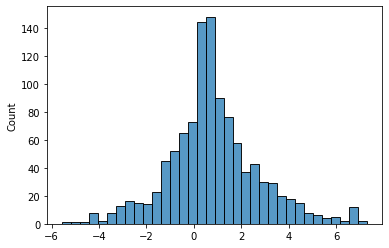

In [27]:
import seaborn as sns
sns.histplot(init_scores)

<Axes: ylabel='Count'>

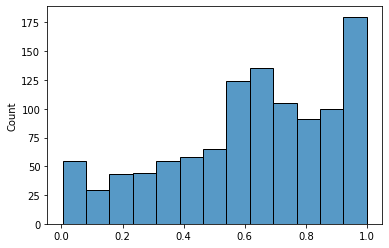

In [29]:
sns.histplot(F.sigmoid(init_scores))

In [31]:
F.sigmoid(init_scores)[init_correctness].mean()

tensor(0.6686)

In [32]:
F.sigmoid(init_scores)[~init_correctness].mean()

tensor(0.5715)

In [33]:
F.sigmoid(final_scores)[init_correctness].mean()

tensor(0.7619)

In [34]:
F.sigmoid(final_scores)[~init_correctness].mean()

tensor(0.7984)

<Axes: ylabel='Count'>

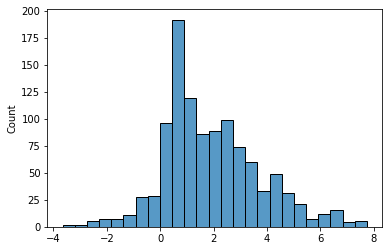

In [28]:
sns.histplot(final_scores)

<Axes: ylabel='Count'>

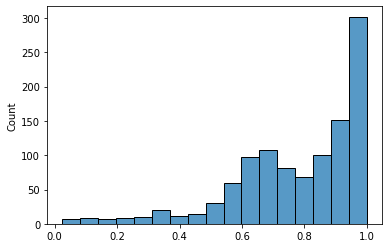

In [30]:
sns.histplot(F.sigmoid(final_scores))

In [21]:
ts_macro_f1

0.2509825123311368

In [37]:
correct_init_mask = init_correctness
correct_msp_mask = final_correctness
for threshold in [0.6, 0.7, 0.8, 0.9]:
    uncertain_init_mask = F.sigmoid(init_scores) < threshold
    condition_mask = ~uncertain_init_mask
    print(f"*********************Threshold: {threshold}****************************")
    print("Init")
    # init prediction
    print((condition_mask&correct_init_mask).sum().item(), 
        (condition_mask).sum().item(), 
        (condition_mask&correct_init_mask).sum().item()/(condition_mask).sum().item())
    # init prediction
    print((~condition_mask&correct_init_mask).sum().item(), 
        (~condition_mask).sum().item(), 
       (~condition_mask&correct_init_mask).sum().item()/(~condition_mask).sum().item())
    print("MSP")
    # msp prediction
    print((condition_mask&correct_msp_mask).sum().item(), 
        (condition_mask).sum().item(), 
        (condition_mask&correct_msp_mask).sum().item()/(condition_mask).sum().item())
    # msp prediction
    print((~condition_mask&correct_msp_mask).sum().item(), 
        (~condition_mask).sum().item(), 
        (~condition_mask&correct_msp_mask).sum().item()/(~condition_mask).sum().item())
    print("MSP & Init")
    print(((condition_mask&correct_init_mask)&(condition_mask&correct_msp_mask)).sum().item())
    # print(((~(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask))& correct_msp_mask)&(~(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask))& correct_init_mask)).sum().item())
    print(((condition_mask&correct_init_mask)|(condition_mask&correct_msp_mask)).sum().item(),
          (condition_mask).sum().item(), 
          ((condition_mask&correct_init_mask)|(condition_mask&correct_msp_mask)).sum().item()/(condition_mask).sum().item())
    print(((~condition_mask&correct_init_mask)|(~condition_mask&correct_msp_mask)).sum().item(),
          (~condition_mask).sum().item(), 
          ((~condition_mask&correct_init_mask)|(~condition_mask&correct_msp_mask)).sum().item()/(~condition_mask).sum().item())
    # print("Permutation")
    # print((condition_mask&correct_permutation_mask).sum().item(), 
    #     (condition_mask).sum().item(), 
    #     (condition_mask&correct_permutation_mask).sum().item()/(condition_mask).sum().item())
    # print((~condition_mask&correct_permutation_mask).sum().item(), 
    #      (~condition_mask).sum().item(), 
    #     (~condition_mask&correct_permutation_mask).sum().item()/(~condition_mask).sum().item())
    # print("Permutation Confident")
    # print((condition_mask&correct_permutation_confident_mask).sum().item(), 
    #     (condition_mask).sum().item(), 
    #     (condition_mask&correct_permutation_confident_mask).sum().item()/(condition_mask).sum().item())
    # print((~condition_mask&correct_permutation_confident_mask).sum().item(),
    #         (~condition_mask).sum().item(), 
    #         (~condition_mask&correct_permutation_confident_mask).sum().item()/(~condition_mask).sum().item())

*********************Threshold: 0.6****************************
Init
374 637 0.5871271585557299
206 447 0.4608501118568233
MSP
366 637 0.5745682888540031
209 447 0.46756152125279643
MSP & Init
343
397 637 0.6232339089481946
240 447 0.5369127516778524
*********************Threshold: 0.7****************************
Init
250 463 0.5399568034557235
330 621 0.5314009661835749
MSP
250 463 0.5399568034557235
325 621 0.5233494363929146
MSP & Init
229
271 463 0.5853131749460043
366 621 0.5893719806763285
*********************Threshold: 0.8****************************
Init
184 339 0.5427728613569321
396 745 0.5315436241610738
MSP
178 339 0.5250737463126843
397 745 0.5328859060402684
MSP & Init
170
192 339 0.5663716814159292
445 745 0.5973154362416108
*********************Threshold: 0.9****************************
Init
130 209 0.6220095693779905
450 875 0.5142857142857142
MSP
126 209 0.6028708133971292
449 875 0.5131428571428571
MSP & Init
122
134 209 0.6411483253588517
503 875 0.5748571428571428

In [38]:
model.eval()
model = model.to(device)
ft_embs_test = []
labels_test = []
logits_test = []
num_cols = []
for batch_idx, batch in enumerate(valid_dataloader_iter):
    cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
    target_col_mask = batch["target_col_mask"].T
    logits, embs = model(batch["data"].T, cls_indexes=cls_indexes, get_enc=True)
    labels_test.append(batch["label"].cpu())
    logits_test.append(logits.detach().cpu())
    num_cols.append(batch["target_col_mask"].max().item())
    ft_embs_test.append(embs.detach().cpu().reshape(1, -1))
labels_test = torch.cat(labels_test, dim=0)
logits_test = torch.stack(logits_test, dim=0)
preds_test = torch.argmax(logits_test, dim=1)
num_cols = torch.tensor(num_cols)
ft_embs_test = torch.cat(ft_embs_test, dim=0)
from sklearn.metrics import confusion_matrix, f1_score
mask = num_cols > 0
ts_pred_list = logits_test.argmax(
                            1).cpu().detach().numpy().tolist()
ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="micro")
ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="macro")
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
ts_pred_list = logits_test.argmax(
                            1).cpu().detach()[mask].numpy().tolist()
ts_micro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                    ts_pred_list,
                    average="micro")
ts_macro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                    ts_pred_list,
                    average="macro")
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
ts_pred_list = logits_test.argmax(
                            1).cpu().detach()[~mask].numpy().tolist()
ts_micro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                    ts_pred_list,
                    average="micro")
ts_macro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                    ts_pred_list,
                    average="macro")
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))

ts_micro_f1=0.5503, ts_macro_f1=0.3178
ts_micro_f1=0.5493, ts_macro_f1=0.3178
ts_micro_f1=1.0000, ts_macro_f1=1.0000


In [40]:
embs = veri_embs[batch_idx][0].reshape(1,-1).to(device)
scores_init = verifier(embs)

In [ ]:
veri_label[batch_idx][0]

In [15]:

import itertools

def is_sublist(A, B):
    it = iter(B)
    return all(x in it for x in A)
def get_permutation(x):
    new = []
    x = x.tolist()
    if len(x) == 1:
        x = x[0]
    for k in x:
        if k not in new:
            new.append(k)
    return new


model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
verifier.eval()
verifier = verifier.to(device)
labels_test = []
logits_test = []
init_scores = []
init_correctness = []
final_scores = []
final_correctness = []
with torch.no_grad():
    for batch_idx, batch in enumerate(valid_dataloader_iter):
        embs = veri_embs[batch_idx][0].reshape(1,-1).to(device)
        logits = veri_logits[batch_idx][0].reshape(-1).to(device)
        scores_init = verifier(embs)
        max_score = -float("inf")

        init_scores.append(scores_init.item())
        init_correctness.append(logits.argmax().item() == batch["label"].item())
        init_permutation_i = get_permutation(target_col_mask)
        col_idx_set = target_col_mask.unique().tolist()
        early_stop = False
        for i in range(len(veri_embs[batch_idx])):
            logits_temp = veri_logits[batch_idx][i].reshape(-1).to(device)
            embs_temp = veri_embs[batch_idx][i].reshape(1,-1).to(device)
            scores_temp = verifier(embs_temp).item()
            predict_temp = logits_temp.argmax().item()
            # if len(x) == 1 and 0 in x:
            #     predict_target = predict_temp
            #     msp_target = msp_temp
            # # print(x, msp_temp, predict_temp)
            # if 0 not in x and msp_temp > debias_threshold and (predict_temp != predict_target):
            #     debias_classes.append(predict_temp)
            #     continue
            if scores_temp > max_score:
                max_score = scores_temp
                logits = logits_temp.clone()
        final_scores.append(max_score)
        final_correctness.append(logits.argmax().item() == batch["label"].item())
        labels_test.append(batch["label"].cpu())
        logits_test.append(logits.detach().cpu())
    labels_test = torch.cat(labels_test, dim=0)
    logits_test = torch.stack(logits_test, dim=0)
    preds_test = torch.argmax(logits_test, dim=1)




from sklearn.metrics import confusion_matrix, f1_score
ts_pred_list = logits_test.argmax(
                            1).cpu().detach().numpy().tolist()
ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="micro")
ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="macro")
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))

ts_micro_f1=0.6621, ts_macro_f1=0.4545


In [111]:

import itertools

def is_sublist(A, B):
    it = iter(B)
    return all(x in it for x in A)
def get_permutation(x):
    new = []
    x = x.tolist()
    if len(x) == 1:
        x = x[0]
    for k in x:
        if k not in new:
            new.append(k)
    return new


model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
verifier.eval()
verifier = verifier.to(device)
labels_test = []
logits_test = []
init_scores = []
init_correctness = []
final_scores = []
final_correctness = []
with torch.no_grad():
    for batch_idx, batch in enumerate(test_dataloader_iter):
        embs = test_embs[batch_idx][0].reshape(1,-1).to(device)
        logits = test_logits[batch_idx][0].reshape(-1).to(device)
        scores_init = verifier(embs)
        max_score = -float("inf")

        init_scores.append(scores_init.item())
        init_correctness.append(logits.argmax().item() == batch["label"].item())
        init_permutation_i = get_permutation(target_col_mask)
        col_idx_set = target_col_mask.unique().tolist()
        early_stop = False
        for i in range(len(test_embs[batch_idx])):
            logits_temp = test_logits[batch_idx][i].reshape(-1).to(device)
            embs_temp = test_embs[batch_idx][i].reshape(1,-1).to(device)
            scores_temp = verifier(embs_temp).item()
            predict_temp = logits_temp.argmax().item()
            # if len(x) == 1 and 0 in x:
            #     predict_target = predict_temp
            #     msp_target = msp_temp
            # # print(x, msp_temp, predict_temp)
            # if 0 not in x and msp_temp > debias_threshold and (predict_temp != predict_target):
            #     debias_classes.append(predict_temp)
            #     continue
            if scores_temp > max_score:
                max_score = scores_temp
                logits = logits_temp.clone()
        final_scores.append(max_score)
        final_correctness.append(logits.argmax().item() == batch["label"].item())
        labels_test.append(batch["label"].cpu())
        logits_test.append(logits.detach().cpu())
    labels_test = torch.cat(labels_test, dim=0)
    logits_test = torch.stack(logits_test, dim=0)
    preds_test = torch.argmax(logits_test, dim=1)




from sklearn.metrics import confusion_matrix, f1_score
ts_pred_list = logits_test.argmax(
                            1).cpu().detach().numpy().tolist()
ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="micro")
ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="macro")
ts_f1_full = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average=None)
# full_f1_init
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))

ts_micro_f1=0.5576, ts_macro_f1=0.2834


In [113]:
ts_f1_full - full_f1_init

array([-0.03246206, -0.04829908,  0.086727  ,  0.04106206, -0.01851852,
       -0.03611111, -0.05656566,  0.02      , -0.18245614, -0.04158004,
        0.10636443,  0.0872211 , -0.01515152,  0.24728261,  0.00579151,
        0.02988506,  0.07655502,  0.03333333,  0.07142857,  0.07692308,
        0.07179487,  0.03259259,  0.03428571,  0.1122807 ,  0.160401  ,
       -0.02564103,  0.16190476,  0.        ,  0.01098901,  0.1       ,
        0.        ,  0.        ,  0.        , -0.22794118, -0.14444444,
        0.07142857, -0.26666667,  0.02222222,  0.08333333, -0.2       ,
        0.        ,  0.        , -0.02197802,  0.14141414,  0.        ,
        0.        ,  0.        ,  0.4       ,  0.23809524,  0.0952381 ,
        0.28571429,  0.66666667,  0.16666667,  0.03571429, -0.66666667,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.06060606,  0.        ,
        0.        ,  0.        ,  0.16666667, -0.33333333,  0.16

In [18]:
correct_init_mask = torch.tensor(init_correctness)
correct_msp_mask = torch.tensor(final_correctness)
init_scores = torch.tensor(init_scores)
final_scores = torch.tensor(final_scores)
for threshold in [0.5, 0.6, 0.7, 0.8, 0.9]:
    uncertain_init_mask = F.sigmoid(init_scores) < threshold
    condition_mask = ~uncertain_init_mask
    print(f"*********************Threshold: {threshold}****************************")
    print("Init")
    # init prediction
    print((condition_mask&correct_init_mask).sum().item(), 
        (condition_mask).sum().item(), 
        (condition_mask&correct_init_mask).sum().item()/(condition_mask).sum().item())
    # init prediction
    print((~condition_mask&correct_init_mask).sum().item(), 
        (~condition_mask).sum().item(), 
       (~condition_mask&correct_init_mask).sum().item()/(~condition_mask).sum().item())
    print("MSP")
    # msp prediction
    print((condition_mask&correct_msp_mask).sum().item(), 
        (condition_mask).sum().item(), 
        (condition_mask&correct_msp_mask).sum().item()/(condition_mask).sum().item())
    # msp prediction
    print((~condition_mask&correct_msp_mask).sum().item(), 
        (~condition_mask).sum().item(), 
        (~condition_mask&correct_msp_mask).sum().item()/(~condition_mask).sum().item())
    print("MSP & Init")
    print(((condition_mask&correct_init_mask)&(condition_mask&correct_msp_mask)).sum().item())
    # print(((~(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask))& correct_msp_mask)&(~(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask))& correct_init_mask)).sum().item())
    print(((condition_mask&correct_init_mask)|(condition_mask&correct_msp_mask)).sum().item(),
          (condition_mask).sum().item(), 
          ((condition_mask&correct_init_mask)|(condition_mask&correct_msp_mask)).sum().item()/(condition_mask).sum().item())
    print(((~condition_mask&correct_init_mask)|(~condition_mask&correct_msp_mask)).sum().item(),
          (~condition_mask).sum().item(), 
          ((~condition_mask&correct_init_mask)|(~condition_mask&correct_msp_mask)).sum().item()/(~condition_mask).sum().item())
    # print("Permutation")

*********************Threshold: 0.5****************************
Init
449 617 0.7277147487844409
132 468 0.28205128205128205
MSP
451 617 0.7309562398703403
155 468 0.3311965811965812
MSP & Init
441
459 617 0.7439222042139384
188 468 0.4017094017094017
*********************Threshold: 0.6****************************
Init
433 586 0.7389078498293515
148 499 0.2965931863727455
MSP
432 586 0.7372013651877133
174 499 0.3486973947895792
MSP & Init
425
440 586 0.7508532423208191
207 499 0.4148296593186373
*********************Threshold: 0.7****************************
Init
413 555 0.7441441441441441
168 530 0.3169811320754717
MSP
413 555 0.7441441441441441
193 530 0.3641509433962264
MSP & Init
406
420 555 0.7567567567567568
227 530 0.42830188679245285
*********************Threshold: 0.8****************************
Init
393 524 0.75
188 561 0.33511586452762926
MSP
393 524 0.75
213 561 0.37967914438502676
MSP & Init
387
399 524 0.7614503816793893
248 561 0.44206773618538325
*********************Th

/tmp/ipykernel_3640352/4058371166.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  init_scores = torch.tensor(init_scores)
/tmp/ipykernel_3640352/4058371166.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  final_scores = torch.tensor(final_scores)


# table search

In [22]:
column_list_1 = [
    "Name: Philip Duffy; Jeremy Oppenheim; Mark Sedwill;",
    "Mode of Travel: Air; Taxi; Air;",
    "Purpose: Regional Meeting; Exchange Visit; Evening Meal;",
    "Destination: London; Ottawa; Bristol;",
    "Day: 10; 30; 02;",
    "Month: April; July; September;",
    "Year: 2019; 2019; 2019;",
    "Expense: 189.06; 8.08; 50.00;"
]


In [33]:

cur_maxlen = min(max_length, 512 // len(column_list_1) - 1)

# print(tokenizer.cls_token)
# print(group_df["data"])
token_ids_list = [tokenizer.encode(
                tokenizer.cls_token + " " + str(x), add_special_tokens=False, max_length=cur_maxlen, truncation=True) for x in column_list_1]
token_ids = torch.LongTensor(reduce(operator.add,
                                    token_ids_list)).to(device)
cls_index_list = [0] + np.cumsum(
    np.array([len(x) for x in token_ids_list])).tolist()[:-1]
cls_indexes = torch.LongTensor(cls_index_list).to(device).reshape(-1, 1)
cls_indexes = torch.hstack([torch.zeros_like(cls_indexes), cls_indexes])
logits, embs_1 = model(token_ids.reshape(1, -1), cls_indexes=cls_indexes, get_enc=True)

In [58]:
import torch.nn as nn
cur_maxlen = min(max_length, 512 // len(column_list_1) - 1)

# print(tokenizer.cls_token)
# print(group_df["data"])
token_ids_list = [tokenizer.encode(
                tokenizer.cls_token + " " + str(x), add_special_tokens=False, max_length=cur_maxlen, truncation=True) for x in column_list_1]
token_ids = nn.utils.rnn.pad_sequence(
      [torch.tensor(x) for x in token_ids_list], padding_value=tokenizer.pad_token_id).to(device)
cls_indexes = torch.nonzero(
                token_ids == tokenizer.cls_token_id)
logits, embs_1_seperate = model(token_ids, cls_indexes=cls_indexes, get_enc=True)

In [63]:
column_list_2 = [
    "Name: Clark; Gyimah; Harrington;",
    "Date: 23/07; 03/09; 05/08;",
    "Destination: France; Belgium; China;",
    "Purpose: Discuss EU; Build Relations; Discuss Productivity;",
]
cur_maxlen = min(max_length, 512 // len(column_list_2) - 1)

# print(tokenizer.cls_token)
# print(group_df["data"])
token_ids_list = [tokenizer.encode(
                tokenizer.cls_token + " " + str(x), add_special_tokens=False, max_length=cur_maxlen, truncation=True) 
                  for x in column_list_2]
token_ids = torch.LongTensor(reduce(operator.add,
                                    token_ids_list)).to(device)
cls_index_list = [0] + np.cumsum(
    np.array([len(x) for x in token_ids_list])).tolist()[:-1]
cls_indexes = torch.LongTensor(cls_index_list).to(device).reshape(-1, 1)
cls_indexes = torch.hstack([torch.zeros_like(cls_indexes), cls_indexes])
logits, embs_2 = model(token_ids.reshape(1, -1), cls_indexes=cls_indexes, get_enc=True)

In [73]:
token_ids = token_ids.reshape(1, -1)
attention_mask = token_ids != 0
res = model.bert(token_ids, attention_mask=attention_mask, return_dict=True, output_attentions=True)

BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


In [76]:
len(res['attentions'])

12

In [77]:
res['attentions'][0]

torch.Size([1, 12, 47, 47])

In [79]:
res['attentions'][0].squeeze().mean(0).shape

torch.Size([47, 47])

In [89]:
res['attentions'][0].squeeze().mean(0)[cls_mask][:, cls_mask]

tensor([[0.1229, 0.2070, 0.1410, 0.1387],
        [0.0706, 0.2805, 0.1124, 0.0850],
        [0.0726, 0.1788, 0.2063, 0.1059],
        [0.0787, 0.1273, 0.1170, 0.2293]], device='cuda:0',
       grad_fn=<IndexBackward0>)

In [94]:
cls_mask = (token_ids==tokenizer.cls_token_id).reshape(-1)
acc_attention = []
for i in range(len(res['attentions'])):
    attn_i = res['attentions'][i].squeeze().mean(0)[cls_mask][:, cls_mask].mean(0)
    acc_attention.append(attn_i)
    print(attn_i)
acc_attention = torch.stack(acc_attention, dim=0)

tensor([0.0862, 0.1984, 0.1442, 0.1397], device='cuda:0',
       grad_fn=<MeanBackward1>)
tensor([0.1911, 0.1100, 0.1367, 0.1355], device='cuda:0',
       grad_fn=<MeanBackward1>)
tensor([0.3175, 0.0678, 0.1071, 0.0799], device='cuda:0',
       grad_fn=<MeanBackward1>)
tensor([0.2838, 0.0439, 0.0646, 0.0359], device='cuda:0',
       grad_fn=<MeanBackward1>)
tensor([0.0532, 0.0339, 0.0359, 0.0215], device='cuda:0',
       grad_fn=<MeanBackward1>)
tensor([0.0197, 0.0310, 0.0400, 0.0251], device='cuda:0',
       grad_fn=<MeanBackward1>)
tensor([0.0175, 0.0553, 0.0463, 0.0215], device='cuda:0',
       grad_fn=<MeanBackward1>)
tensor([0.0207, 0.0101, 0.0224, 0.0223], device='cuda:0',
       grad_fn=<MeanBackward1>)
tensor([0.0221, 0.0504, 0.0575, 0.0379], device='cuda:0',
       grad_fn=<MeanBackward1>)
tensor([0.0858, 0.0916, 0.1262, 0.0552], device='cuda:0',
       grad_fn=<MeanBackward1>)
tensor([0.0429, 0.0663, 0.1021, 0.0942], device='cuda:0',
       grad_fn=<MeanBackward1>)
tensor([0.

In [96]:
cls_mask = (token_ids==tokenizer.cls_token_id).reshape(-1)
acc_attention = torch.ones_like(res['attentions'][0].squeeze().mean(0)[cls_mask][:, cls_mask].mean(0))
for i in range(len(res['attentions'])-1, -1, -1):
    attn_i = res['attentions'][i].squeeze().mean(0)[cls_mask][:, cls_mask].mean(0)
    acc_attention = acc_attention * attn_i
    print(acc_attention)

tensor([0.0207, 0.0475, 0.0998, 0.0851], device='cuda:0',
       grad_fn=<MulBackward0>)
tensor([0.0009, 0.0032, 0.0102, 0.0080], device='cuda:0',
       grad_fn=<MulBackward0>)
tensor([7.6240e-05, 2.8848e-04, 1.2860e-03, 4.4200e-04], device='cuda:0',
       grad_fn=<MulBackward0>)
tensor([1.6872e-06, 1.4552e-05, 7.4002e-05, 1.6757e-05], device='cuda:0',
       grad_fn=<MulBackward0>)
tensor([3.4952e-08, 1.4639e-07, 1.6596e-06, 3.7438e-07], device='cuda:0',
       grad_fn=<MulBackward0>)
tensor([6.1142e-10, 8.0929e-09, 7.6920e-08, 8.0513e-09], device='cuda:0',
       grad_fn=<MulBackward0>)
tensor([1.2015e-11, 2.5077e-10, 3.0805e-09, 2.0201e-10], device='cuda:0',
       grad_fn=<MulBackward0>)
tensor([6.3881e-13, 8.5117e-12, 1.1060e-10, 4.3394e-12], device='cuda:0',
       grad_fn=<MulBackward0>)
tensor([1.8127e-13, 3.7366e-13, 7.1448e-12, 1.5571e-13], device='cuda:0',
       grad_fn=<MulBackward0>)
tensor([5.7560e-14, 2.5345e-14, 7.6492e-13, 1.2436e-14], device='cuda:0',
       grad_f

In [88]:
res['attentions'][0].squeeze().mean(0)[cls_mask][:, cls_mask].fill_diagonal_(0).mean(0)

tensor([0.0555, 0.1283, 0.0926, 0.0824], device='cuda:0',
       grad_fn=<MeanBackward1>)

In [59]:
import torch.nn as nn
cur_maxlen = min(max_length, 512 // len(column_list_2) - 1)

# print(tokenizer.cls_token)
# print(group_df["data"])
token_ids_list = [tokenizer.encode(
                tokenizer.cls_token + " " + str(x), add_special_tokens=False, max_length=cur_maxlen, truncation=True) 
                  for x in column_list_2]
token_ids = nn.utils.rnn.pad_sequence(
      [torch.tensor(x) for x in token_ids_list], padding_value=tokenizer.pad_token_id).to(device)
cls_indexes = torch.nonzero(
                token_ids == tokenizer.cls_token_id)
logits, embs_2_seperate = model(token_ids, cls_indexes=cls_indexes, get_enc=True)

In [38]:
column_list_3 = [
    'Bird Name: Pine Siskin; American Robin; Northern Flicker;',
    'Scientific Name: Carduelis Pinus; Turdus migratorius; Colaptes auratus;',
    'Date: 2019; 2019; 2019;',
    'Location: Ottawa; Ottawa; London;'
]

cur_maxlen = min(max_length, 512 // len(column_list_3) - 1)

# print(tokenizer.cls_token)
# print(group_df["data"])
token_ids_list = [tokenizer.encode(
                tokenizer.cls_token + " " + str(x), add_special_tokens=False, max_length=cur_maxlen, truncation=True) 
                  for x in column_list_3]
token_ids = torch.LongTensor(reduce(operator.add,
                                    token_ids_list)).to(device)
cls_index_list = [0] + np.cumsum(
    np.array([len(x) for x in token_ids_list])).tolist()[:-1]
cls_indexes = torch.LongTensor(cls_index_list).to(device).reshape(-1, 1)
cls_indexes = torch.hstack([torch.zeros_like(cls_indexes), cls_indexes])
logits, embs_3 = model(token_ids.reshape(1, -1), cls_indexes=cls_indexes, get_enc=True)

In [60]:
import torch.nn as nn
cur_maxlen = min(max_length, 512 // len(column_list_3) - 1)

# print(tokenizer.cls_token)
# print(group_df["data"])
token_ids_list = [tokenizer.encode(
                tokenizer.cls_token + " " + str(x), add_special_tokens=False, max_length=cur_maxlen, truncation=True) 
                  for x in column_list_3]
token_ids = nn.utils.rnn.pad_sequence(
      [torch.tensor(x) for x in token_ids_list], padding_value=tokenizer.pad_token_id).to(device)
cls_indexes = torch.nonzero(
                token_ids == tokenizer.cls_token_id)
logits, embs_3_seperate = model(token_ids, cls_indexes=cls_indexes, get_enc=True)

In [39]:
embs_1.shape

torch.Size([8, 768])

In [42]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_similarity(embs_1.detach().cpu().numpy(), embs_2.detach().cpu().numpy())

array([[ 0.8207278 ,  0.19450662,  0.20627114,  0.27426058],
       [ 0.3452878 ,  0.23242974,  0.5336273 ,  0.64597607],
       [ 0.33870924,  0.39381886,  0.5873476 ,  0.6411325 ],
       [ 0.34317726,  0.29647005,  0.68273383,  0.58981204],
       [ 0.12590188,  0.57557684,  0.12846455,  0.02838844],
       [ 0.08469278,  0.53540766,  0.01483871, -0.0364889 ],
       [ 0.11339067,  0.5485551 , -0.00187877, -0.03961209],
       [ 0.16596259,  0.13950422,  0.3106986 ,  0.34296668]],
      dtype=float32)

In [51]:
print(cosine_similarity(embs_1.detach().cpu().numpy(), embs_2.detach().cpu().numpy()).max(0))
cosine_similarity(embs_1.detach().cpu().numpy(), embs_2.detach().cpu().numpy()).max(0).sum()

[0.8207278  0.57557684 0.68273383 0.64597607]


2.7250144

In [61]:
print(cosine_similarity(embs_1_seperate.detach().cpu().numpy(), embs_2_seperate.detach().cpu().numpy()).max(0))
cosine_similarity(embs_1_seperate.detach().cpu().numpy(), embs_2_seperate.detach().cpu().numpy()).max(0).sum()

[0.96244603 0.963094   0.96277654 0.9627989 ]


3.8511155

In [47]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_similarity(embs_1.detach().cpu().numpy(), embs_3.detach().cpu().numpy()).astype(np.float16)

array([[ 1.4807e-01,  7.9468e-02,  8.3252e-02,  8.0013e-04],
       [ 9.3811e-02,  8.0750e-02,  1.4503e-02,  8.5144e-02],
       [ 1.4343e-01,  1.2451e-01,  1.3757e-01,  1.8555e-01],
       [ 1.3525e-01,  1.2488e-01,  4.9103e-02,  5.0732e-01],
       [ 1.3702e-02,  5.0278e-03,  4.6436e-01, -5.0476e-02],
       [ 3.7079e-03,  3.2673e-03,  6.6455e-01, -9.7839e-02],
       [ 4.4365e-03,  1.0633e-03,  7.2607e-01, -1.0065e-01],
       [-1.2636e-04, -5.4512e-03,  4.3701e-02,  3.2495e-01]],
      dtype=float16)

In [52]:
print(cosine_similarity(embs_1.detach().cpu().numpy(), embs_3.detach().cpu().numpy()).astype(np.float16).max(0))
cosine_similarity(embs_1.detach().cpu().numpy(), embs_3.detach().cpu().numpy()).astype(np.float16).max(0).sum()

[0.1481 0.1249 0.726  0.5073]


1.506

In [62]:
print(cosine_similarity(embs_1_seperate.detach().cpu().numpy(), embs_3_seperate.detach().cpu().numpy()).max(0))
cosine_similarity(embs_1_seperate.detach().cpu().numpy(), embs_3_seperate.detach().cpu().numpy()).max(0).sum()

[0.9623717  0.9630035  0.96271193 0.9627304 ]


3.8508177